In [1]:
import pandas as pd
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, RepeatedKFold,StratifiedKFold, train_test_split
from scipy.stats import randint as sp_randint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

#plt.xticks(rotation=60,fontsize=13)

ModuleNotFoundError: No module named 'mlxtend'

In [2]:
#desc(data)
#plot_confusion_matrix(cm):

def plotLearningCurve(_model,_ColList,_xtrain,_ytrain,_cv=5):
    from sklearn.model_selection import learning_curve
    _LC_output=learning_curve(_model, _xtrain[_ColList], _ytrain, n_jobs=-1, cv=_cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    _train_sizes, _train_scores, _test_scores =_LC_output[0],_LC_output[1],_LC_output[2]

    _train_scores_mean,_train_scores_std=np.mean(_LC_output[1], axis=1),np.std(_LC_output[1], axis=1)

    _test_scores_mean,_test_scores_std=np.mean(_LC_output[2], axis=1),np.std(_LC_output[2], axis=1)
    plt.figure(figsize=(15,5))
    plt.title("""Learning Curve to Understand wheather model has high bias, high variance or is ideal\n"""+str(_train_sizes))
    #plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    #print()
     # plot the std deviation as a transparent range at each training set size
    plt.fill_between(_train_sizes, _train_scores_mean - _train_scores_std, _train_scores_mean + _train_scores_std, alpha=0.1, color="r")
    plt.fill_between(_train_sizes, _test_scores_mean - _test_scores_std, _test_scores_mean + _test_scores_std, alpha=0.1, color="g")
    #print(train_scores_mean)  
        # plot the average training and test score lines at each training set size
    plt.plot(_train_sizes, _train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(_train_sizes, _test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
def desc(data):
    from sklearn.preprocessing import normalize
    unique_val=pd.DataFrame(index=data.columns)
    def obtain_variance(data):
        
        if data.dtypes in ('float64','int64'):
             xy1= pd.DataFrame(np.array(data*1.0))
             # variance values less than 0.006 ( threash hold), drop the column
            # If it is categorical binary column and if values 95:5 ratio, you drop the variable.
            #If it is continuous column and variance is less than 0.0066, you drop the variable (remember 0.0066 is value obtained after normalizing the variable).

             return "%3g"%xy1.var()[0]
        elif data.dtypes =='object':
            xy1= pd.DataFrame(data).copy()
            xy1.reset_index()
    def obtain_std(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).std()[0]
    def obtain_mean(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).mean()[0]
    def obtain_min(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).min()[0]
    def obtain_max(data):
        if data.dtypes in ('float64','int64'):
             return "%3g"%pd.DataFrame(data*1.0).max()[0]
    for i in data.columns:
        unique_val.loc[i,'dtypes']=data[i].dtypes
        unique_val.loc[i,'null_count']=data[i].isnull().sum() 
        unique_val.loc[i,'total_count']=data[i].notnull().sum()
        unique_val.loc[i,'unique_count']=data[i].nunique()
        unique_val.loc[i,'missing value ratio']="%0.2g" %(data[i].isnull().sum()/len(data)) +'%'
        unique_val.loc[i,'variance of numerics']= obtain_variance(data[i])
        unique_val.loc[i,'std']= obtain_std(data[i])
        unique_val.loc[i,'mean']= obtain_mean(data[i])
        unique_val.loc[i,'min']= obtain_min(data[i])
        unique_val.loc[i,'mean']= obtain_max(data[i])
    return unique_val.sort_values(by=['unique_count','null_count'])

def plot_confusion_matrix(cm):
    plt.figure(figsize=[9, 6])
  
    df_cm = pd.DataFrame(
        cm, index=['Actual: No','Actual: Yes'], columns=['Predicted: No','Predicted: Yes']
    )
    dd= pd.DataFrame(np.array([['TP','FN'],['FP','TN']]))
    print(dd)
    #sns.heatmap(np.array([['TP','FP'],['FN','TN']]), annot=True, annot_kws={"size": 20},fmt='g', yticklabels=False)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20},fmt='g', yticklabels=False,xticklabels=False)
    #plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Actual False      Actual True', fontsize=18)
    plt.ylabel('Predicted True           Predicted False', fontsize=18)
    
def plot_roc_curve(model,X,Y):
    from sklearn.metrics import roc_curve
    pred = model.predict_proba(X)[:,1]

    fpr, tpr, _ = roc_curve(Y,pred) 
    auc = roc_auc_score(Y, pred) 

    #print(fpr,tpr,auc)
    
    plt.figure(figsize=(12,8)) 
    plt.plot(fpr,tpr,label="Validation AUC-ROC="+str(auc)) 
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.legend(loc=4) 

def plot_pr_curve(model,X,Y):
    fig= plt.figure(figsize=(12,7))
    probas = model_lr.predict_proba(X)[:,1]
    pred = model_lr.predict(X)

    #fpr, tpr, _ = roc_curve(Y,pred) 
    precision, recall, thresholds = precision_recall_curve(Y, probas)
    f1 = f1_score(Y, pred)
    auc_s = auc(recall, precision)
    #f1,auc
    print(recall[:])
    print('Logistic: f1=%.3f auc=%.3f' % (f1, auc_s))
    no_skill=len(Y[Y==1]) / len(Y)
    plt.plot([0, 1], [no_skill, no_skill], marker='^',linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.ylabel('Precison',fontsize=25) 
    plt.xlabel('Recall',fontsize=25)
    plt.legend(loc=4)
    
def classificationModelfit_CV(ml_model,dataframe, Y,cols, rstate = 12, thres = 0.5,  plotROC=0):
    i = 1
    roc_scores = []
    tpr_scores=[]
    fpr_scores=[]
    precision_scores=[]
    recall_scores=[]
    confusion_matrix_scores=[]
    accuracy_scores=[]
    f1_scores=[]
    PRCprecisions=[]
    PRCrecalls=[]
    PRCauc_scores=[]
    Number_of_Trues=[]
    df1 = dataframe.copy()
    df1 = dataframe[cols]
    cv_scoredf=pd.DataFrame()
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,Y):
        
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = Y.loc[df_index],Y.loc[test_index]
        #print(xtr.shape,xvl.shape,ytr.shape,yvl.shape)
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
        
        #plot_roc_curve(model,xtr,ytr)
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
         
        # Calculate scores for each fold and print
        pred_val = pp
        
        # ROC Matrix Data
        fpr, tpr, ROC_Threshholds = roc_curve(yvl,pred_probs[:,1]) 
        roc_score = roc_auc_score(yvl,pred_probs[:,1])
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        accuracy_score1 = accuracy_score(yvl,pred_val)
        
        # Precession Recall matrix Data
        PRCprecision, PRCrecall, _ = precision_recall_curve(yvl, pred_probs[:,1])
        f1_sc = f1_score(yvl, pred_val)
        Number_of_True=len(yvl[yvl==1]) / len(yvl)
        PRCauc= auc(PRCrecall,PRCprecision)
        
        cm=confusion_matrix(yvl,pred_val)
        if plotROC==3:
            plot_confusion_matrix(cm)
         # Save scores

        roc_scores.append(roc_score)
        fpr_scores.append(fpr)
        tpr_scores.append(tpr)
        recall_scores.append(recall)
        precision_scores.append(precision)
        confusion_matrix_scores.append(cm)
        accuracy_scores.append(accuracy_score1)
        f1_scores.append(f1_sc)
        PRCprecisions.append(PRCprecision)
        PRCrecalls.append(PRCrecall)
        Number_of_Trues.append(Number_of_True)
        PRCauc_scores.append(PRCauc)
        
        i+=1   
    cv_scoredf['fpr_scores'] =fpr_scores
    cv_scoredf['tpr_scores'] =tpr_scores
    cv_scoredf['roc_scores'] =roc_scores
    cv_scoredf['recall_scores'] =recall_scores
    cv_scoredf['precision_scores'] =precision_scores
    cv_scoredf['confusion_matrix_scores']=confusion_matrix_scores
    cv_scoredf['accuracy_scores'] =accuracy_scores
    cv_scoredf['f1_scores'] =f1_scores
    cv_scoredf['PRCprecisions'] =PRCprecisions
    cv_scoredf['PRCrecalls'] =PRCrecalls
    cv_scoredf['Number_of_Trues'] =Number_of_Trues
    cv_scoredf['PRCauc_scores'] =PRCauc_scores
    
    
    if plotROC==1:
        plt.figure(figsize=(26,10))
        plt.title("""   ROC(Reciever Operating) Curve
    (Cross Validation)
    """,color='blue')
        #plt.plot(fpr,tpr,label="Non-CV AUC-ROC="+str("%  0.2f"%auc), linewidth=7,color='magenta') 
        for i in range(5):
            x = np.linspace(0, 1, 1000)
            plt.plot(x, x, linestyle='-')
            
            plt.plot(fpr_scores[i],tpr_scores[i],label="CV set=%i, Accuracy=%0.2f, AUC= %0.2f, Recall=%0.2f, Precison=%0.2f"
                     %(i,accuracy_scores[i],roc_scores[i],recall_scores[i],precision_scores[i])
                     ) 
            plt.legend(loc=4,fontsize=25)
            plt.xlabel('False Positive Rate') 
            plt.ylabel('True Positive Rate')          
    
    elif plotROC==2:  
        plt.figure(figsize=(26,10))
        plt.title("""   Precision Recall Curve
    (Cross Validation)
    """,color='blue')
        plt.plot([0, 1], [Number_of_Trues[0], Number_of_Trues[0]], marker='^',linestyle='--', label='Number of true values=%0.2f' %Number_of_Trues[0])

        for i in range(5):
                #  print("CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, Number_of_Trues=%0.2f, prcAUC_scores=%0.2f "
                #       %(i, accuracy_scores[i], f1_scores[i], Number_of_Trues[i], PRCauc_scores[i]  ))
                
                plt.plot(PRCrecalls[i],PRCprecisions[i], marker='.', 
                         label="CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, prcAUC_scores=%0.2f,Recall=%0.2f, Precison=%0.2f "
                      %(i, accuracy_scores[i], f1_scores[i], PRCauc_scores[i],recall_scores[i],precision_scores[i]  ))
                plt.ylabel('Precison',fontsize=25) 
                plt.xlabel('Recall',fontsize=25)
                plt.legend(loc=4,fontsize=25)         
    else:
        for i in range(5):
            print('\n{} of kfold {}'.format(i,kf.n_splits))
            sufix = ""
            msg = ""
            msg += "CV1 set=%i,Accuracy=%0.2f, AUC= %0.2f, Recall=%0.2f, Precison=%0.2f"%(i,accuracy_scores[i],roc_scores[i],recall_scores[i],precision_scores[i])
            print("{}".format(msg))
            print(confusion_matrix_scores[i])
            print("CV set=%i, Accuracy=%0.2f, f1_score=%0.2f, Number_of_Trues=%0.2f,prcAUC_scores=%0.2f, Recall=%0.2f, Precison=%0.2f"
              %(i,accuracy_scores[i],f1_scores[i],Number_of_Trues[i], PRCauc_scores[i],recall_scores[i],precision_scores[i] ))
            
    return cv_scoredf

def regressionModelfit_CV(alg, cols,  x, y,algo_name):
    #Fit the algorithm on the data
    print('------------      ' + algo_name + '     ------------')
    _list1=[]
    _df=pd.DataFrame(columns=[algo_name])
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import cross_validate
    xdata= x[cols]
    ydata=y
    alg.fit(xdata, ydata)
        
    #Predict training set:
    dtrain_predictions = alg.predict(xdata)

    
    cv_score = cross_val_score(alg, xdata, ydata, cv=4,scoring= 'neg_mean_squared_error')
    #Perform cross-validation:
    cv_matrix_score= cross_validate(alg, xdata, ydata, cv=4,scoring=(
                         'r2', 
                         'neg_mean_absolute_error',
                         'neg_mean_squared_error'
                         ),
                         return_train_score=True,verbose=0)
    #return cv_matrix_score
    avg_model_Scores=pd.DataFrame(cv_matrix_score).mean()
    for i in avg_model_Scores.index:
        
        if 'neg' in i :
            score="%s =%0.2f" %(i, np.sqrt(avg_model_Scores[i]*-1) )
            _df.loc[i]=np.sqrt(avg_model_Scores[i]*-1)
            print(score)
        else:
            score="%s =%0.2f" %(i, avg_model_Scores[i] )
            _df.loc[i]=avg_model_Scores[i]
            print(score)
    return _df[algo_name]
    #dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    #submission.to_csv(filename, index=False)

def getLinearModelScore(_model, xTrainingData,yTrainingData,columnlist):
    xTrainingData=xTrainingData[columnlist]
    x_train, x_test, y_train, y_test = train_test_split(xTrainingData,yTrainingData, test_size =0.3)
    _model.fit(x_train, y_train)
    ptrain = _model.predict(x_train)
    ptest = _model.predict(x_test)
    from sklearn.metrics import mean_squared_error
    print("train MSE="%(mean_squared_error(ptrain,y_train)))
    print("test MSE="%(mean_squared_error(ptest,y_test)))
    
    
    

In [9]:
!pip install getPreProcessingFunction

ERROR: Could not find a version that satisfies the requirement getPreProcessingFunction (from versions: none)
ERROR: No matching distribution found for getPreProcessingFunction


In [8]:
# My Customized wrapper Functions over Matplotlib and SeabornLib

import getPreProcessingFunction as PPM
import BiVEDA_Function as BiVEDA
import UniVEDA_catFunction as catUniVEDA
import UniVEDA_conti_methods as contiUniVEDA

ModuleNotFoundError: No module named 'getPreProcessingFunction'

In [4]:
  print("""Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.""")
  

Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.


In [5]:
# Bivariaate Analysis
#Conti_Vs_Cat_Cols_BoxPlot(gpByCategroical_Col, contineoua_col_name, dataFrame):
#Conti_Vs_Cat_Cols_MeanValue_barplot(catColList,Contineous_col, dataFrame):
#Bivariate_Ana_Catogorical_over_ContiLabel_Pivotmean(groupColumn, Conti_label_column, Dataframe):
#SNS_ScatterSubplots_Bivariate_conti_cols_with_yConti(conti_col,yColumn,df)

#crossTabHistGramPlotSplit(groupColumn, BinaryValColumn, Dataframe)
#crossTabHistGramPlot(groupColumn, BinaryValColumn, Dataframe):
#Bivariate_numericCol_Distribtion_overLabelClass(numeric_Conti_columnList,LabelColname,dataframe)

#correlation_heatmap(numeric_colList, dataframe)
#Bivariate_ana_conti_vs_Conti_label_scatter(conti_ColList,conti_label_name, dataFrame)

# privotTabHistGramPlot renamed to Bivariate_Ana_Catogorical_over_ContiLabel_Pivotmean


    
def crossTabHistGramPlot(groupColumn, BinaryValColumn, Dataframe):
    plt1 = plt
    i = 430
    j = 1
    fig= plt1.figure(figsize=(30,30))
    plt1.suptitle("Catagorical Cols Analysis with status/label columns " + BinaryValColumn)
    for colname in groupColumn:
        ax1 = plt1.subplot(j+i)
        i = i + 1
        CreditHistory_loanStatus = pd.crosstab(Dataframe[colname], Dataframe[BinaryValColumn])
        CreditHistory_loanStatus.plot(kind='bar', stacked=True, grid=False, ax = ax1)
        plt1.xticks(rotation=12,fontsize=25)
        plt1.xlabel(colname,fontsize=25)
        plt1.ylabel(BinaryValColumn)
        
        plt1.legend(fontsize=20)
        #plt1.title(colname)
    plt1.show()

In [2]:
train_org=pd.read_csv("train_v9rqX0R.csv")
test_org=pd.read_csv("test_AbJTz2l.csv")
train=train_org.copy()
test=test_org.copy()
label_col='Item_Outlet_Sales'
ntest=test.shape[1]
print(train.shape,test.shape)

(8523, 12) (5681, 11)


In [4]:
ntrain=train.shape[0]
ntrain

8523

In [5]:
train_test=pd.concat([train_org,test_org],ignore_index=True)

In [10]:
#PPM.desc(test_org)

In [13]:
PPM.desc1(train_org,1,label_col)

NameError: name 'PPM' is not defined

In [11]:
summy=PPM.desc1(train_org,1,label_col)
object_cols=summy[summy['dtypes']=='object'].index
object_cols=set(object_cols).difference(set(['Item_Identifier']))
numeric_cols=summy[summy['dtypes']!='object'].index.drop(label_col)
id=['Item_Identifier','Outlet_Identifier']

 Bar char for Categorial Columns 
{'Outlet_Identifier', 'Outlet_Location_Type', 'Item_Type', 'Outlet_Size', 'Outlet_Type', 'Item_Fat_Content'}


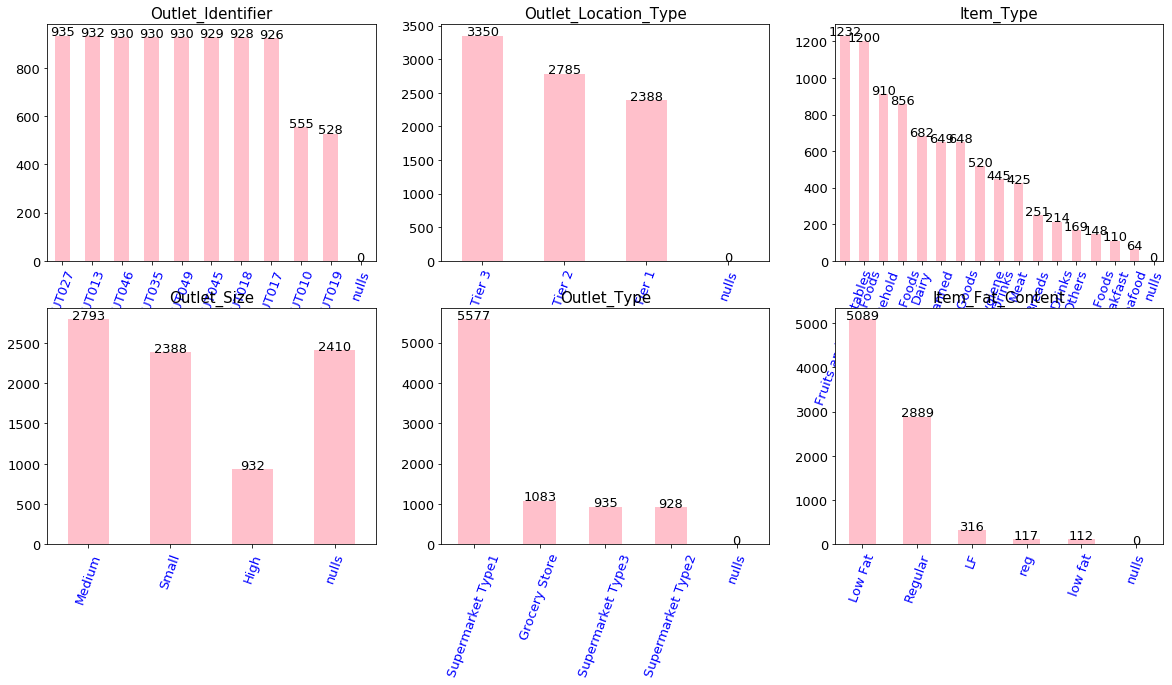

In [12]:
catUniVEDA.UniVEDA_cat_cols_BAR(object_cols,train_org)

In [13]:
# Encoding Item_Fat_Content

In [14]:
# 
#  1) Item Fat content Categories are mis-spelled
#  2) the Item Type , there are many different categories, So it need to merged somehow
#  3) Super market2 and super market 3 can be merged in Outlet type, As sub categrory are not distributed properly.

# We use
print('\nModified Categories for :' , 'Item_Fat_Content')
train_test['Item_Fat_Content'] = train_test['Item_Fat_Content'].replace({'LF': 1,
                                                                         'Low Fat':1,
                                                                         'low fat':1,
                                                                         'reg':2,
                                                                         'Regular':2
                                                                        })



Modified Categories for : Item_Fat_Content


In [15]:
# Imputing Nulls Outlet_Size

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

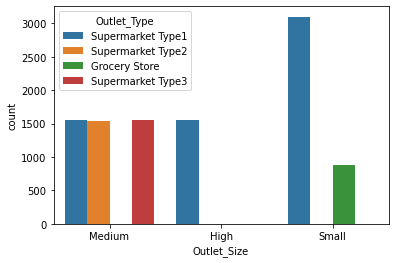

In [16]:
import seaborn as sns
sns.countplot('Outlet_Size',hue='Outlet_Type',data=train_test)


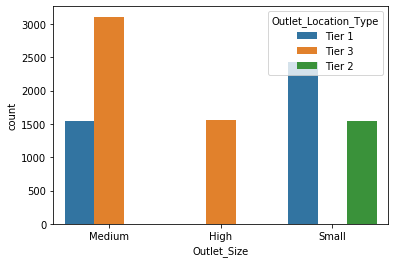

In [17]:
sns.countplot('Outlet_Size',hue='Outlet_Location_Type',data=train_test)

In [18]:
#train_test.pivot_table('Outlet_Size',index='Outlet_Identifier',aggfunc=pd.Series.mode)
train.groupby(['Outlet_Identifier'])['Outlet_Type'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Identifier
OUT010        Grocery Store
OUT013    Supermarket Type1
OUT017    Supermarket Type1
OUT018    Supermarket Type2
OUT019        Grocery Store
OUT027    Supermarket Type3
OUT035    Supermarket Type1
OUT045    Supermarket Type1
OUT046    Supermarket Type1
OUT049    Supermarket Type1
Name: Outlet_Type, dtype: object

In [17]:
#train_test.pivot_table('Outlet_Size',index='Outlet_Identifier',aggfunc=pd.Series.mode)
test.groupby(['Outlet_Identifier'])['Outlet_Type'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Identifier
OUT010        Grocery Store
OUT013    Supermarket Type1
OUT017    Supermarket Type1
OUT018    Supermarket Type2
OUT019        Grocery Store
OUT027    Supermarket Type3
OUT035    Supermarket Type1
OUT045    Supermarket Type1
OUT046    Supermarket Type1
OUT049    Supermarket Type1
Name: Outlet_Type, dtype: object

In [21]:
train[train['Outlet_Size'].isna()]['Outlet_Location_Type'].value_counts()

Tier 2    1855
Tier 3     555
Name: Outlet_Location_Type, dtype: int64

In [18]:
train.groupby(['Outlet_Location_Type'])['Outlet_Size'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Location_Type
Tier 1     Small
Tier 2     Small
Tier 3    Medium
Name: Outlet_Size, dtype: object

In [23]:
#train[train['Outlet_Size'].isna()]

In [19]:
nulls_loc=train[train['Outlet_Size'].isna()]['Outlet_Location_Type'].value_counts().index
print(nulls_loc)
train[train['Outlet_Size'].isna()].groupby(['Outlet_Identifier'])['Outlet_Location_Type'].agg(pd.Series.mode)

Index(['Tier 2', 'Tier 3'], dtype='object')


Outlet_Identifier
OUT010    Tier 3
OUT017    Tier 2
OUT045    Tier 2
Name: Outlet_Location_Type, dtype: object

In [22]:
train.groupby(['Outlet_Location_Type'])['Outlet_Size'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Location_Type
Tier 1     Small
Tier 2     Small
Tier 3    Medium
Name: Outlet_Size, dtype: object

In [23]:
train.groupby(['Outlet_Location_Type'])['Outlet_Type'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Location_Type
Tier 1    Supermarket Type1
Tier 2    Supermarket Type1
Tier 3    Supermarket Type3
Name: Outlet_Type, dtype: object

In [24]:
train.groupby(['Outlet_Type'])['Outlet_Size'].agg(pd.Series.mode)#.mode(np.mode())

Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object

In [6]:
cond=(train_test['Outlet_Size'].isna())
train_test.loc[cond & (train_test['Outlet_Identifier']=='OUT010') & (train_test['Outlet_Type']=='Grocery Store'),'Outlet_Size']='Medium'
train_test.loc[cond & (train_test['Outlet_Identifier']=='OUT045') & (train_test['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']='Small'
train_test.loc[cond & (train_test['Outlet_Identifier']=='OUT017') & (train_test['Outlet_Type']=='Supermarket Type1'),'Outlet_Size']='Small'

In [7]:
# Encoding Outlet_Size

In [8]:
train_test['Outlet_Size']=train_test['Outlet_Size'].replace({'Small':1,
                                                            'Medium':2,
                                                            'High':3})

In [9]:
PPM.desc(train_test)

NameError: name 'PPM' is not defined

In [29]:
# Imputing nulls in Item_Weight

In [10]:
cond=(train_test['Item_Weight'].isna())
train_test.loc[cond,'Item_Identifier'].nunique()
#map1=dict(train_test.groupby(['Item_Identifier'])['Item_Weight'].median())
#map1

1559

In [11]:
cond=(train_test['Item_Weight'].isna())
train_test.loc[cond,'Item_Weight']
map1=dict(train_test.groupby(['Item_Identifier'])['Item_Weight'].median())
map1
#pd.pivot_table('Item_Weight',index='Item_Identifier',aggfunc=np.mean())
train_test.loc[cond,'Item_Weight']=train_test.loc[cond,'Item_Identifier'].apply(lambda x :map1[x] )

In [32]:
PPM.desc(train_test)

dtypes  null_count  total count  unique_count  \
Item_Fat_Content             int64         0.0      14204.0           2.0   
Outlet_Location_Type        object         0.0      14204.0           3.0   
Outlet_Size                  int64         0.0      14204.0           3.0   
Outlet_Type                 object         0.0      14204.0           4.0   
Outlet_Establishment_Year    int64         0.0      14204.0           9.0   
Outlet_Identifier           object         0.0      14204.0          10.0   
Item_Type                   object         0.0      14204.0          16.0   
Item_Weight                float64         0.0      14204.0         415.0   
Item_Identifier             object         0.0      14204.0        1559.0   
Item_Outlet_Sales          float64      5681.0       8523.0        3493.0   
Item_MRP                   float64         0.0      14204.0        8052.0   
Item_Visibility            float64         0.0      14204.0       13006.0   

                           missing value ratio  variance of numerics      std  \
Item_Fat_Content                           0.0                  0.23     0.48   
Outlet_Location_Type                       0.0                  0.00     0.00   
Outlet_Size                                0.0                  0.46     0.68   
Outlet_Type                                0.0                  0.00     0.00   
Outlet_Establishment_Year                  0.0                 70.08     8.37   
Outlet_Identifier                          0.0                  0.00     0.00   
Item_Type                                  0.0                  0.00     0.00   
Item_Weight                                0.0                 21.64     4.65   
Item_Identifier                            0.0                  0.00     0.00   
Item_Outlet_Sales                         40.0            2912140.00  1706.50   
Item_MRP                                   0.0               3854.79    62.09   
Item_Visibility                            0.0                  0.00     0.05   

                              mean       min       max   skew   kurt  
Item_Fat_Content              1.35     1.000      2.00  0.614 -1.624  
Outlet_Location_Type          0.00     0.000      0.00  0.000  0.000  
Outlet_Size                   1.61     1.000      3.00  0.655 -0.670  
Outlet_Type                   0.00     0.000      0.00  0.000  0.000  
Outlet_Establishment_Year  1997.83  1985.000   2009.00 -0.396 -1.206  
Outlet_Identifier             0.00     0.000      0.00  0.000  0.000  
Item_Type                     0.00     0.000      0.00  0.000  0.000  
Item_Weight                  12.79     4.555     21.35  0.100 -1.227  
Item_Identifier               0.00     0.000      0.00  0.000  0.000  
Item_Outlet_Sales          2181.29    33.290  13087.00  1.178  1.616  
Item_MRP                    141.00    31.290    266.89  0.131 -0.894  
Item_Visibility               0.07     0.000      0.33  1.195  1.820

In [12]:
train_test['Item_Visibility'].isna().sum()

0

In [13]:
train[train['Item_Visibility']==0]['Item_Identifier'].nunique()#groupby(['Item_Identifier'])Item_Visibility

446

In [14]:
train_test[train_test['Item_Visibility']>0]['Item_Visibility'].nunique()#groupby(['Item_Identifier'])Item_Visibility

13005

<AxesSubplot:xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

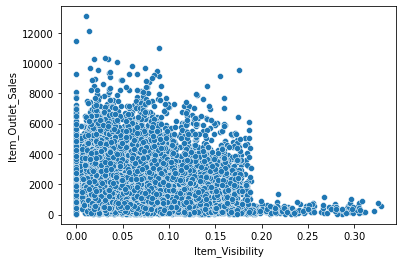

In [16]:
import seaborn as sns
sns.scatterplot(x='Item_Visibility',y=label_col,data=train)

In [17]:
train[train['Item_Visibility']<1.9].head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [29]:
itemID_vis_Map=dict(train_test[train_test['Item_Visibility']<1.9].groupby(['Item_Identifier'])['Item_Visibility'].mean().round(6))
#itemID_vis_Map

In [30]:
train.loc[train['Item_Visibility']>0.19,'Item_Visibility'].shape
train_test[:ntrain].loc[train_test[:ntrain]['Item_Visibility']>0.190,'Item_Visibility']=train_test[:ntrain].loc[train_test[:ntrain]['Item_Visibility']>0.190]['Item_Identifier'].apply(lambda x:itemID_vis_Map[x])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [21]:
train_test[:ntrain].loc[train_test[:ntrain]['Item_Visibility']==0,'Item_Visibility']=train_test[:ntrain].loc[train_test[:ntrain]['Item_Visibility']==0]['Item_Identifier'].apply(lambda x:itemID_vis_Map[x])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

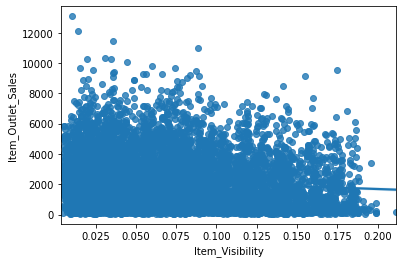

In [22]:
sns.regplot(x='Item_Visibility',y=label_col,data=train_test[:ntrain])

In [23]:
train_test[:ntrain].loc[train_test['Item_Visibility']>0.19,'Item_Visibility']

521     0.191440
854     0.195679
1805    0.198856
2586    0.192577
2677    0.195679
2855    0.211315
3474    0.199054
4382    0.190825
4674    0.191354
5031    0.191354
5150    0.198975
5734    0.195575
6674    0.199054
7388    0.192273
8273    0.194127
Name: Item_Visibility, dtype: float64

In [32]:
ouliers_items=train_test[:ntrain].loc[train_test['Item_Visibility']>0.19,'Item_Identifier']
#.value_counts()

In [33]:
newItemVisiMap=dict(train_test[:ntrain][train_test[:ntrain]['Item_Identifier'].isin(ouliers_items)].groupby('Item_Identifier')['Item_Visibility'].mean().round(5))

In [39]:
ouliers_items_idx=train_test[:ntrain].loc[train_test['Item_Visibility']>0.19,'Item_Identifier'].index
ouliers_items_idx

Int64Index([854, 2677, 2855], dtype='int64')

In [41]:
train_test.loc[ouliers_items_idx,'Item_Visibility']=train_test.loc[ouliers_items_idx]['Item_Identifier'].apply(lambda x:newItemVisiMap[x])

<AxesSubplot:xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

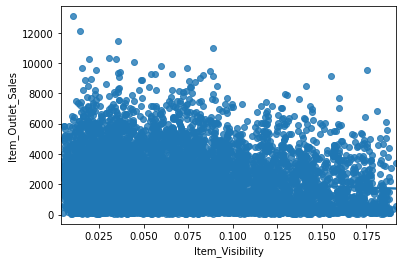

In [42]:
sns.regplot(x='Item_Visibility',y=label_col,data=train_test[:ntrain])

# Feature Engineering test

In [88]:
item_cols=[label_col,'Item_MRP','Item_Visibility']
df=train[item_cols]

In [44]:
df['Item_MRP_+_Visi']=df['Item_MRP'] + df['Item_Visibility']
df['Item_MRP_X_Visi']=df['Item_MRP'] * df['Item_Visibility']

<ipython-input-44-4d14619a3e4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item_MRP_+_Visi']=df['Item_MRP'] + df['Item_Visibility']
<ipython-input-44-4d14619a3e4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item_MRP_X_Visi']=df['Item_MRP'] * df['Item_Visibility']


In [45]:
PPM.desc1(df,1,label_col)

NameError: name 'PPM' is not defined

 Its a kind of scatter plot 
Index(['Item_MRP', 'Item_Visibility', 'Item_MRP_+_Visi', 'Item_MRP_X_Visi'], dtype='object')


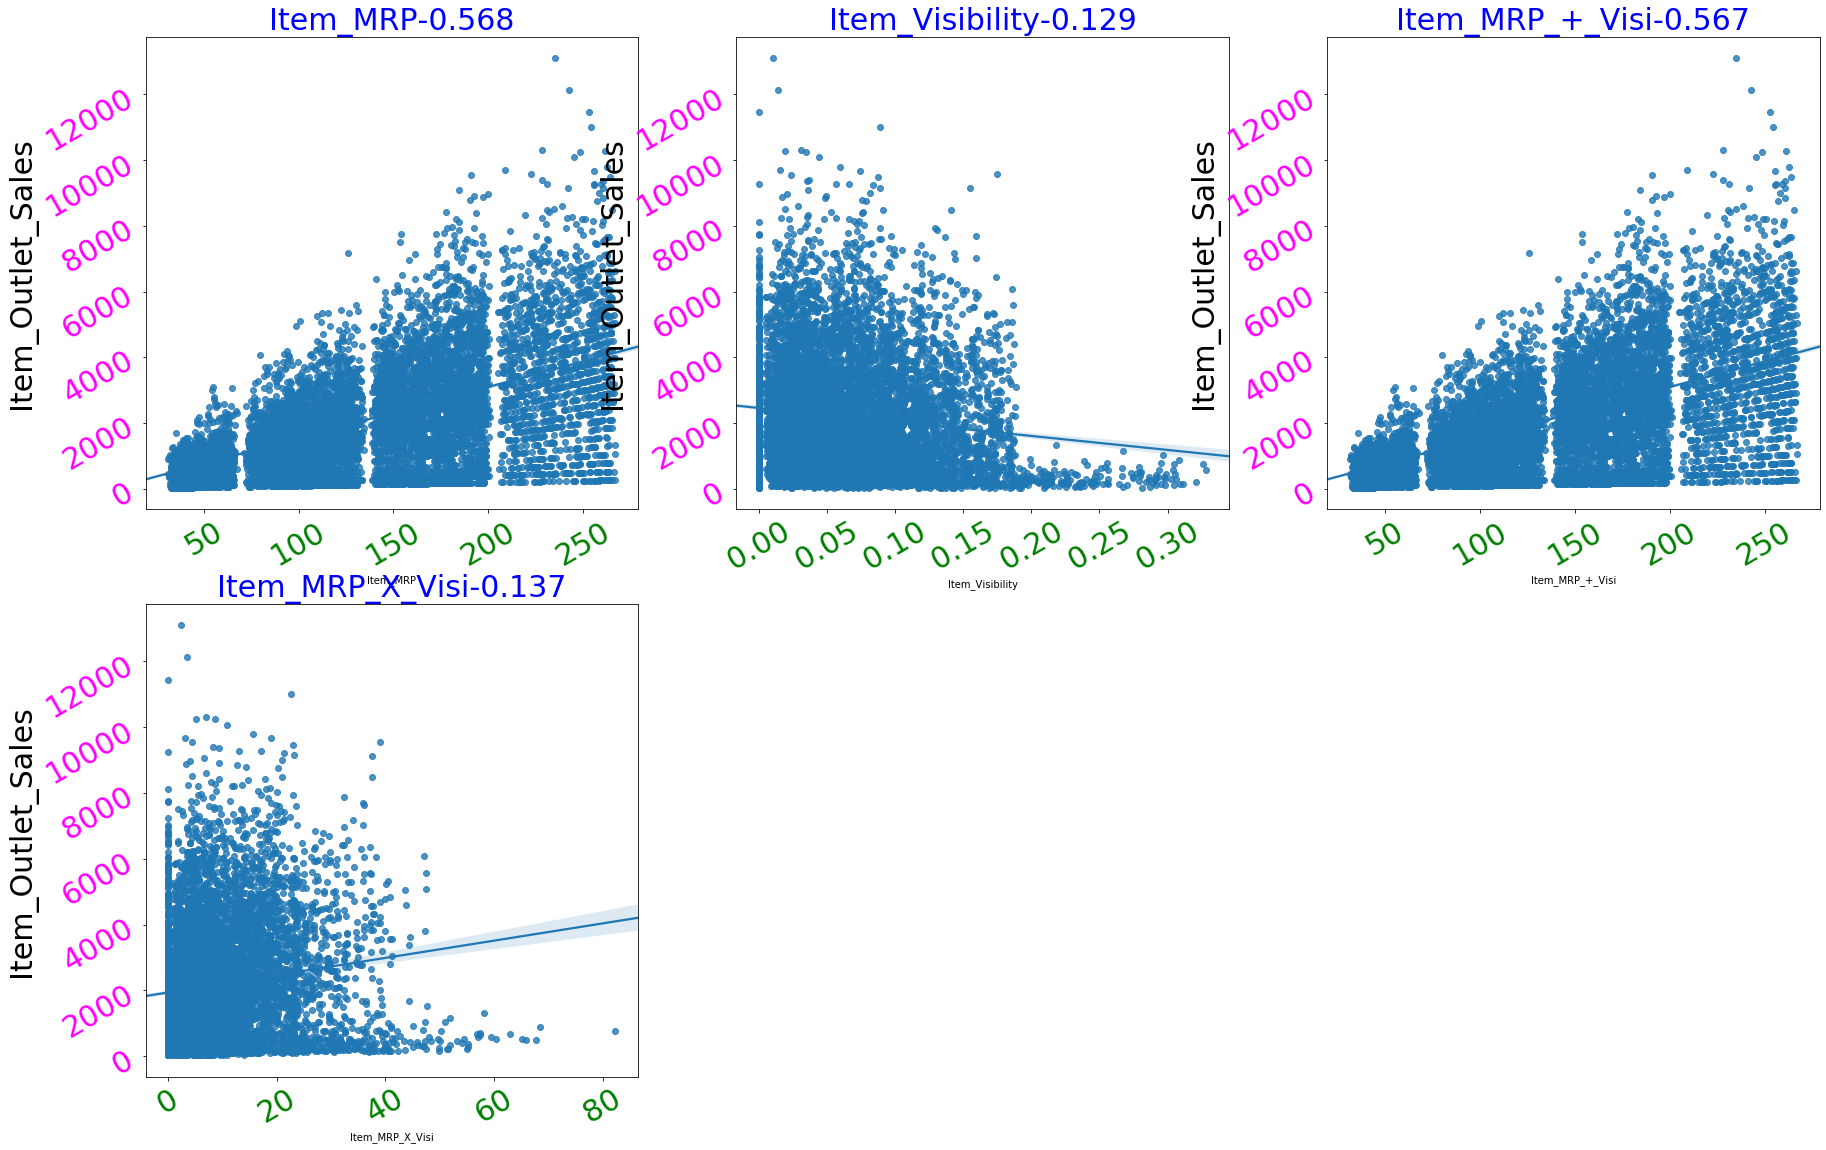

In [51]:
BiVEDA.BiVEDA_conti_cols_regplot_over_yConti(df.columns[1:],label_col, df)
#BiVEDA.All_VEDA_conti_higly_correlation_cols_pairplot_scatterplot(df.columns[1:],label_col, df)

In [48]:
item_cols=[label_col,'Item_MRP','Item_Weight']
df=train[item_cols]

In [49]:
df['Item_MRP_+_Weight']=df['Item_MRP'] + df['Item_Weight']
df['Item_MRP_X_Weight']=df['Item_MRP'] * df['Item_Weight']

<ipython-input-49-1077228b4506>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item_MRP_+_Weight']=df['Item_MRP'] + df['Item_Weight']
<ipython-input-49-1077228b4506>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item_MRP_X_Weight']=df['Item_MRP'] * df['Item_Weight']


 Its a kind of scatter plot 
Index(['Item_MRP', 'Item_Weight', 'Item_MRP_+_Weight', 'Item_MRP_X_Weight'], dtype='object')


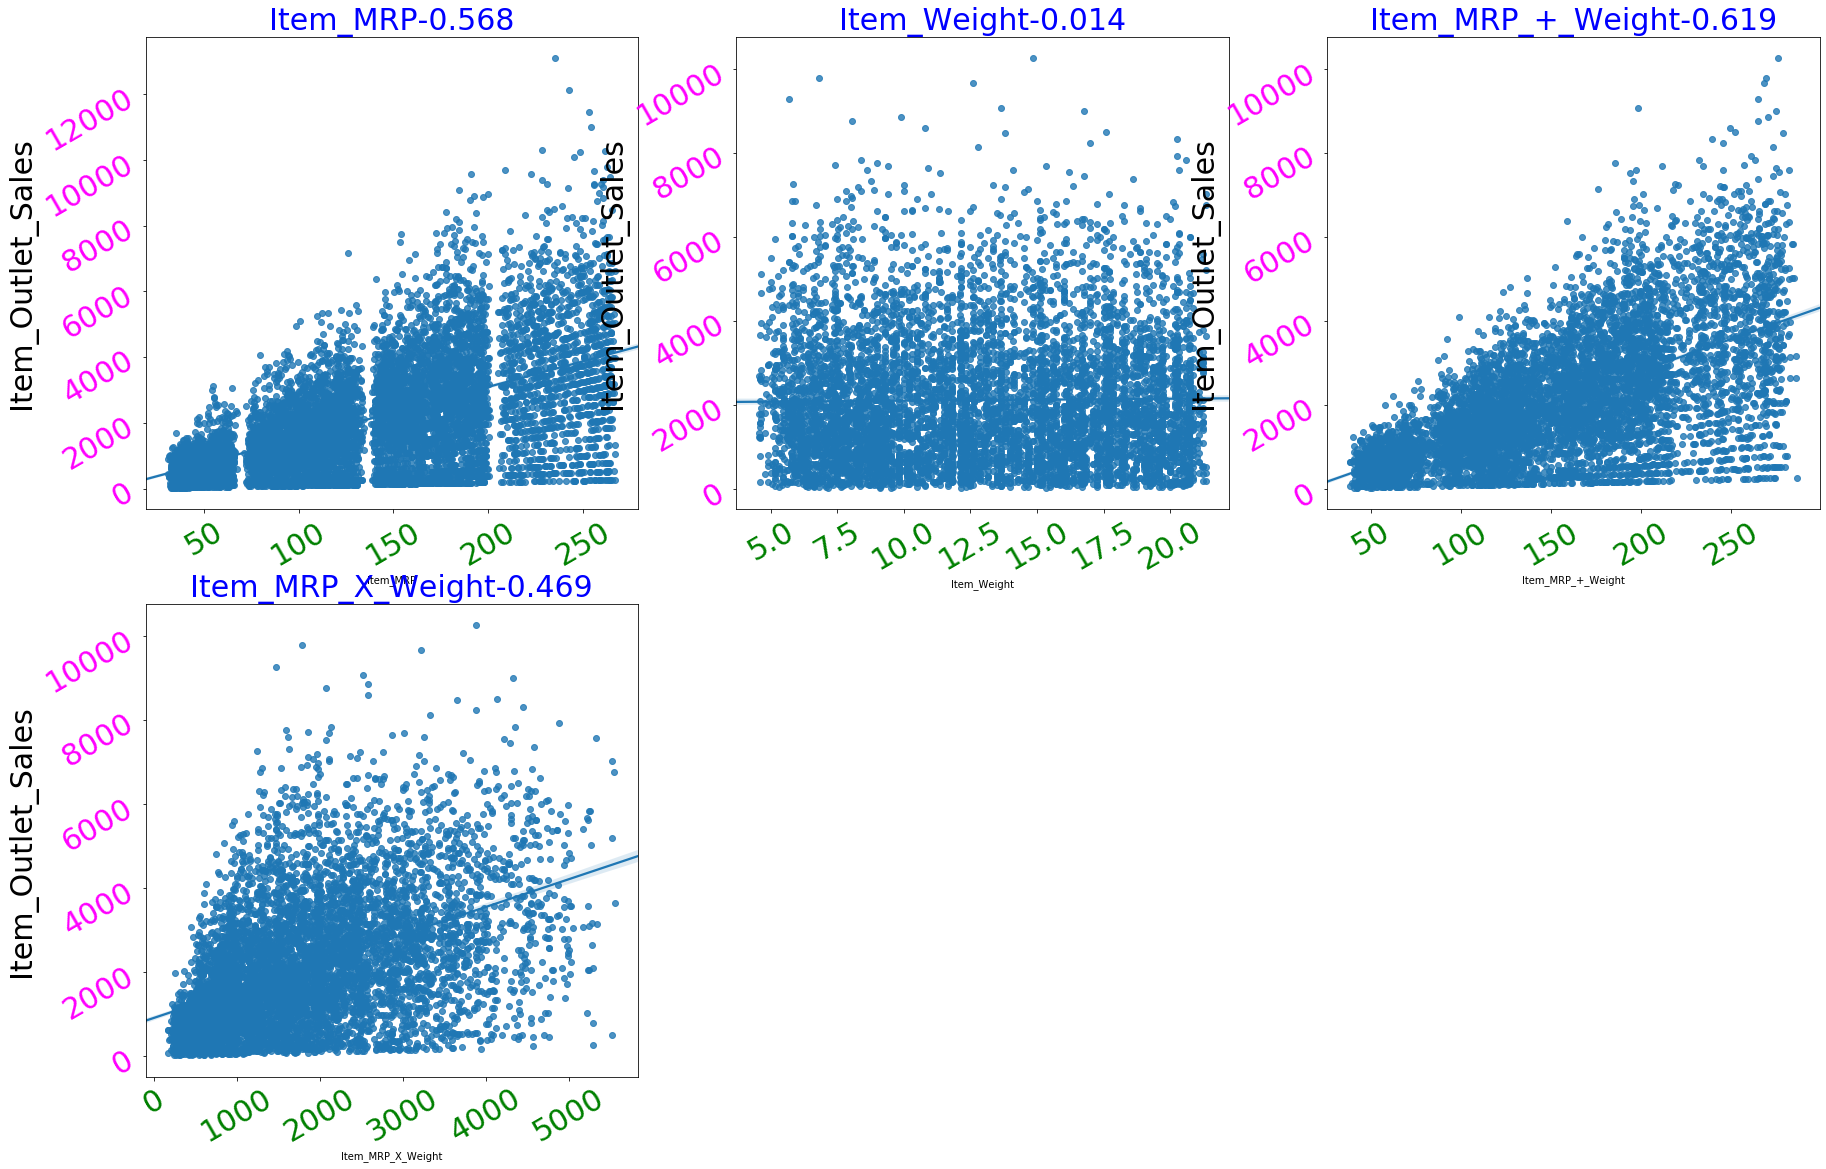

In [54]:
BiVEDA.BiVEDA_conti_cols_regplot_over_yConti(df.columns[1:],label_col, df)
#BiVEDA.All_VEDA_conti_higly_correlation_cols_pairplot_scatterplot(df.columns[1:],label_col, df)

In [55]:
PPM.desc1(train_test,1,label_col)

dtypes  null_count  total count  unique_count  \
Item_Outlet_Sales          float64      5681.0       8523.0        3493.0   
Item_MRP                   float64         0.0      14204.0        8052.0   
Item_Visibility            float64         0.0      14204.0       13384.0   
Outlet_Size                  int64         0.0      14204.0           3.0   
Outlet_Establishment_Year    int64         0.0      14204.0           9.0   
Item_Fat_Content             int64         0.0      14204.0           2.0   
Item_Weight                float64         0.0      14204.0         415.0   
Outlet_Location_Type        object         0.0      14204.0           3.0   
Outlet_Type                 object         0.0      14204.0           4.0   
Outlet_Identifier           object         0.0      14204.0          10.0   
Item_Type                   object         0.0      14204.0          16.0   
Item_Identifier             object         0.0      14204.0        1559.0   

                           missing value ratio  variance of numerics      std  \
Item_Outlet_Sales                         40.0            2912140.00  1706.50   
Item_MRP                                   0.0               3854.79    62.09   
Item_Visibility                            0.0                  0.00     0.05   
Outlet_Size                                0.0                  0.46     0.68   
Outlet_Establishment_Year                  0.0                 70.08     8.37   
Item_Fat_Content                           0.0                  0.23     0.48   
Item_Weight                                0.0                 21.64     4.65   
Outlet_Location_Type                       0.0                  0.00     0.00   
Outlet_Type                                0.0                  0.00     0.00   
Outlet_Identifier                          0.0                  0.00     0.00   
Item_Type                                  0.0                  0.00     0.00   
Item_Identifier                            0.0                  0.00     0.00   

                              mean       min       max   skew   kurt  \
Item_Outlet_Sales          2181.29    33.290  13087.00  1.178  1.616   
Item_MRP                    141.00    31.290    266.89  0.131 -0.894   
Item_Visibility               0.07     0.000      0.32  0.978  0.910   
Outlet_Size                   1.61     1.000      3.00  0.655 -0.670   
Outlet_Establishment_Year  1997.83  1985.000   2009.00 -0.396 -1.206   
Item_Fat_Content              1.35     1.000      2.00  0.614 -1.624   
Item_Weight                  12.79     4.555     21.35  0.100 -1.227   
Outlet_Location_Type          0.00     0.000      0.00  0.000  0.000   
Outlet_Type                   0.00     0.000      0.00  0.000  0.000   
Outlet_Identifier             0.00     0.000      0.00  0.000  0.000   
Item_Type                     0.00     0.000      0.00  0.000  0.000   
Item_Identifier               0.00     0.000      0.00  0.000  0.000   

                           Numeric pearSonCorr withTarget  
Item_Outlet_Sales                                1.000000  
Item_MRP                                         0.567574  
Item_Visibility                                  0.099271  
Outlet_Size                                      0.060517  
Outlet_Establishment_Year                        0.049135  
Item_Fat_Content                                 0.018719  
Item_Weight                                      0.013261  
Outlet_Location_Type                             0.000000  
Outlet_Type                                      0.000000  
Outlet_Identifier                                0.000000  
Item_Type                                        0.000000  
Item_Identifier                                  0.000000

In [50]:
train_test['Outlet_Age']= train_test['Outlet_Establishment_Year'] - (train_test['Outlet_Establishment_Year'].min()-1)

Plot where conti_column scatter  Over Item_Outlet_Sales
cat column list= ['Outlet_Age', 'Outlet_Establishment_Year']
 Bar char for Categorial Columns 
['Outlet_Age', 'Outlet_Establishment_Year']


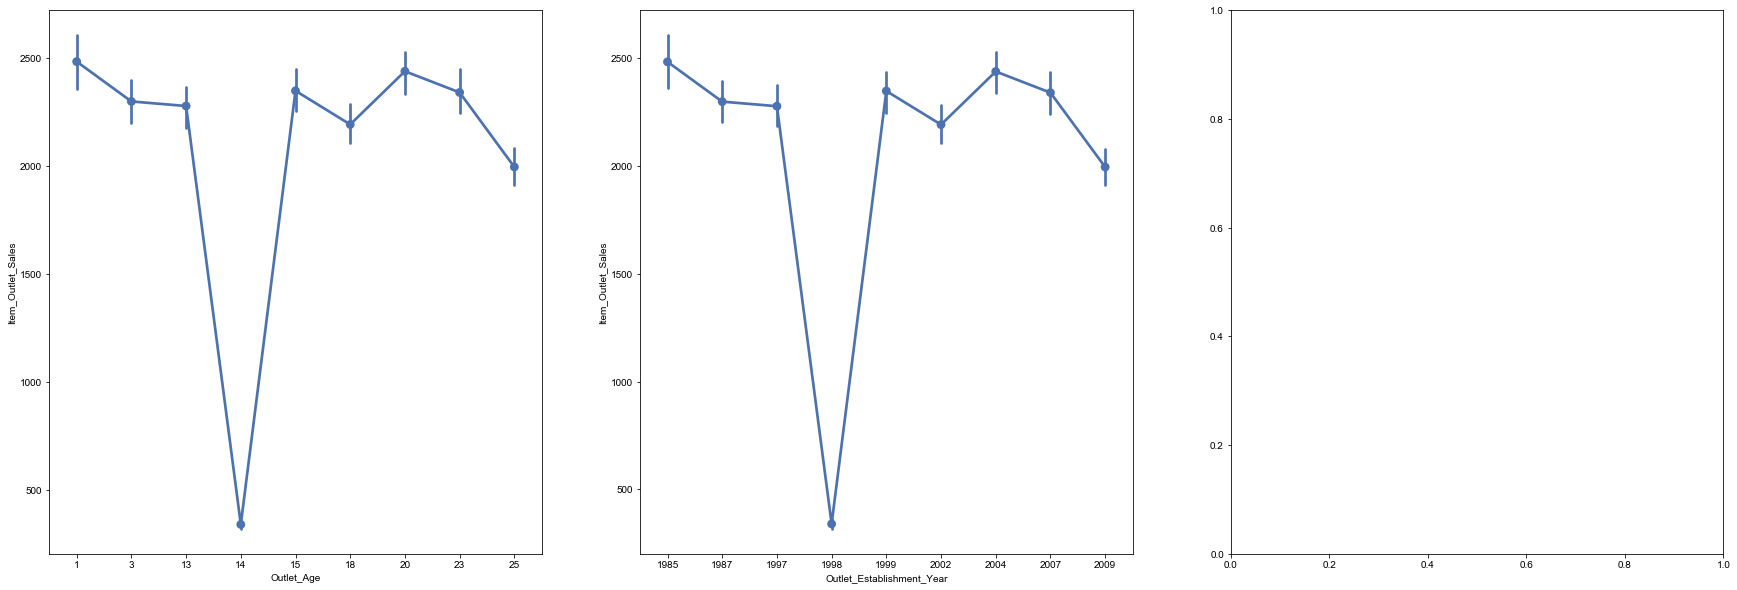

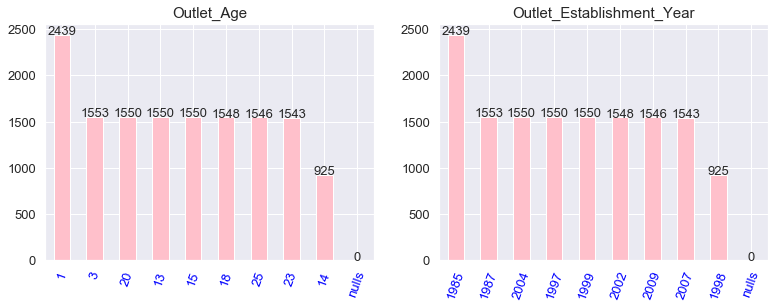

In [57]:
BiVEDA.BiVEDA_cat_cols_SNS_FACTOR_LINE_over_yConti(['Outlet_Age','Outlet_Establishment_Year'],label_col,train_test)
catUniVEDA.UniVEDA_cat_cols_BAR(['Outlet_Age','Outlet_Establishment_Year'],train_test)

In [58]:
#BiVEDA.BiVEDA_cat_cols_SNS_FACTOR_LINE_over_yConti(['Outlet_Age','Outlet_Establishment_Year'],'Item_MRP',train_test)

In [59]:
PPM.desc1(train_test,1,label_col).T

Item_Outlet_Sales  Item_MRP Item_Visibility  \
dtypes                                   float64   float64         float64   
null_count                                  5681         0               0   
total count                                 8523     14204           14204   
unique_count                                3493      8052           13384   
missing value ratio                           40         0               0   
variance of numerics                 2.91214e+06   3854.79               0   
std                                       1706.5     62.09            0.05   
mean                                     2181.29       141            0.07   
min                                        33.29     31.29               0   
max                                        13087    266.89            0.32   
skew                                       1.178     0.131           0.978   
kurt                                       1.616    -0.894            0.91   
Numeric pearSonCorr withTarget                 1  0.567574       0.0992709   

                               Outlet_Size Outlet_Establishment_Year  \
dtypes                               int64                     int64   
null_count                               0                         0   
total count                          14204                     14204   
unique_count                             3                         9   
missing value ratio                      0                         0   
variance of numerics                  0.46                     70.08   
std                                   0.68                      8.37   
mean                                  1.61                   1997.83   
min                                      1                      1985   
max                                      3                      2009   
skew                                 0.655                    -0.396   
kurt                                 -0.67                    -1.206   
Numeric pearSonCorr withTarget   0.0605168                  0.049135   

                               Outlet_Age Item_Fat_Content Item_Weight  \
dtypes                              int64            int64     float64   
null_count                              0                0           0   
total count                         14204            14204       14204   
unique_count                            9                2         415   
missing value ratio                     0                0           0   
variance of numerics                70.08             0.23       21.64   
std                                  8.37             0.48        4.65   
mean                                13.83             1.35       12.79   
min                                     1                1       4.555   
max                                    25                2       21.35   
skew                               -0.396            0.614         0.1   
kurt                               -1.206           -1.624      -1.227   
Numeric pearSonCorr withTarget   0.049135        0.0187185   0.0132612   

                               Outlet_Location_Type Outlet_Type  \
dtypes                                       object      object   
null_count                                        0           0   
total count                                   14204       14204   
unique_count                                      3           4   
missing value ratio                               0           0   
variance of numerics                              0           0   
std                                               0           0   
mean                                              0           0   
min                                               0           0   
max                                               0           0   
skew                                              0           0   
kurt                                              0           0   
Numeric pearSonCorr w

In [89]:
item_col=[label_col,'Item_Fat_Content','Item_Weight']
df=train_test[item_col]

In [90]:
df['Fat_Con_+_Weight']=train_test['Item_Fat_Content']+train_test['Item_Weight']
df['Fat_Con_X_Weight']=train_test['Item_Fat_Content']*train_test['Item_Weight']

TypeError: can only concatenate str (not "float") to str

 Its a kind of scatter plot 
Index(['Item_Fat_Content', 'Item_Weight', 'Fat_Con_+_Weight',
       'Fat_Con_X_Weight'],
      dtype='object')


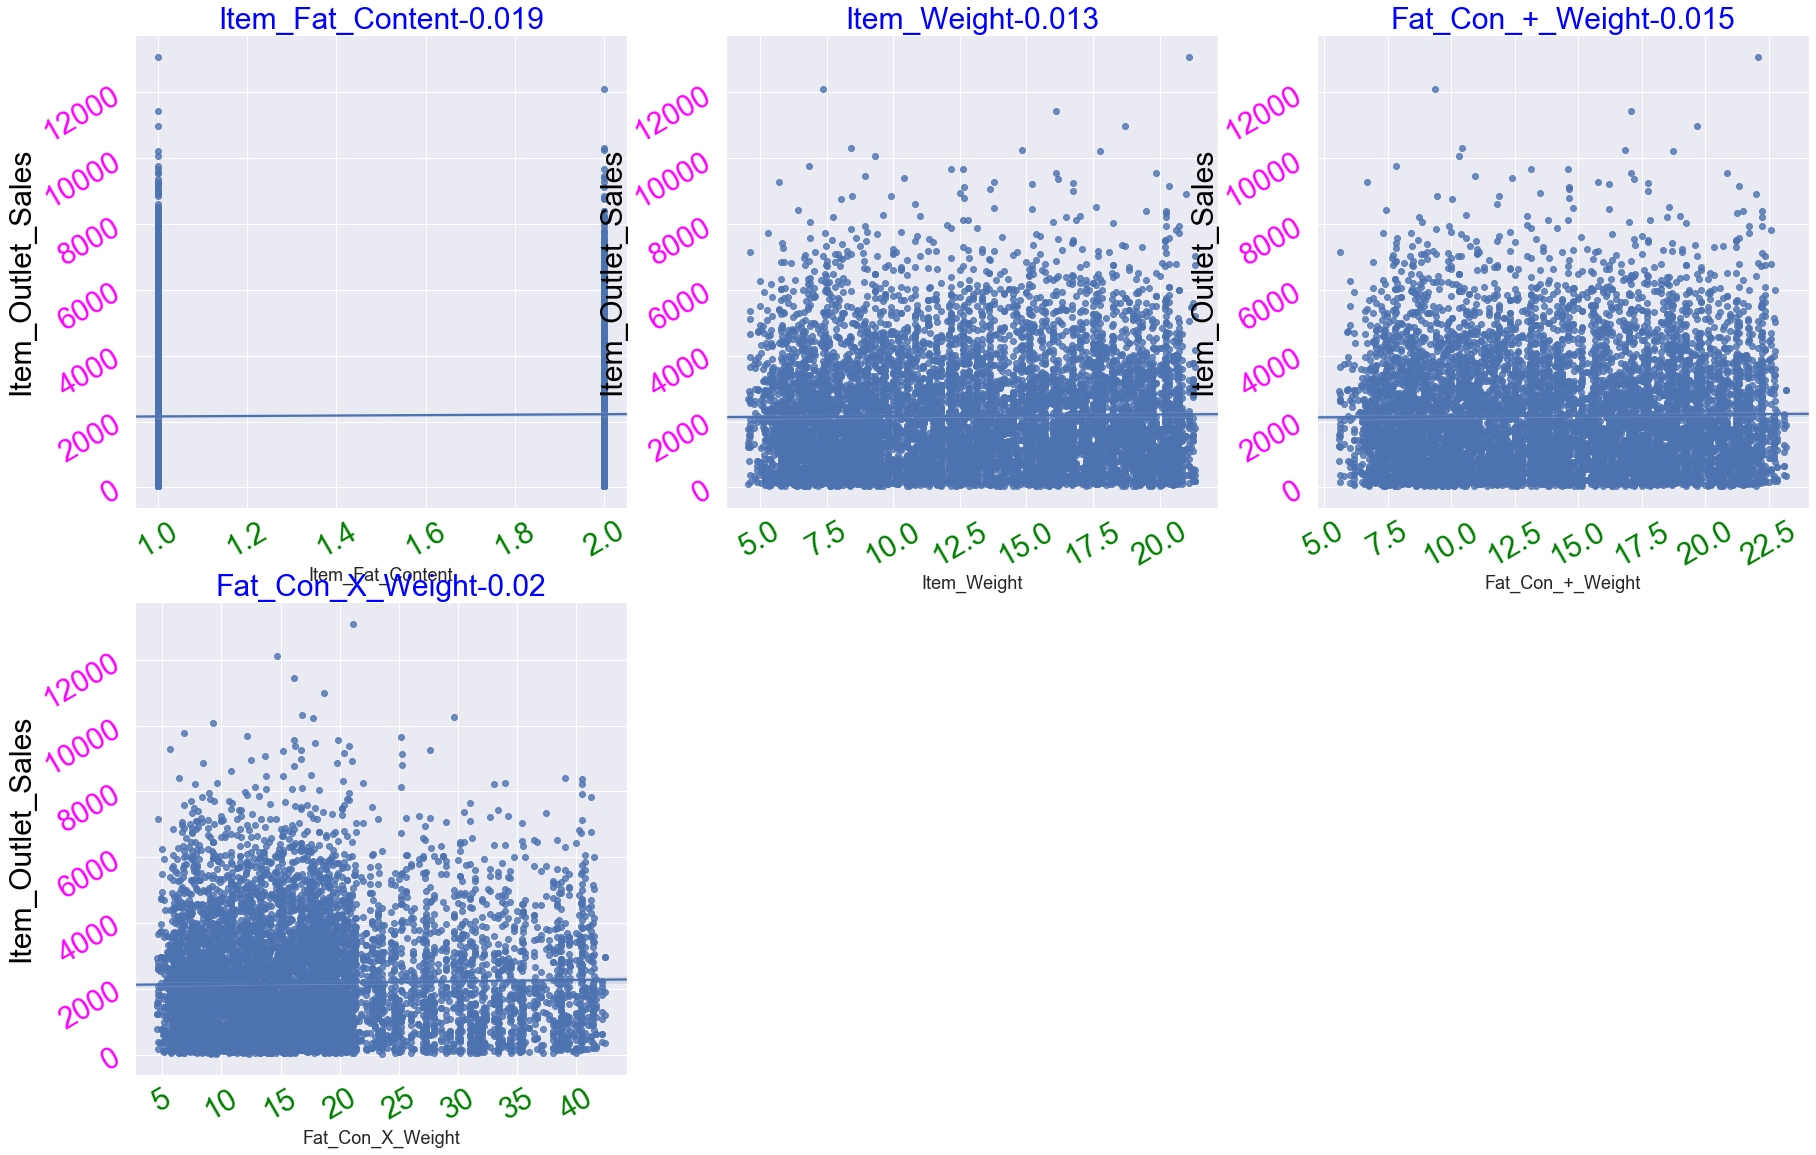

In [62]:
BiVEDA.BiVEDA_conti_cols_regplot_over_yConti(df.columns[1:],label_col, df)

In [53]:
train['Item_Category'] = train['Item_Identifier'].apply(lambda x: x[0:2]).map({'FD':'Food',
                                                              'NC':'Non-Consumable',
                                                              'DR':'Drinks'})
test['Item_Category'] = test['Item_Identifier'].apply(lambda x: x[0:2]).map({'FD':'Food',
                                                              'NC':'Non-Consumable',
                                                              'DR':'Drinks'})
train_test['Item_Category'] = train_test['Item_Identifier'].apply(lambda x: x[0:2]).map({'FD':'Food',
                                                              'NC':'Non-Consumable',
                                                              'DR':'Drinks'})

In [54]:
PPM.desc1(train_test,1,label_col)

NameError: name 'PPM' is not defined

In [65]:
#train_test.drop(['totalPoints','totolPoints'],1,inplace=True)

In [80]:
Outlet_cols=[label_col,'Item_MRP','Item_Visibility','Item_Weight']
df=train_test[:ntrain][Outlet_cols]
df['Total_Points']=df['Item_MRP']*df['Item_Visibility']*df['Item_Weight']


 Its a kind of scatter plot 
Index(['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Total_Points'], dtype='object')


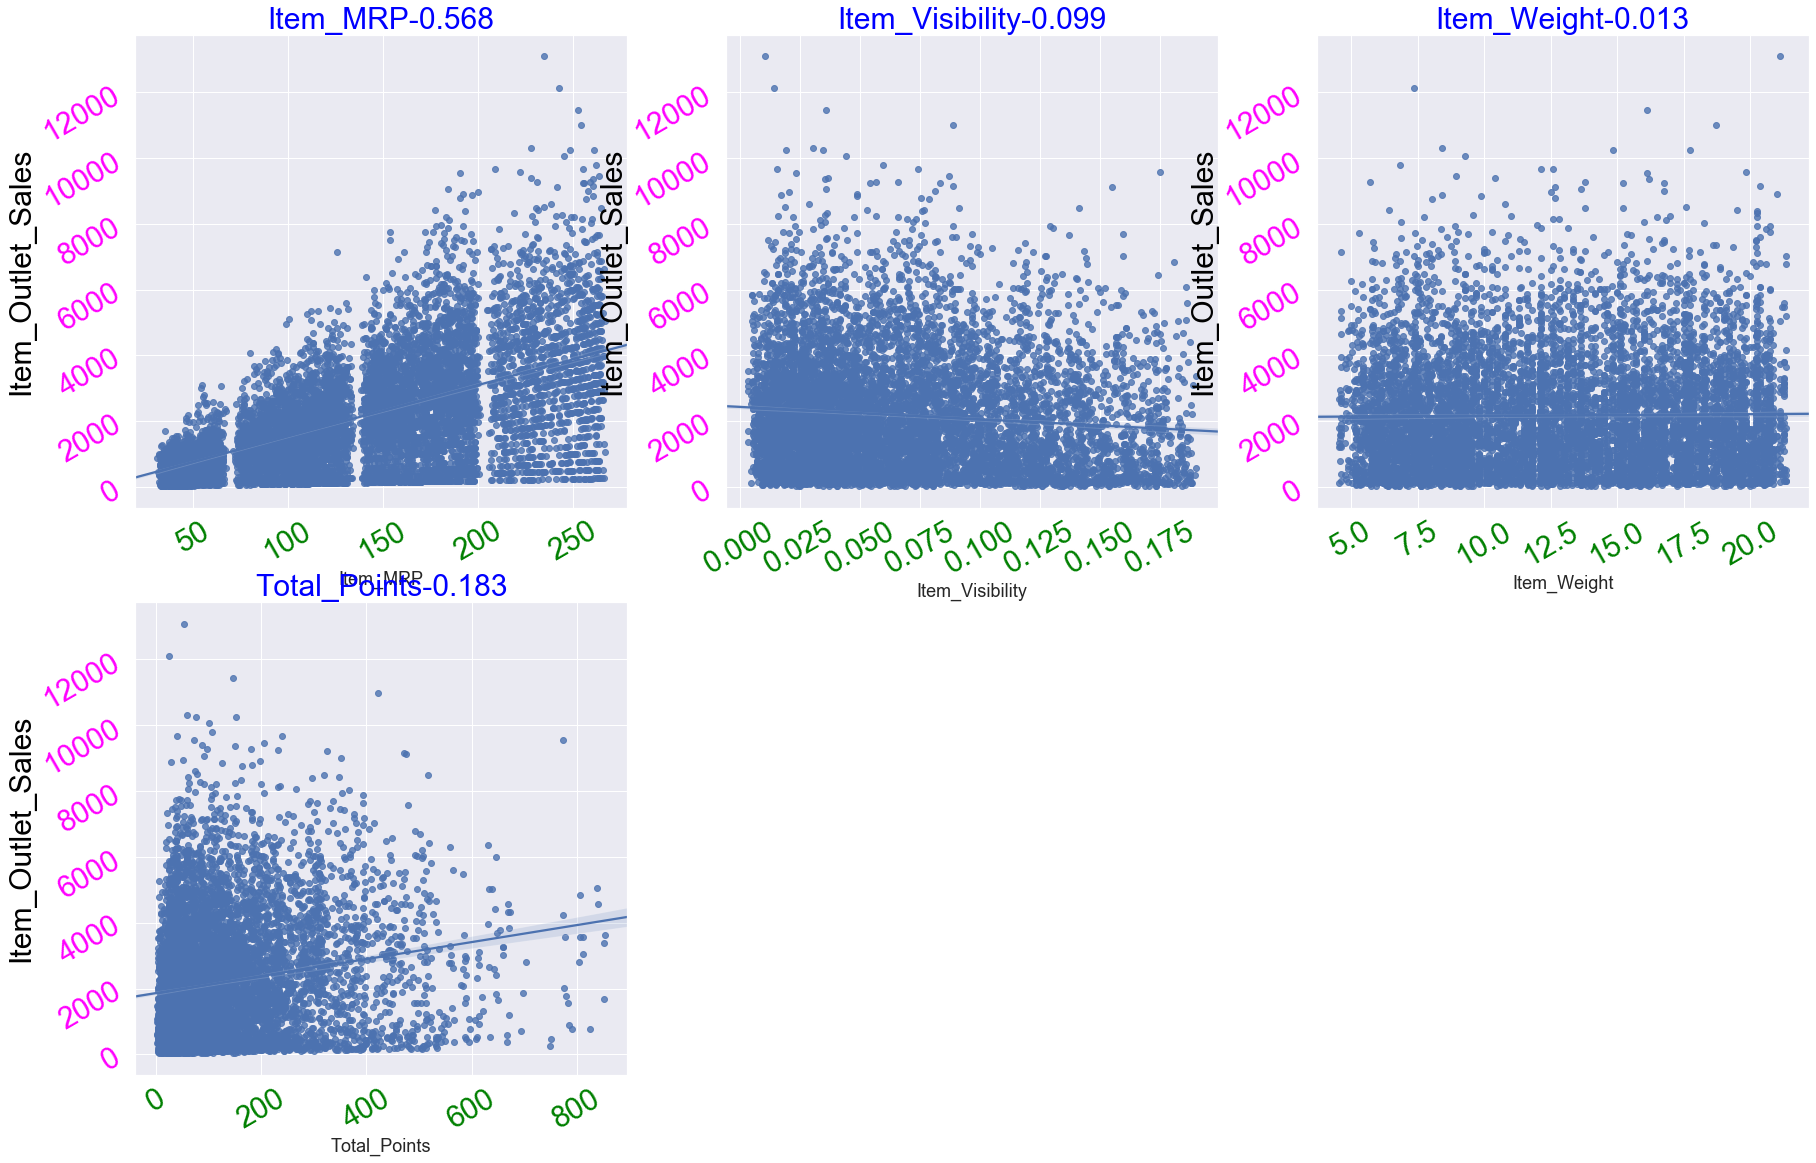

In [67]:
BiVEDA.BiVEDA_conti_cols_regplot_over_yConti(df.columns[1:],label_col, df)

In [56]:
test.groupby('Outlet_Type')['Item_Visibility'].mean()

Outlet_Type
Grocery Store        0.104197
Supermarket Type1    0.059873
Supermarket Type2    0.058417
Supermarket Type3    0.062934
Name: Item_Visibility, dtype: float64

In [57]:
test.groupby('Outlet_Identifier')['Item_Visibility'].mean()

Outlet_Identifier
OUT010    0.102661
OUT013    0.060669
OUT017    0.060790
OUT018    0.058417
OUT019    0.105811
OUT027    0.062934
OUT035    0.060170
OUT045    0.061557
OUT046    0.059764
OUT049    0.056292
Name: Item_Visibility, dtype: float64

In [66]:
#order=train_test.groupby('Outlet_Location_Type')['Item_Visibility'].mean().sort_values(ascending=False).index
#map1=dict([i for i in zip(order,range(1,len(order)+1))]) 

In [67]:
[i for i in zip(order,range(1,len(order)+1))]

[('Tier 1', 1), ('Tier 3', 2), ('Tier 2', 3)]

In [68]:
order=train_test.groupby('Outlet_Location_Type')['Item_Visibility'].mean().sort_values(ascending=False).index
map1=dict([i for i in zip(order,range(1,len(order)+1))]) 
train_test['Outlet_location_type_wiseVisibility']=train_test['Outlet_Location_Type'].apply(lambda x : map1[x])

In [69]:
order=train_test.groupby('Outlet_Identifier')['Item_Visibility'].mean().sort_values(ascending=True).index
map1=dict([i for i in zip(order,range(1,len(order)+1))]) 
train_test['Outlet_Identifier_wiseVisibility']=train_test['Outlet_Identifier'].apply(lambda x : map1[x])

In [70]:
order=train_test.groupby('Outlet_Type')['Item_Visibility'].mean().sort_values(ascending=True).index
map1=dict([i for i in zip(order,range(1,len(order)+1))]) 
train_test['Outlet_Type_wiseVisibility']=train_test['Outlet_Type'].apply(lambda x : map1[x])

In [71]:
order=train.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].mean().sort_values(ascending=True).index
map1=dict([i for i in zip(order,range(1,len(order)+1))])
train_test['Outlet_Ranking']=train_test['Outlet_Identifier'].apply(lambda x : map1[x])

In [72]:
order=train.groupby(['Outlet_Identifier'])['Item_Identifier'].count().sort_values(ascending=True).index
map1=dict([i for i in zip(order,range(2,len(order)+2))])
train_test['Outlet_size_ordering']=train_test['Outlet_Identifier'].apply(lambda x : map1[x])

In [73]:
PPM.desc1(train_test,2,label_col)

NameError: name 'PPM' is not defined

In [74]:
train_test['Total_Points']=train_test['Item_MRP']*train_test['Item_Visibility']*train_test['Item_Weight']
train_test['Item_MRP_+_Weight']=train_test['Item_MRP'] + train_test['Item_Weight']
train_test['Item_MRP_+_Visi']=train_test['Item_MRP'] + train_test['Item_Visibility']

In [75]:
train_test['MrpPerUnit']=train_test['Item_MRP']/train_test['Outlet_Size']

In [78]:
summydf=PPM.desc1(train_test[:ntrain],1,label_col)
cols_ordinal=summydf[summydf['dtypes']=='int64'].index
cols_ordinal=cols_ordinal.drop(['Outlet_Establishment_Year','Outlet_Age'])
df=train_test[:ntrain][list(cols_ordinal)+[label_col]]
df['Sum_of_ordinals']=df[cols_ordinal].sum(1)*df['Outlet_Ranking']
#df['product_of_ordinals']= df[cols_ordinal].sum(1)
PPM.desc1(df[:ntrain],1,label_col)

dtypes  null_count  total count  \
Item_Outlet_Sales                    float64         0.0       8523.0   
Outlet_Ranking                         int64         0.0       8523.0   
Sum_of_ordinals                        int64         0.0       8523.0   
Outlet_size_ordering                   int64         0.0       8523.0   
Outlet_Type_wiseVisibility             int64         0.0       8523.0   
Outlet_Identifier_wiseVisibility       int64         0.0       8523.0   
Outlet_location_type_wiseVisibility    int64         0.0       8523.0   
Outlet_Size                            int64         0.0       8523.0   
Item_Fat_Content                       int64         0.0       8523.0   

                                     unique_count  missing value ratio  \
Item_Outlet_Sales                          3493.0                  0.0   
Outlet_Ranking                               10.0                  0.0   
Sum_of_ordinals                              20.0                  0.0   
Outlet_size_ordering                         10.0                  0.0   
Outlet_Type_wiseVisibility                    4.0                  0.0   
Outlet_Identifier_wiseVisibility             10.0                  0.0   
Outlet_location_type_wiseVisibility           3.0                  0.0   
Outlet_Size                                   3.0                  0.0   
Item_Fat_Content                              2.0                  0.0   

                                     variance of numerics      std     mean  \
Item_Outlet_Sales                              2912140.00  1706.50  2181.29   
Outlet_Ranking                                       7.41     2.72     5.87   
Sum_of_ordinals                                   8368.23    91.48   160.19   
Outlet_size_ordering                                 7.38     2.72     6.87   
Outlet_Type_wiseVisibility                           0.63     0.80     2.80   
Outlet_Identifier_wiseVisibility                     7.37     2.71     5.13   
Outlet_location_type_wiseVisibility                  0.60     0.78     2.05   
Outlet_Size                                          0.46     0.68     1.61   
Item_Fat_Content                                     0.23     0.48     1.35   

                                       min      max   skew   kurt  \
Item_Outlet_Sales                    33.29  13087.0  1.178  1.616   
Outlet_Ranking                        1.00     10.0 -0.104 -1.104   
Sum_of_ordinals                      22.00    330.0  0.220 -0.925   
Outlet_size_ordering                  2.00     11.0 -0.101 -1.108   
Outlet_Type_wiseVisibility            1.00      4.0 -0.927  0.634   
Outlet_Identifier_wiseVisibility      1.00     10.0  0.100 -1.106   
Outlet_location_type_wiseVisibility   1.00      3.0 -0.081 -1.343   
Outlet_Size                           1.00      3.0  0.655 -0.670   
Item_Fat_Content                      1.00      2.0  0.617 -1.620   

                                     Numeric pearSonCorr withTarget  
Item_Outlet_Sales                                          1.000000  
Outlet_Ranking                                             0.410268  
Sum_of_ordinals                                            0.405731  
Outlet_size_ordering                                       0.385397  
Outlet_Type_wiseVisibility                                 0.264969  
Outlet_Identifier_wiseVisibility                           0.256688  
Outlet_location_type_wiseVisibility                        0.099404  
Outlet_Size                                                0.060517  
Item_Fat_Content                                           0.018719

In [76]:
train_test['Sum_of_ordinals']=train_test[cols_ordinal].sum(1)*train_test['Outlet_Ranking']

NameError: name 'cols_ordinal' is not defined

In [81]:
ItemAvgMRPmap=dict(train_test.groupby(['Item_Identifier'])['Item_MRP'].mean())

In [82]:
train_test['ItemAvgMRPmap']=train_test['Item_Identifier'].apply(lambda x:ItemAvgMRPmap[x] )/train_test['Item_Weight']

In [83]:
train_test[label_col].corr(train_test['Total_Points']*train_test['MrpPerUnit'],'spearman').round(5)#.var() #.drop_duplicates().dropna().sort_values(['Item_Type','Item_MRP'])

0.34394

In [83]:
PPM.desc1(train_test,2,'Item_MRP')[6:]

dtypes  null_count  total count  \
Total_Points                         float64         0.0      14204.0   
Item_Type                             object         0.0      14204.0   
Item_Weight                          float64         0.0      14204.0   
Item_Category                         object         0.0      14204.0   
Item_Identifier                       object         0.0      14204.0   
Item_Fat_Content                       int64         0.0      14204.0   
Item_Visibility                      float64         0.0      14204.0   
Outlet_Size                            int64         0.0      14204.0   
Outlet_Location_Type                  object         0.0      14204.0   
Outlet_Identifier_wiseVisibility       int64         0.0      14204.0   
Outlet_Identifier                     object         0.0      14204.0   
Outlet_Ranking                         int64         0.0      14204.0   
Outlet_size_ordering                   int64         0.0      14204.0   
Sum_of_ordinals                        int64         0.0      14204.0   
Outlet_Establishment_Year              int64         0.0      14204.0   
Outlet_Age                             int64         0.0      14204.0   
Outlet_Type_wiseVisibility             int64         0.0      14204.0   
Outlet_Type                           object         0.0      14204.0   
Outlet_location_type_wiseVisibility    int64         0.0      14204.0   

                                     unique_count  missing value ratio  \
Total_Points                              13850.0                  0.0   
Item_Type                                    16.0                  0.0   
Item_Weight                                 415.0                  0.0   
Item_Category                                 3.0                  0.0   
Item_Identifier                            1559.0                  0.0   
Item_Fat_Content                              2.0                  0.0   
Item_Visibility                           13384.0                  0.0   
Outlet_Size                                   3.0                  0.0   
Outlet_Location_Type                          3.0                  0.0   
Outlet_Identifier_wiseVisibility             10.0                  0.0   
Outlet_Identifier                            10.0                  0.0   
Outlet_Ranking                               10.0                  0.0   
Outlet_size_ordering                         10.0                  0.0   
Sum_of_ordinals                              20.0                  0.0   
Outlet_Establishment_Year                     9.0                  0.0   
Outlet_Age                                    9.0                  0.0   
Outlet_Type_wiseVisibility                    4.0                  0.0   
Outlet_Type                                   4.0                  0.0   
Outlet_location_type_wiseVisibility           3.0                  0.0   

                                     variance of numerics     std     mean  \
Total_Points                                     15339.40  123.85   121.27   
Item_Type                                            0.00    0.00     0.00   
Item_Weight                                         21.64    4.65    12.79   
Item_Category                                        0.00    0.00     0.00   
Item_Identifier                                      0.00    0.00     0.00   
Item_Fat_Content                                     0.23    0.48     1.35   
Item_Visibility                                      0.00    0.05     0.07   
Outlet_Size                                          0.46    0.68     1.61   
Outlet_Location_Type                                 0.00    0.00     0.00   
Outlet_Identifier_wiseVisibility                     7.37    2.71     5.13   
Outlet_Identifier                                    0.00    0.00     0.00   
Outlet_Ranking                                       7.41    2.72     5.87   
Outlet_size_ordering                                 7.38    2.72     6.87   
Sum_

In [84]:
PPM.desc1(train_test,2,label_col)

dtypes  null_count  total count  \
Item_Outlet_Sales                    float64      5681.0       8523.0   
Item_MRP                             float64         0.0      14204.0   
Item_MRP_+_Visi                      float64         0.0      14204.0   
Item_MRP_+_Weight                    float64         0.0      14204.0   
Outlet_Ranking                         int64         0.0      14204.0   
Sum_of_ordinals                        int64         0.0      14204.0   
Outlet_Type                           object         0.0      14204.0   
ItemAvgMRPmap                        float64         0.0      14204.0   
Outlet_size_ordering                   int64         0.0      14204.0   
Outlet_Type_wiseVisibility             int64         0.0      14204.0   
MrpPerUnit                           float64         0.0      14204.0   
Outlet_Identifier_wiseVisibility       int64         0.0      14204.0   
Total_Points                         float64         0.0      14204.0   
Outlet_Identifier                     object         0.0      14204.0   
Outlet_location_type_wiseVisibility    int64         0.0      14204.0   
Item_Visibility                      float64         0.0      14204.0   
Outlet_Location_Type                  object         0.0      14204.0   
Outlet_Size                            int64         0.0      14204.0   
Outlet_Establishment_Year              int64         0.0      14204.0   
Outlet_Age                             int64         0.0      14204.0   
Item_Type                             object         0.0      14204.0   
Item_Fat_Content                       int64         0.0      14204.0   
Item_Category                         object         0.0      14204.0   
Item_Weight                          float64         0.0      14204.0   
Item_Identifier                       object         0.0      14204.0   

                                     unique_count  missing value ratio  \
Item_Outlet_Sales                          3493.0                 40.0   
Item_MRP                                   8052.0                  0.0   
Item_MRP_+_Visi                           14199.0                  0.0   
Item_MRP_+_Weight                         12441.0                  0.0   
Outlet_Ranking                               10.0                  0.0   
Sum_of_ordinals                              20.0                  0.0   
Outlet_Type                                   4.0                  0.0   
ItemAvgMRPmap                              1559.0                  0.0   
Outlet_size_ordering                         10.0                  0.0   
Outlet_Type_wiseVisibility                    4.0                  0.0   
MrpPerUnit                                10678.0                  0.0   
Outlet_Identifier_wiseVisibility             10.0                  0.0   
Total_Points                              13850.0                  0.0   
Outlet_Identifier                            10.0                  0.0   
Outlet_location_type_wiseVisibility           3.0                  0.0   
Item_Visibility                           13384.0                  0.0   
Outlet_Location_Type                          3.0                  0.0   
Outlet_Size                                   3.0                  0.0   
Outlet_Establishment_Year                     9.0                  0.0   
Outlet_Age                                    9.0                  0.0   
Item_Type                                    16.0                  0.0   
Item_Fat_Content                              2.0                  0.0   
Item_Category                                 3.0                  0.0   
Item_Weight                                 415.0                  0.0   
Item_Identifier                            1559.0                  0.0   

                                     variance of numerics      std     mean  \
Item_Outlet_Sales                              2912140.00  1706.50  2181.29   
Item_MRP                                          3854.7

# Dummyfication

In [84]:
data=train_test.copy()

In [85]:
data.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],1,inplace=True)

In [86]:
summy=PPM.desc1(data,2,label_col)
cat_cols=summy[summy['dtypes']=='object'].index

NameError: name 'PPM' is not defined

In [87]:
print(data.shape)
data[cat_cols]
dummiedDF=pd.get_dummies(data[cat_cols],cat_cols)
data[dummiedDF.columns]=dummiedDF
data.drop(cat_cols,1,inplace=True)
data.shape

(14204, 21)


NameError: name 'cat_cols' is not defined

In [89]:
#dummiedDF
ntrain

8523

# Zero test for train and test data drop lowest variablity data

In [90]:
# Lets drop all the columns in entire data where testing data columns holding single value
zerotest_testing_col=[]
for i in dummiedDF.columns:
    if i in data.columns:
        zerotest_cond=data[i][ntrain:].sum()==0
        if zerotest_cond:
            zerotest_testing_col.append(i)
print(len(zerotest_testing_col),"-",zerotest_testing_col)
if len(zerotest_testing_col) > 0:
   data.drop(zerotest_testing_col,1,inplace=True)
data.shape

0 - []


(14204, 44)

In [91]:
# Lets drop all the columns in entire data where training data columns holding single value
zerotest_training_col=[]
for i in dummiedDF.columns:
    if i in data.columns:
        zerotest_cond=data[i][:ntrain].sum()==0
        if zerotest_cond:
            zerotest_training_col.append(i)
print(len(zerotest_training_col),"-",zerotest_training_col)
if len(zerotest_training_col) > 0:
   data.drop(zerotest_training_col,1,inplace=True)
data.shape

0 - []


(14204, 44)

In [92]:
def max_corrs(label_col,_df,threashold=0.3):

    # Lets create corr dataframe for correlated columns having correaltion > threashold
    corr = _df[_df[label_col]>0].corr()
    top_corr_cols = corr[abs((corr[label_col])>=threashold)][label_col].sort_values(ascending=False).keys()
    _corrDF = corr.loc[top_corr_cols, top_corr_cols]
    dropSelf = np.zeros_like(_corrDF)
    dropSelf[np.triu_indices_from(dropSelf)] = True
    print(_corrDF.shape)
    del top_corr_cols

    """

        To return the best valued corrected columns

        """
    #drop the first columns containing the correlation with label col
    top_corrs_colsN=_corrDF[1:].drop(label_col,1)
    
    #extract the list of columns of correlated DF
    colist=list(top_corrs_colsN.columns)
    #print(colist)
    
    # Create Empy DataFrame To fill using for loop below
    Multi_col_list=pd.DataFrame(columns=['col1','col2','col1_vs_col2-corr','col1_vs_label-corr','col2_vs_label-corr'])
    for i in range(0,len(top_corrs_colsN.index)):
        
        # 1.extract given row[i] of the forloop & round off all corrs upto 3 decimal place
        # 
        corRec=list(top_corrs_colsN.ix[i].round(3))
        #print(colist)

        colist1=colist.copy()
        
        # 2. Name and corr value of the src column
        src_corVal=corRec[i]
        src_colName=colist[i]
        colist1=colist1.copy()
        
        # 3. remove the srce column from the list
        colist1.pop(i)
        corRec.pop(i)
        
        #print(corRec)
        #print(src_colName,src_corVal,colist1,"\n\n")

        # 4. Extract the max value the given list(row) of the for loop
        mx=np.max(corRec).round(3)
        mx_loc=0
        
        # find the location of the max value
        for loc in range(0,len(corRec)):
            if corRec[loc] == mx:
                mx_loc=loc
                break
        #print(src_colName,mx,mx_loc,colist1[mx_loc],corRec)
        #print("corr(",src_colName,",",colist1[mx_loc],")-",mx)
        #print(src_colName,colist1[mx_loc])
        
        # finding the correlation of i) src column and ii) its best correlation column with the label column
        col2_vs_label=abs(_df[[label_col,colist1[mx_loc] ]].corr().head(1).values[0][1].round(3))
        col1_vs_label=abs(_df[[label_col,src_colName ]].corr().head(1).values[0][1].round(3))

        cond=[]
        cond=Multi_col_list[(Multi_col_list['col1']==colist1[mx_loc]) & (Multi_col_list['col2']==src_colName)]
        if(len(cond))>0:
    #        #print(i)
            pass
        else:
            Multi_col_list.loc[i]=[src_colName,colist1[mx_loc],mx,col1_vs_label,col2_vs_label]
    del top_corrs_colsN     
    return Multi_col_list.sort_values(['col1_vs_label-corr','col2_vs_label-corr'],ascending=[False,False])

corr = data[:ntrain].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.515:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
print(set(data.columns).difference(set(selected_columns)))
max_corrs(label_col,data[:ntrain],0.001)


{'Outlet_Location_Type_Tier 2', 'Item_Outlet_Sales', 'MrpPerUnit', 'Total_Points', 'Item_MRP_+_Visi', 'Item_Category_Non-Consumable', 'Outlet_Type_wiseVisibility', 'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type3', 'Sum_of_ordinals', 'Item_MRP_+_Weight', 'Outlet_size_ordering', 'ItemAvgMRPmap', 'Outlet_Location_Type_Tier 3', 'Item_Category_Drinks'}
(27, 27)


col1                         col2  \
0                              Item_MRP              Item_MRP_+_Visi   
2                     Item_MRP_+_Weight                     Item_MRP   
3                        Outlet_Ranking              Sum_of_ordinals   
5                  Outlet_size_ordering               Outlet_Ranking   
6                         ItemAvgMRPmap                     Item_MRP   
7                            MrpPerUnit                     Item_MRP   
8         Outlet_Type_Supermarket Type3              Sum_of_ordinals   
9                          Total_Points            Item_MRP_+_Weight   
10        Outlet_Type_Supermarket Type1  Outlet_Location_Type_Tier 2   
11  Outlet_location_type_wiseVisibility  Outlet_Location_Type_Tier 2   
12                          Outlet_Size  Outlet_Location_Type_Tier 3   
15                   Item_Category_Food             Item_Fat_Content   
16      Item_Type_Fruits and Vegetables           Item_Category_Food   
17                Item_Type_Snack Foods           Item_Category_Food   
19                  Item_Type_Household            Item_MRP_+_Weight   
20              Item_Type_Starchy Foods           Item_Category_Food   
21                          Item_Weight                 Total_Points   
22                      Item_Type_Dairy                 Total_Points   
23                     Item_Type_Canned           Item_Category_Food   
24                    Item_Type_Seafood           Item_Category_Food   
25                     Item_Type_Breads           Item_Category_Food   

    col1_vs_col2-corr  col1_vs_label-corr  col2_vs_label-corr  
0               1.000               0.568               0.568  
2               0.997               0.566               0.568  
3               0.985               0.410               0.406  
5               0.697               0.385               0.410  
6               0.683               0.383               0.568  
7               0.735               0.367               0.568  
8               0.627               0.311               0.406  
9               0.495               0.183               0.566  
10              0.506               0.109               0.058  
11              0.854               0.099               0.058  
12              0.794               0.061               0.046  
15              0.423               0.032               0.019  
16              0.257               0.026               0.032  
17              0.253               0.023               0.032  
19              0.050               0.016               0.566  
20              0.083               0.015               0.032  
21              0.375               0.013               0.183  
22              0.053               0.009               0.183  
23              0.180               0.007               0.032  
24              0.054               0.007               0.032  
25              0.109               0.002               0.032

In [93]:
data.drop(['Item_MRP_+_Visi','Item_MRP_+_Weight','Sum_of_ordinals','Outlet_size_ordering'],1,inplace=True)
max_corrs(label_col,data[:ntrain],0.0001)

(23, 23)


col1                           col2  \
0                              Item_MRP                     MrpPerUnit   
1                        Outlet_Ranking  Outlet_Type_Supermarket Type3   
2                         ItemAvgMRPmap                       Item_MRP   
5                          Total_Points                       Item_MRP   
6         Outlet_Type_Supermarket Type1    Outlet_Location_Type_Tier 2   
7   Outlet_location_type_wiseVisibility    Outlet_Location_Type_Tier 2   
8                           Outlet_Size    Outlet_Location_Type_Tier 3   
11                   Item_Category_Food               Item_Fat_Content   
12      Item_Type_Fruits and Vegetables             Item_Category_Food   
13                Item_Type_Snack Foods             Item_Category_Food   
15                  Item_Type_Household                    Item_Weight   
16              Item_Type_Starchy Foods             Item_Category_Food   
17                          Item_Weight                   Total_Points   
18                      Item_Type_Dairy                   Total_Points   
19                     Item_Type_Canned             Item_Category_Food   
20                    Item_Type_Seafood             Item_Category_Food   
21                     Item_Type_Breads             Item_Category_Food   

    col1_vs_col2-corr  col1_vs_label-corr  col2_vs_label-corr  
0               0.735               0.568               0.367  
1               0.533               0.410               0.311  
2               0.683               0.383               0.568  
5               0.469               0.183               0.568  
6               0.506               0.109               0.058  
7               0.854               0.099               0.058  
8               0.794               0.061               0.046  
11              0.423               0.032               0.019  
12              0.257               0.026               0.032  
13              0.253               0.023               0.032  
15              0.048               0.016               0.013  
16              0.083               0.015               0.032  
17              0.375               0.013               0.183  
18              0.053               0.009               0.183  
19              0.180               0.007               0.032  
20              0.054               0.007               0.032  
21              0.109               0.002               0.032

In [94]:
data.drop(['Outlet_Type_Supermarket Type3','Outlet_Location_Type_Tier 2'],1,inplace=True)
max_corrs(label_col,data[:ntrain],0.0001)

(21, 21)


col1                           col2  \
0                              Item_MRP                     MrpPerUnit   
1                        Outlet_Ranking  Outlet_Type_Supermarket Type1   
2                         ItemAvgMRPmap                       Item_MRP   
4                          Total_Points                       Item_MRP   
6   Outlet_location_type_wiseVisibility  Outlet_Type_Supermarket Type1   
7                           Outlet_Size    Outlet_Location_Type_Tier 3   
9                    Item_Category_Food               Item_Fat_Content   
10      Item_Type_Fruits and Vegetables             Item_Category_Food   
11                Item_Type_Snack Foods             Item_Category_Food   
13                  Item_Type_Household                    Item_Weight   
14              Item_Type_Starchy Foods             Item_Category_Food   
15                          Item_Weight                   Total_Points   
16                      Item_Type_Dairy                   Total_Points   
17                     Item_Type_Canned             Item_Category_Food   
18                    Item_Type_Seafood             Item_Category_Food   
19                     Item_Type_Breads             Item_Category_Food   

    col1_vs_col2-corr  col1_vs_label-corr  col2_vs_label-corr  
0               0.735               0.568               0.367  
1               0.320               0.410               0.109  
2               0.683               0.383               0.568  
4               0.469               0.183               0.568  
6               0.211               0.099               0.109  
7               0.794               0.061               0.046  
9               0.423               0.032               0.019  
10              0.257               0.026               0.032  
11              0.253               0.023               0.032  
13              0.048               0.016               0.013  
14              0.083               0.015               0.032  
15              0.375               0.013               0.183  
16              0.053               0.009               0.183  
17              0.180               0.007               0.032  
18              0.054               0.007               0.032  
19              0.109               0.002               0.032

In [95]:
data.drop(['Outlet_Location_Type_Tier 3'],1,inplace=True)
max_corrs(label_col,data[:ntrain],0.0001)

(20, 20)


col1                           col2  \
0                              Item_MRP                     MrpPerUnit   
1                        Outlet_Ranking  Outlet_Type_Supermarket Type1   
2                         ItemAvgMRPmap                       Item_MRP   
4                          Total_Points                       Item_MRP   
6   Outlet_location_type_wiseVisibility  Outlet_Type_Supermarket Type1   
7                           Outlet_Size                 Outlet_Ranking   
8                    Item_Category_Food               Item_Fat_Content   
9       Item_Type_Fruits and Vegetables             Item_Category_Food   
10                Item_Type_Snack Foods             Item_Category_Food   
12                  Item_Type_Household                    Item_Weight   
13              Item_Type_Starchy Foods             Item_Category_Food   
14                          Item_Weight                   Total_Points   
15                      Item_Type_Dairy                   Total_Points   
16                     Item_Type_Canned             Item_Category_Food   
17                    Item_Type_Seafood             Item_Category_Food   
18                     Item_Type_Breads             Item_Category_Food   

    col1_vs_col2-corr  col1_vs_label-corr  col2_vs_label-corr  
0               0.735               0.568               0.367  
1               0.320               0.410               0.109  
2               0.683               0.383               0.568  
4               0.469               0.183               0.568  
6               0.211               0.099               0.109  
7               0.047               0.061               0.410  
8               0.423               0.032               0.019  
9               0.257               0.026               0.032  
10              0.253               0.023               0.032  
12              0.048               0.016               0.013  
13              0.083               0.015               0.032  
14              0.375               0.013               0.183  
15              0.053               0.009               0.183  
16              0.180               0.007               0.032  
17              0.054               0.007               0.032  
18              0.109               0.002               0.032

In [96]:
#data.groupby(['Item_Weight'])['Item_Weight'].count().sort_values(ascending=False)

# Pair plot ... to understand to distribution,scatter correlation, outliers
    
1. Let’s have a look at the distributions of our features, starting with the most correlated to the target variable
2. Also look at Outliers
3. Recall model Underftting: It usually happens when we have less data to build an accurate model and also when we try to build a linear model with a non-linear data. In such cases the rules of the machine learning model are too easy and flexible to be applied on such a minimal data and therefore the model will probably make a lot of wrong predictions. Underfitting can be avoided by using more data and also reducing the features by feature selection.

    If an algorithm is suffering from high variance:
    
        more data will probably help
        otherwise reduce the model complexity
    If an algorithm is suffering from high bias:

        increase the model complexity

In [97]:
summy=PPM.desc1(train[:ntrain],1,label_col)
summy
high_corr_cols=summy.index[:5]





 Correlated columns Crossing the threashold values(0.2):5 columns 

	[Index(['Item_Outlet_Sales', 'Item_MRP', 'Item_Visibility',
       'Outlet_Establishment_Year', 'Item_Weight'],
      dtype='object')]




Item_Outlet_Sales  Item_MRP  Item_Visibility  \
Item_Outlet_Sales                   1.000000  0.567574        -0.099271   
Item_MRP                            0.567574  1.000000        -0.003893   
Item_Visibility                    -0.099271 -0.003893         1.000000   
Outlet_Establishment_Year          -0.049135  0.005020        -0.050592   
Item_Weight                         0.013261  0.026172        -0.017406   

                           Outlet_Establishment_Year  Item_Weight  
Item_Outlet_Sales                          -0.049135     0.013261  
Item_MRP                                    0.005020     0.026172  
Item_Visibility                            -0.050592    -0.017406  
Outlet_Establishment_Year                   1.000000    -0.012823  
Item_Weight                                -0.012823     1.000000

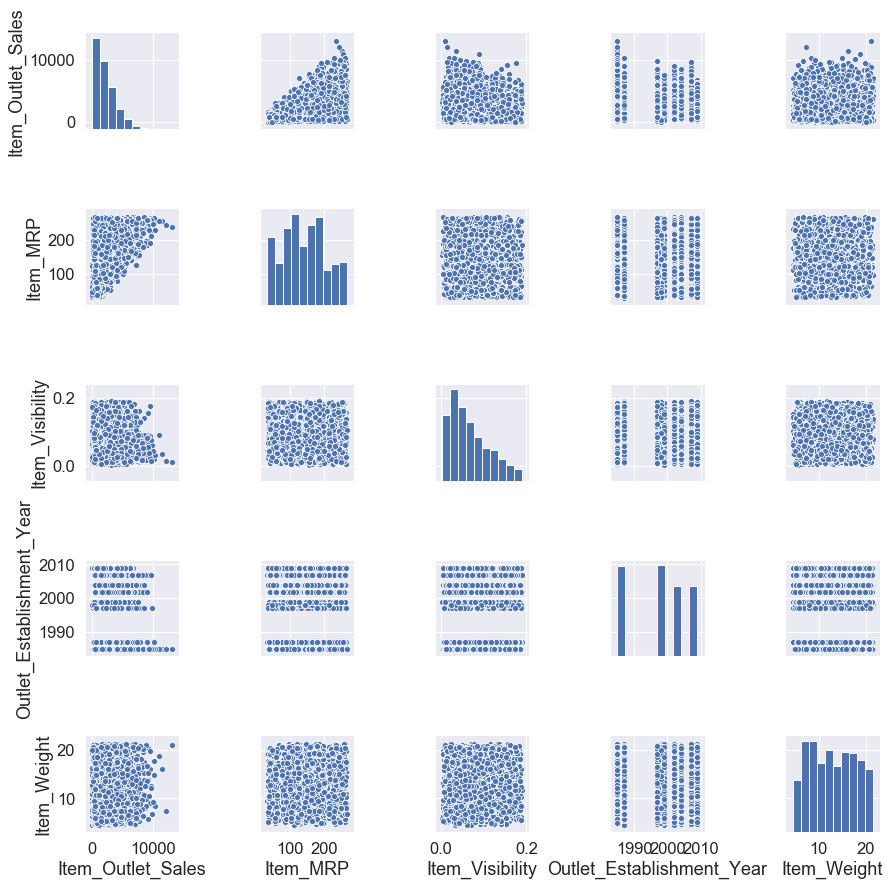

In [98]:
BiVEDA.All_VEDA_conti_higly_correlation_cols_pairplot_scatterplot(high_corr_cols[:10],label_col,train_test[:ntrain],threashold=0.2)

# Evaluate Apply Polynomials by Region Plots on the more Correlated Features

In [99]:
poly_cols=['Item_MRP','Total_Points','Item_Visibility','Item_Weight','MrpPerUnit','ItemAvgMRPmap']


 Its a kind of scatter plot 
['Item_MRP', 'Total_Points', 'Item_Visibility', 'Item_Weight', 'MrpPerUnit', 'ItemAvgMRPmap']


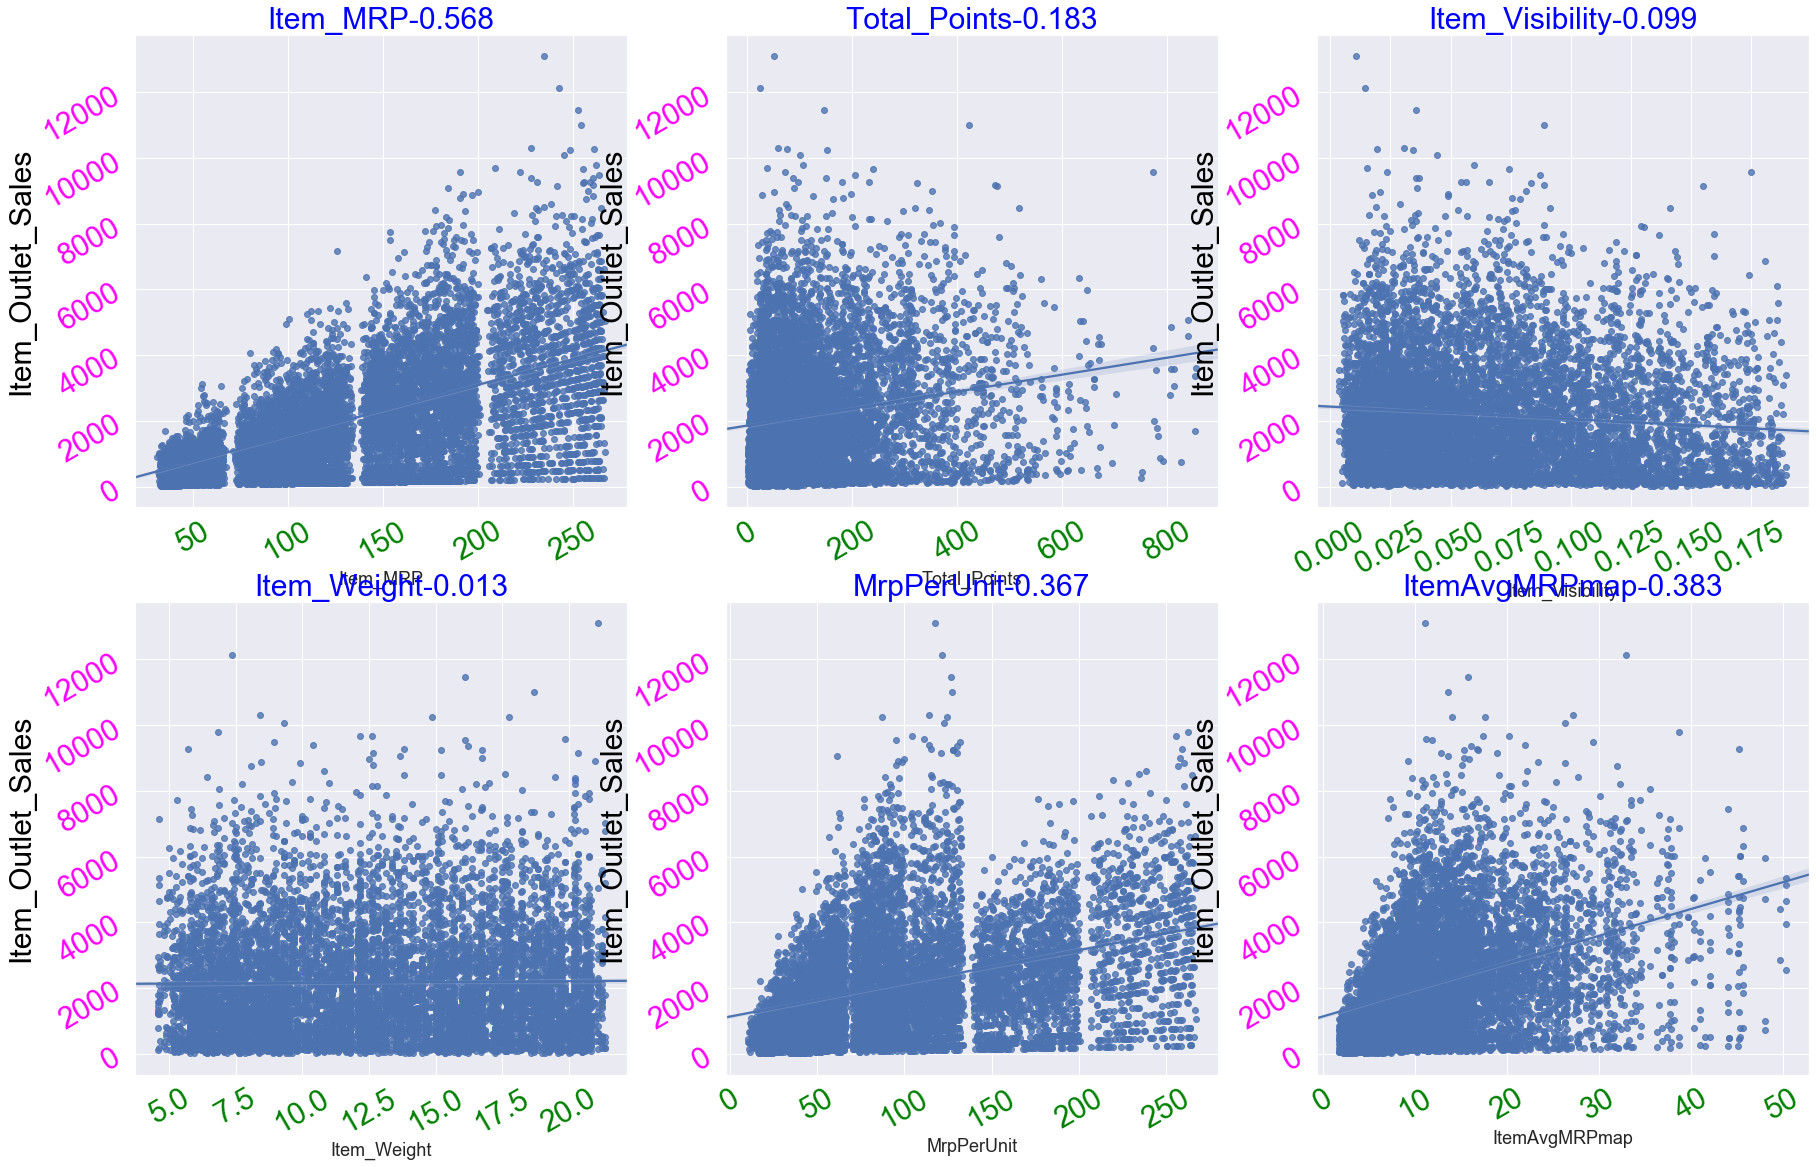

In [100]:
BiVEDA.BiVEDA_conti_cols_regplot_over_yConti(poly_cols,label_col,data[:ntrain])


['Total_Points'] = R2_SQUARE 0.03340729993991576


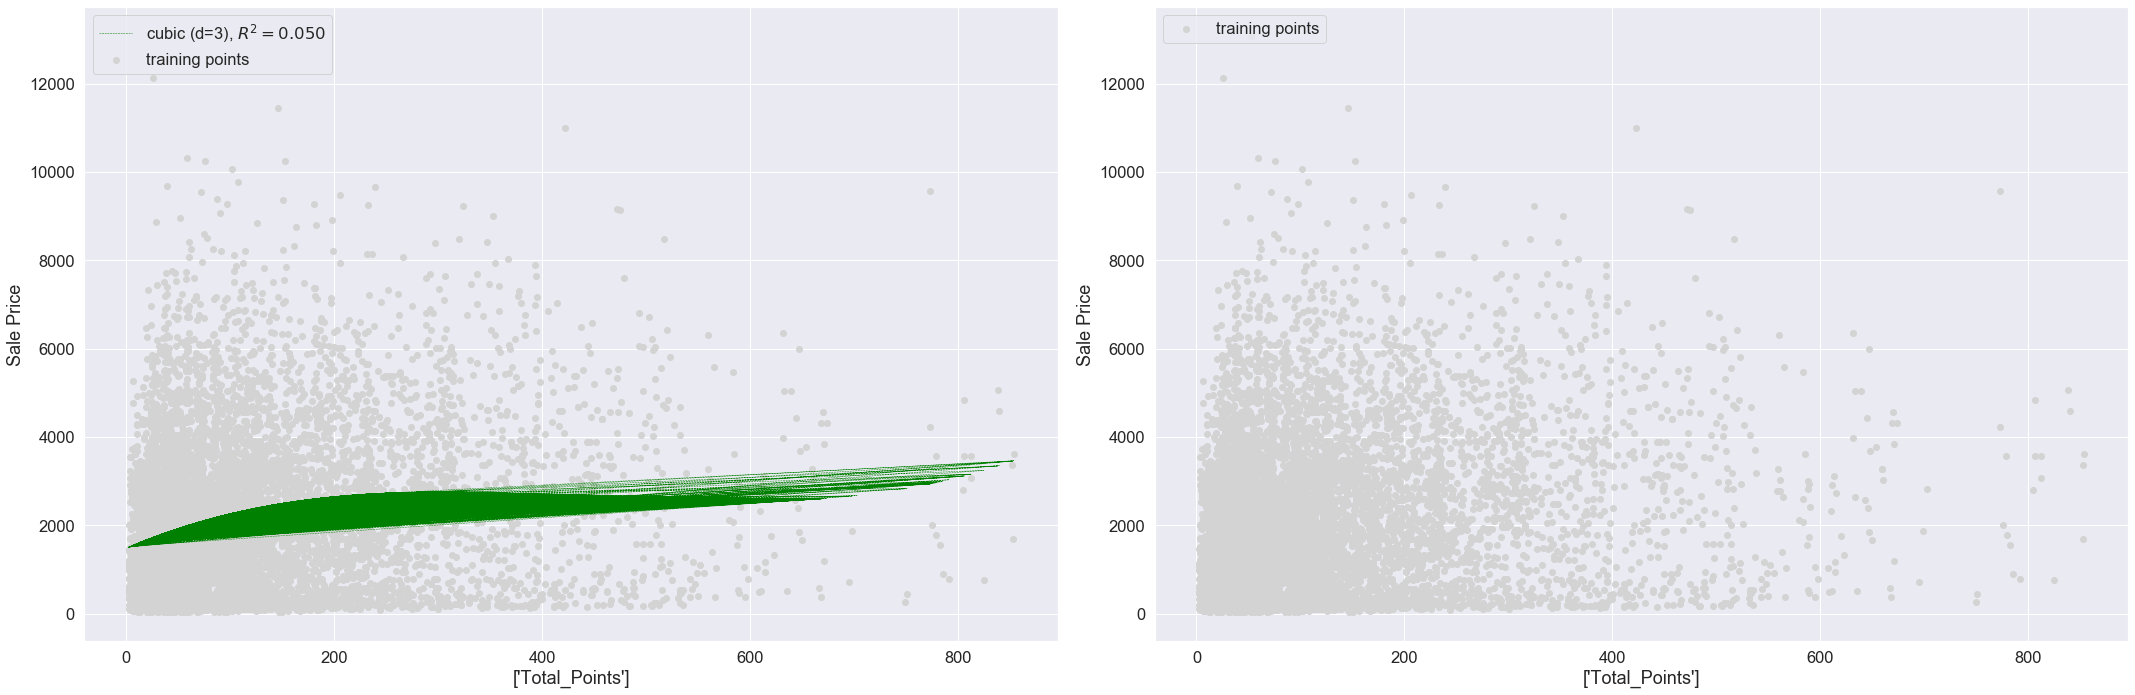

['Item_Visibility'] = R2_SQUARE 0.009854708275707114


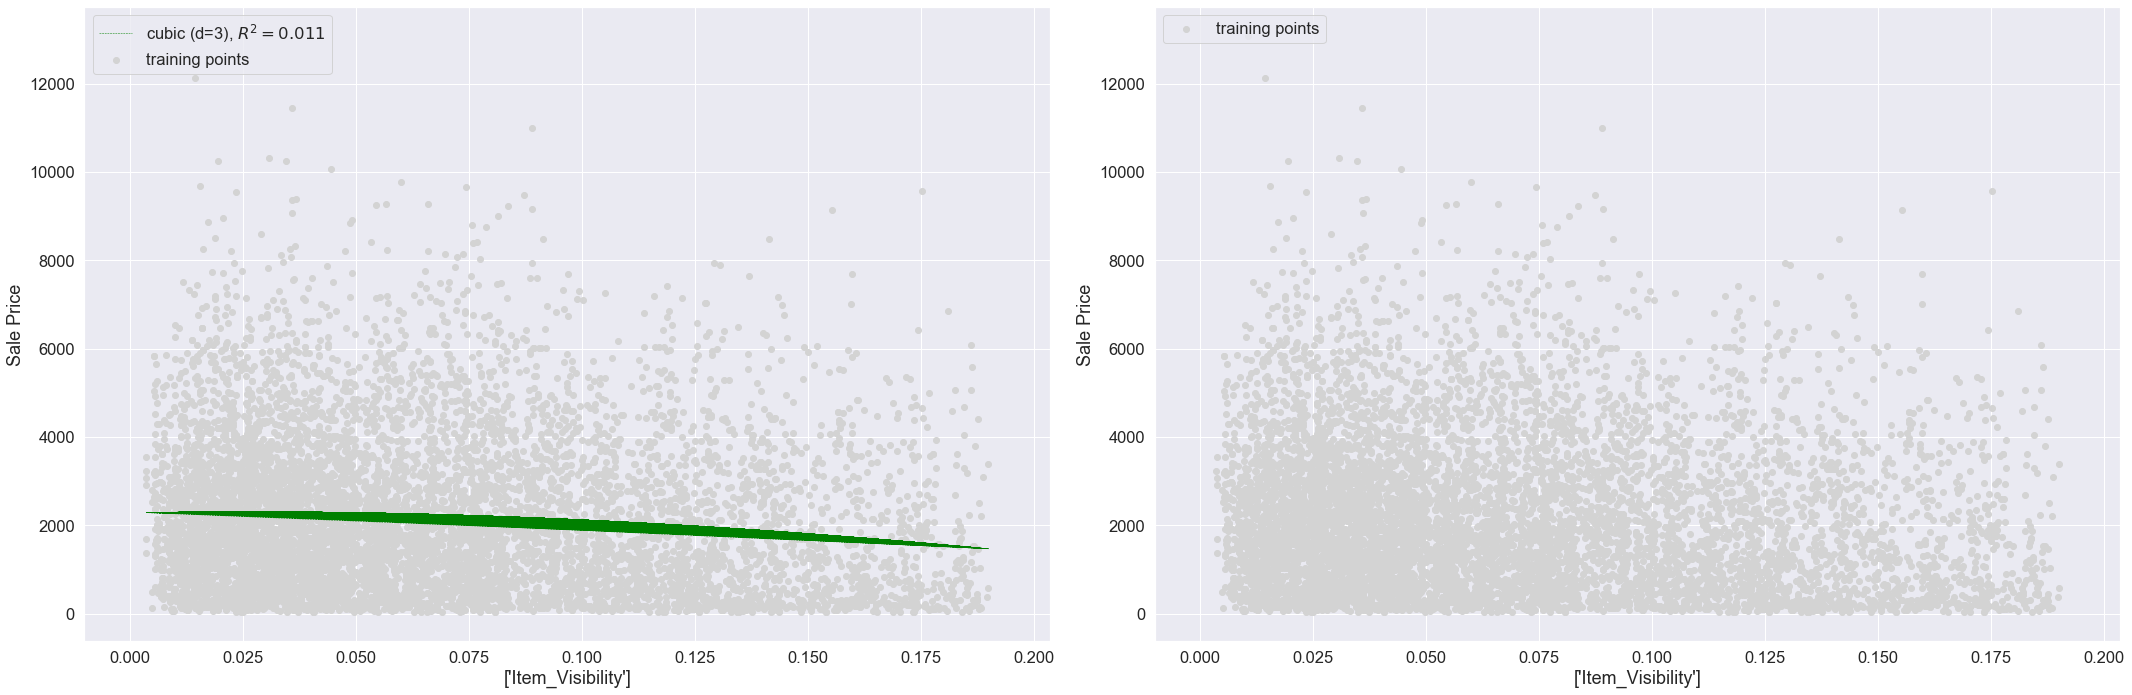

['MrpPerUnit'] = R2_SQUARE 0.134392575625654


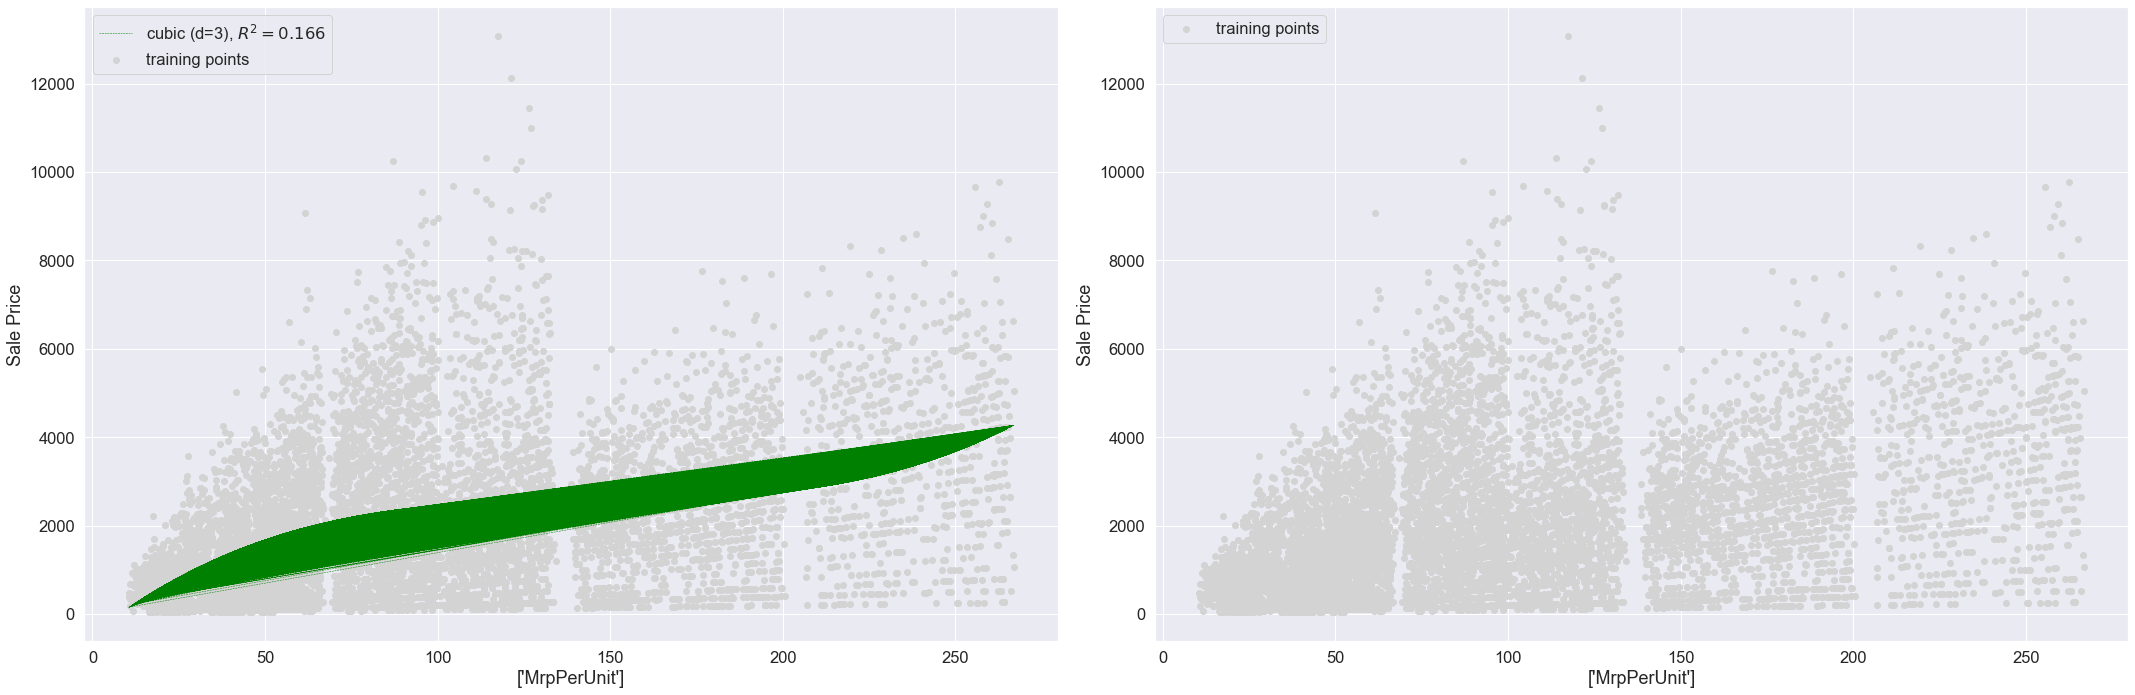

['ItemAvgMRPmap'] = R2_SQUARE 0.14696158988624386


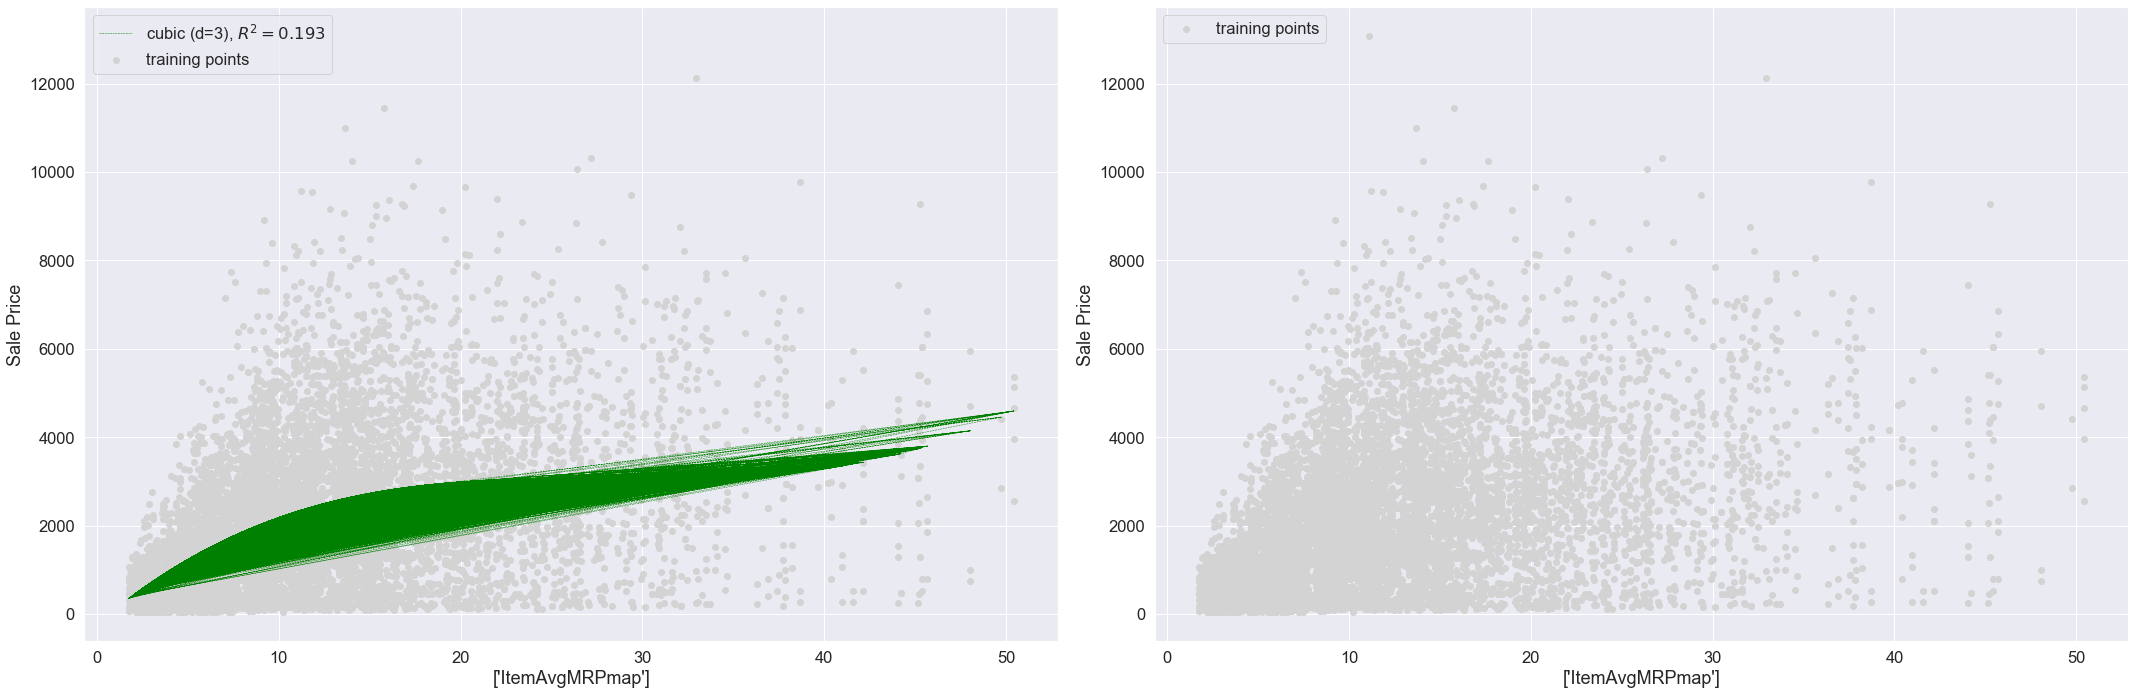

In [101]:
def poly(feat,_df,degree=0,getData=0):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
    from sklearn.linear_model import SGDRegressor,LinearRegression,Ridge,Lasso,ElasticNet

    y = _df[_df[label_col]>0][label_col]
    X = _df.loc[_df[label_col]>0, feat] 
    #print(X.shape,y.shape)
   
    # Initializatin of regression models
    regr = LinearRegression()
    regr = regr.fit(X, y)
    y_lin_fit = regr.predict(X)
    linear_r2 = r2_score(y, regr.predict(X))
    print(feat,"= R2_SQUARE",linear_r2)
    
    # create polynomial features
    quadratic = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
    fourth = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)
    fifth = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)
    X_quad = quadratic.fit_transform(_df[feat])
    X_cubic = cubic.fit_transform(_df[feat])
    X_fourth = fourth.fit_transform(_df[feat])
    X_fifth = fifth.fit_transform(_df[feat])

    if degree==3 and getData==1:
        res = X_cubic
        Degreedpoly=cubic
        target_feature_names = [feature.replace(' ','_') for feature in Degreedpoly.get_feature_names(feat)]
        output_df = pd.DataFrame(res, columns = target_feature_names,  index=_df.index).iloc[:, len(feat):]
        print(feat)
        print("cubic polynomicals of these ", len(feat),'features',"is",output_df.shape)
        return output_df
    # quadratic fit
    regr = regr.fit(X_quad, y)
    y_quad_fit = regr.predict(quadratic.fit_transform(X))
    quadratic_r2 = r2_score(y, y_quad_fit)
    
    # cubic fit
    regr = regr.fit(X_cubic, y)
    y_cubic_fit = regr.predict(cubic.fit_transform(X))
    cubic_r2 = r2_score(y, y_cubic_fit)

    # Fourth fit
    regr = regr.fit(X_fourth, y)
    y_fourth_fit = regr.predict(fourth.fit_transform(X))
    four_r2 = r2_score(y, y_fourth_fit)

    # Fifth fit
    regr = regr.fit(X_fifth, y)
    y_fifth_fit = regr.predict(fifth.fit_transform(X))
    five_r2 = r2_score(y, y_fifth_fit)
    

    
    if len(feat)==1:
        fig = plt.figure(figsize=(30,10))
        # Plot lowest Polynomials
        fig1 = fig.add_subplot(121)
        plt.scatter(X[feat], y, label='training points', color='lightgray')
        if degree==1 or degree==0:
            plt.plot(X[feat], y_lin_fit, label='linear (d=1), $R^2=%.3f$' % linear_r2, color='blue', lw=0.5, linestyle=':')
        if degree==2 or degree==0:
            plt.plot(X[feat], y_quad_fit, label='quadratic (d=2), $R^2=%.3f$' % quadratic_r2, color='red', lw=0.5, linestyle='-')
        if degree==3 or degree==0:
            plt.plot(X[feat], y_cubic_fit, label='cubic (d=3), $R^2=%.3f$' % cubic_r2,  color='green', lw=0.5, linestyle='--')

        plt.xlabel(feat)
        plt.ylabel('Sale Price')
        plt.legend(loc='upper left')

        # Plot higest Polynomials
        fig2 = fig.add_subplot(122)
        plt.scatter(X[feat], y, label='training points', color='lightgray')
        if degree==1 or degree==0:
            plt.plot(X[feat], y_lin_fit, label='linear (d=1), $R^2=%.3f$' % linear_r2, color='blue', lw=2, linestyle=':')
        if degree==5 or degree==0:
            plt.plot(X[feat], y_fifth_fit, label='Fifth (d=5), $R^2=%.3f$' % five_r2, color='yellow', lw=2, linestyle='-')
        if degree==4 or degree==0:
            plt.plot(X[feat], y_fifth_fit, label='Fourth (d=4), $R^2=%.3f$' % four_r2, color='red', lw=2, linestyle=':')

        plt.xlabel(feat)
        plt.ylabel('Sale Price')
        plt.legend(loc='upper left')
    else:
        # Plot initialisation
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, s=40)
        return
        # make lines of the regressors:
        plt.plot(X.iloc[:, 0], X.iloc[:, 1], y_lin_fit, label='linear (d=1), $R^2=%.3f$' % linear_r2, 
                 color='blue', lw=2, linestyle=':')
        plt.plot(X.iloc[:, 0], X.iloc[:, 1], y_quad_fit, label='quadratic (d=2), $R^2=%.3f$' % quadratic_r2, 
                 color='red', lw=0.5, linestyle='-')
        plt.plot(X.iloc[:, 0], X.iloc[:, 1], y_cubic_fit, label='cubic (d=3), $R^2=%.3f$' % cubic_r2, 
                 color='green', lw=0.5, linestyle='--')
        # label the axes
        ax.set_xlabel(X.columns[0])
        ax.set_ylabel(X.columns[1])
        ax.set_zlabel('Sales Price')
        ax.set_title("Poly up to 3 degree")
        plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

poly_cols=['Total_Points', 'Item_Visibility', 'MrpPerUnit', 'ItemAvgMRPmap']
#corr_cols_polyDF=poly(poly_cols,all_data,3)    
for i in range(len(poly_cols)):
     poly(poly_cols[i:i+1],data[:ntrain],3,0)   
        


In [102]:
Best_poly_cols=poly_cols
corr_cols_polyDF=poly(Best_poly_cols, data,3,1)

['Total_Points', 'Item_Visibility', 'MrpPerUnit', 'ItemAvgMRPmap'] = R2_SQUARE 0.2579946305953258
['Total_Points', 'Item_Visibility', 'MrpPerUnit', 'ItemAvgMRPmap']
cubic polynomicals of these  4 features is (14204, 30)


In [103]:
data[corr_cols_polyDF.columns]=corr_cols_polyDF

In [104]:
#ntrain
#corr_cols_polyDF[ntrain:].head()

In [105]:
summy=PPM.desc1(data[:ntrain],2,label_col)

In [106]:
conti_col=summy[summy['dtypes']=='float64'].index
conti_col=conti_col.drop(label_col)
conti_col

Index(['Item_MRP', 'MrpPerUnit_ItemAvgMRPmap^2', 'MrpPerUnit_ItemAvgMRPmap',
       'MrpPerUnit^2_ItemAvgMRPmap', 'ItemAvgMRPmap', 'ItemAvgMRPmap^2',
       'ItemAvgMRPmap^3', 'Total_Points_ItemAvgMRPmap^2',
       'Total_Points_MrpPerUnit_ItemAvgMRPmap', 'MrpPerUnit', 'MrpPerUnit^2',
       'MrpPerUnit^3', 'Total_Points_ItemAvgMRPmap',
       'Total_Points_MrpPerUnit^2', 'Total_Points_MrpPerUnit',
       'Item_Visibility_MrpPerUnit_ItemAvgMRPmap',
       'Item_Visibility_ItemAvgMRPmap^2', 'Total_Points^2_ItemAvgMRPmap',
       'Total_Points^2_MrpPerUnit', 'Item_Visibility_MrpPerUnit^2',
       'Total_Points_Item_Visibility_ItemAvgMRPmap', 'Total_Points',
       'Total_Points^2', 'Total_Points^3',
       'Total_Points_Item_Visibility_MrpPerUnit',
       'Item_Visibility_ItemAvgMRPmap', 'Item_Visibility_MrpPerUnit',
       'Total_Points^2_Item_Visibility', 'Item_Visibility',
       'Item_Visibility^2', 'Item_Visibility^3',
       'Total_Points_Item_Visibility', 'Item_Visibility^2_ItemAv

In [107]:
#contiUniVEDA.UniVEDA_conti_cols_HIST(conti_col,data[conti_col])

In [108]:
NORMQUINT_TRANS=PPM.get_conti_cols_transformed(conti_col,data,e=1,type='NQ')
BoxCox_TRANS=PPM.get_conti_cols_transformed(conti_col,data,e=1,type='BC')
YJohnson_TRANS=PPM.get_conti_cols_transformed(conti_col,data,e=1,type='YJ')

Item_MRP
MrpPerUnit_ItemAvgMRPmap^2
MrpPerUnit_ItemAvgMRPmap
MrpPerUnit^2_ItemAvgMRPmap
ItemAvgMRPmap
ItemAvgMRPmap^2
ItemAvgMRPmap^3
Total_Points_ItemAvgMRPmap^2
Total_Points_MrpPerUnit_ItemAvgMRPmap
MrpPerUnit
MrpPerUnit^2
MrpPerUnit^3
Total_Points_ItemAvgMRPmap
Total_Points_MrpPerUnit^2
Total_Points_MrpPerUnit
Item_Visibility_MrpPerUnit_ItemAvgMRPmap
Item_Visibility_ItemAvgMRPmap^2
Total_Points^2_ItemAvgMRPmap
Total_Points^2_MrpPerUnit
Item_Visibility_MrpPerUnit^2
Item_MRP
MrpPerUnit_ItemAvgMRPmap^2
MrpPerUnit_ItemAvgMRPmap
MrpPerUnit^2_ItemAvgMRPmap
ItemAvgMRPmap
ItemAvgMRPmap^2
ItemAvgMRPmap^3
Total_Points_ItemAvgMRPmap^2
Total_Points_MrpPerUnit_ItemAvgMRPmap
MrpPerUnit
MrpPerUnit^2
MrpPerUnit^3
Total_Points_ItemAvgMRPmap
Total_Points_MrpPerUnit^2
Total_Points_MrpPerUnit
Item_Visibility_MrpPerUnit_ItemAvgMRPmap
Item_Visibility_ItemAvgMRPmap^2
Total_Points^2_ItemAvgMRPmap
Total_Points^2_MrpPerUnit
Item_Visibility_MrpPerUnit^2
Item_MRP
MrpPerUnit_ItemAvgMRPmap^2
MrpPerUnit_ItemAvgMR

In [109]:
#contiUniVEDA.UniVEDA_conti_cols_HIST(conti_col,NORMQUINT_TRANS)

In [110]:
#contiUniVEDA.UniVEDA_conti_cols_HIST(conti_col,BoxCox_TRANS)

In [111]:
#contiUniVEDA.UniVEDA_conti_cols_HIST(conti_col,YJohnson_TRANS)

In [112]:
trans_data=pd.DataFrame({#"org_skew":np.abs(summy['skew'].values),
"NORM_QUINT_skew":np.abs(PPM.desc(NORMQUINT_TRANS)['skew'].values),
"BOXCOX_skew":np.abs(PPM.desc(BoxCox_TRANS)['skew'].values),
"YJ_TRANS":np.abs(PPM.desc(YJohnson_TRANS)['skew'].values)
})
print(trans_data.sum())
trans_data

NORM_QUINT_skew    15.019
BOXCOX_skew         0.591
YJ_TRANS            0.629
dtype: float64


NORM_QUINT_skew  BOXCOX_skew  YJ_TRANS
0             0.013        0.006     0.001
1             0.013        0.012     0.010
2             0.013        0.013     0.013
3             0.009        0.114     0.112
4             0.006        0.040     0.040
5             0.005        0.038     0.037
6             0.005        0.040     0.040
7             1.496        0.043     0.090
8             0.003        0.027     0.027
9             0.001        0.034     0.033
10            0.001        0.039     0.039
11            1.497        0.039     0.041
12            1.492        0.027     0.030
13            1.496        0.006     0.010
14            1.493        0.036     0.036
15            1.496        0.004     0.004
16            1.496        0.020     0.016
17            1.495        0.020     0.016
18            1.496        0.020     0.016
19            1.493        0.013     0.018

In [113]:
#data[YJohnson_TRANS.columns]
YJ_data=data.copy()
YJ_data[YJohnson_TRANS.columns]=YJohnson_TRANS

NQ_data=data.copy()
NQ_data[NORMQUINT_TRANS.columns]=NORMQUINT_TRANS

BC_data=data.copy()
BC_data[BoxCox_TRANS.columns]=BoxCox_TRANS



In [114]:
xtrain=BC_data[:ntrain].drop(label_col,1)
ytrain=BC_data[:ntrain][label_col]
xtest=BC_data[ntrain:].drop(label_col,1)

In [115]:
xtrainNQ=NQ_data[:ntrain].drop(label_col,1)
ytrainNQ=NQ_data[:ntrain][label_col]
xtestNQ=NQ_data[ntrain:].drop(label_col,1)

In [116]:
print(xtrain.shape,xtest.shape)

(8523, 66) (5681, 66)


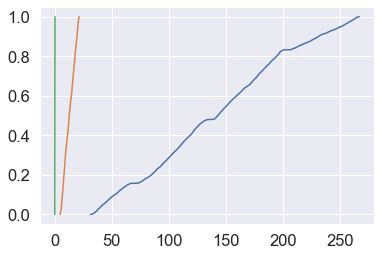

In [117]:
from statsmodels.distributions.empirical_distribution import ECDF
temp_col=['Item_MRP','Item_Weight','Item_Visibility',label_col]
for i in temp_col[:3]:
    _x,_y=ECDF(data[:ntrain][i]).x,ECDF(data[:ntrain][i]).y
    plt.plot(_x,_y)
df=data[:ntrain][temp_col]

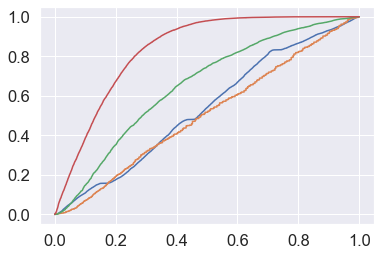

In [118]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)  # Don't cheat - fit only on training data
_xtraningData1 = pd.DataFrame(scaler.transform(df),columns=df.columns)
for i in temp_col:
    _x,_y=ECDF(_xtraningData1[i]).x,ECDF(_xtraningData1[i]).y
    plt.plot(_x,_y)

In [119]:
float_cols=xtrain.columns[xtrain.dtypes=='float64']
len(float_cols)
df=xtrain[float_cols]
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(df)  # Don't cheat - fit only on training data
_xtraningData1 = pd.DataFrame(scaler.transform(df),columns=df.columns)

-----------------------------Cumulative Distribution plot-------------------


1 . ['Item_MRP', 'Item_Visibility', 'Item_Weight', 'Total_Points', 'MrpPerUnit']
2 . ['ItemAvgMRPmap', 'Total_Points^2', 'Total_Points_Item_Visibility', 'Total_Points_MrpPerUnit', 'Total_Points_ItemAvgMRPmap']
3 . ['Item_Visibility^2', 'Item_Visibility_MrpPerUnit', 'Item_Visibility_ItemAvgMRPmap', 'MrpPerUnit^2', 'MrpPerUnit_ItemAvgMRPmap']
4 . ['ItemAvgMRPmap^2', 'Total_Points^3', 'Total_Points^2_Item_Visibility', 'Total_Points^2_MrpPerUnit', 'Total_Points^2_ItemAvgMRPmap']
5 . ['Total_Points_Item_Visibility^2', 'Total_Points_Item_Visibility_MrpPerUnit', 'Total_Points_Item_Visibility_ItemAvgMRPmap', 'Total_Points_MrpPerUnit^2', 'Total_Points_MrpPerUnit_ItemAvgMRPmap']
6 . ['Total_Points_ItemAvgMRPmap^2', 'Item_Visibility^3', 'Item_Visibility^2_MrpPerUnit', 'Item_Visibility^2_ItemAvgMRPmap', 'Item_Visibility_MrpPerUnit^2']
7 . ['Item_Visibility_MrpPerUnit_ItemAvgMRPmap', 'Item_Visibility_ItemAvgMRPmap^2', 'M

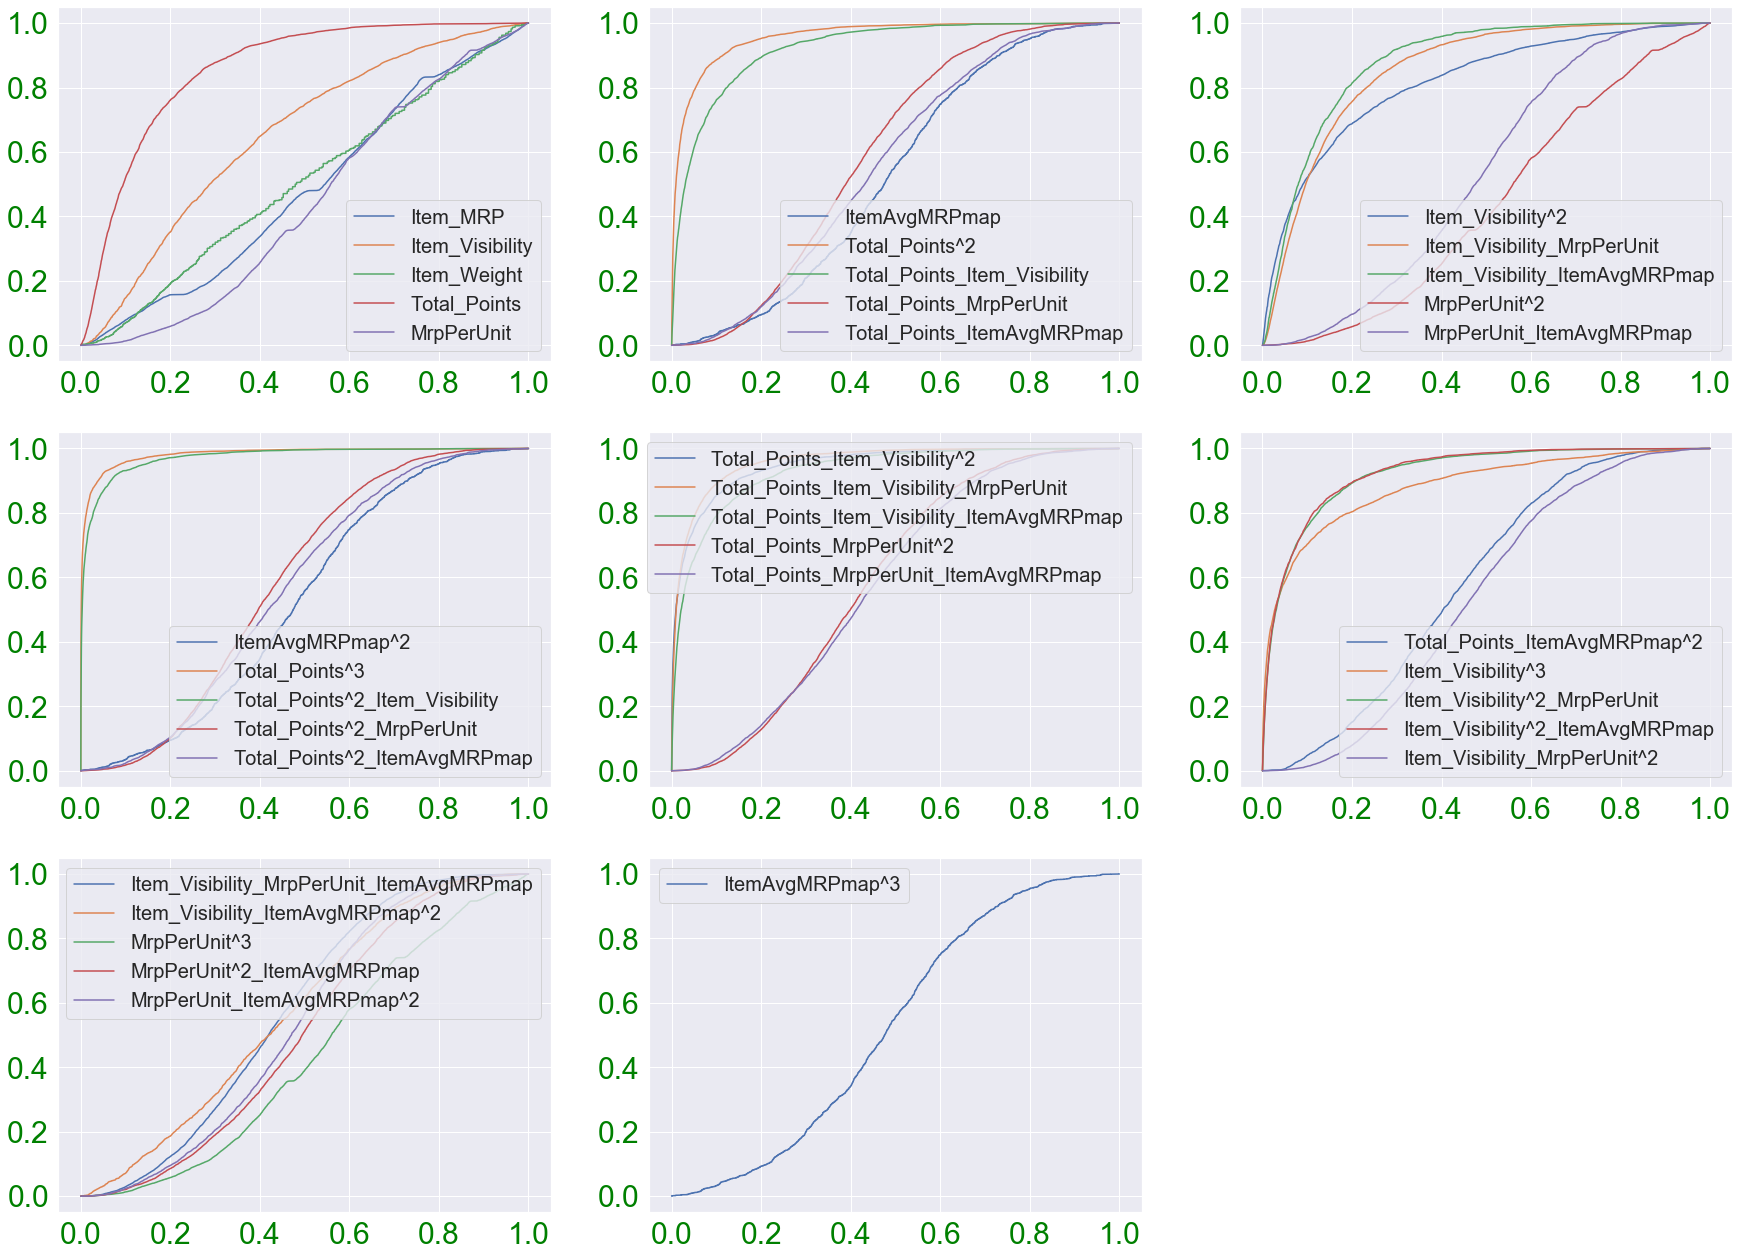

In [120]:
def UniVEDA_conti_cols_CDF_DIST(ColList,_df):
    #print(ColList)
    import math
    from statsmodels.distributions.empirical_distribution import ECDF
    from scipy.stats import norm
    Number_plot=math.ceil(len(ColList)/5)
    k=0
    plt1 = plt
    j = 430
    i = 1
    fig = plt1.figure(figsize=(30, 30))
    plt1.rcParams['font.size'] = 9.0
    plt1.rc('legend',fontsize=20)
    print("-----------------------------Cumulative Distribution plot-------------------\n\n")
    for s in range(Number_plot):
        vars_toPlot=list(ColList[k:k+5])
        k=k+5
        plt1.subplot(j + i)
        
        print(i,".",vars_toPlot)
        i = i + 1
        for colname in vars_toPlot:
            _x,_y=ECDF(_df[colname]).x,ECDF(_df[colname]).y
            #print(colname)
            plt1.plot(_x,_y)
            #plt1.plot(_x, 1. - _y)
            plt1.xticks(fontsize=30,color='green')
            plt1.yticks(fontsize=30,color='green')
            plt1.title('')
            plt1.legend(vars_toPlot)
        
            #plt1.xlabel(fontsize=30,color='brown')
            
        
UniVEDA_conti_cols_CDF_DIST(float_cols,_xtraningData1)   

In [121]:
def generate_submission_file(submission_csv_name,model,org_test,cleaned_test):
    y_pred = model.predict(cleaned_test)

    #Export submission file:
    org_test[label_col]=y_pred
    submission=org_test[['Item_Identifier','Outlet_Identifier',label_col]]
    negRec=len(submission[submission.Item_Outlet_Sales<0])
    if negRec >0:
        print("Output contain Negative records:", negRec)
        submission.to_csv(submission_csv_name, index=False)
        return submission[submission.Item_Outlet_Sales<0]
    else:
        submission.to_csv(submission_csv_name, index=False)
        
    return y_pred

In [122]:
def resilduals_plots(_lr,_colList, _X, _Y, log=False):
    _X=_X[_colList]
    _y_pred = _lr.predict(_X)
    _residual = pd.DataFrame()
    _residual['Predict'] = _y_pred
    _residual['Residual'] = _Y - _y_pred
    _residual['Predicted'] = np.expm1(_residual.Predict)
    _residual['StdResidual'] = np.expm1(_Y) - _residual.Predicted
    _residual.StdResidual = _residual.StdResidual / _residual.StdResidual.std()
    _residual['IDX'] = _X.index
    
    if log:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(121)
        g = sns.regplot(y='Residual', x='Predict', data = _residual, order=1, ax = ax) 
        plt.xlabel('Log Predicted Values')
        plt.ylabel('Log Residuals')
        plt.hlines(y=0, xmin=min(_Y)-1, xmax=max(_Y)+1, lw=2, color='red')
        plt.xlim([min(_Y)-1, max(_Y)+1])

        ax = fig.add_subplot(122)
        g = sns.regplot(y='StdResidual', x='Predicted', data = _residual, order=1, ax = ax) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=np.expm1(min(_Y))-1, xmax=np.expm1(max(_Y))+1, lw=2, color='red')
        plt.xlim([np.expm1(min(_Y))-1, np.expm1(max(_Y))+1])
    else:
        _residual.StdResidual = _residual.Residual / _residual.Residual.std()
        _residual.drop(['Residual', 'Predicted'], axis = 1, inplace=True)
        g = sns.regplot(y='StdResidual', x='Predict', data = _residual, order=1) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=min(_Y)-1, xmax=max(_Y)+1, lw=2, color='red')
        plt.xlim([min(_Y)-1, max(_Y)+1])

    plt.show()  

    return _residual

In [123]:
from sklearn.linear_model import SGDRegressor,LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model_dict={} 
model_dict['linear_regression']=LinearRegression()#(penalty = 'l1') #['l1', 'l2']
model_dict['stochastic_gradientDescent_regressor']=SGDRegressor()
model_dict['ridge_regularization']=Ridge() 
model_dict['lasso_regularization']=Lasso()
model_dict['elasticNet_regularization']=ElasticNet() 
model_dict['decision_tree_regressor']=DecisionTreeRegressor(max_depth=20,random_state=46,min_samples_leaf= 29,min_samples_split= 58,
                          max_leaf_nodes= 50)

model_dict['sklearn_gradient_boosting_regressor']=GradientBoostingRegressor(max_depth=20,random_state=46,min_samples_leaf= 29,min_samples_split= 58,
                          max_leaf_nodes= 50,n_estimators=250)
model_dict['xgboost_gradient_boosting_regressor']=XGBRegressor(max_depth=20,random_state=46,min_samples_leaf= 29,min_samples_split= 58,
                          max_leaf_nodes= 50,n_estimators=250)


model_dict['ada_boost_regressor']=AdaBoostRegressor(DecisionTreeRegressor(max_depth=3,min_samples_leaf=500,min_samples_split= 580),random_state=46,n_estimators=500,learning_rate=0.3)
model_dict['random_forest_regressor']=RandomForestRegressor(max_depth=20,random_state=46,min_samples_leaf= 29,min_samples_split= 58,
                          max_leaf_nodes= 50,n_estimators=30,max_features=len(xtrain.columns))

In [124]:
training_scoreDF=pd.DataFrame()
test_predictionDF=pd.DataFrame()
train_predictionDF=pd.DataFrame()
def generate_all_model_score(_xtraningData1,_ytraniningData1,_xtestingData1,tagName):
    import itertools
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import QuantileTransformer, quantile_transform
    for key,val in dict(itertools.islice(model_dict.items(), 0, 10)).items():
        
        model_name=key+'_' + tagName
        model_type=val
        if model_name == 'stochastic_gradientDescent_regressor' + '_' + tagName:
            scaler = MinMaxScaler()
            scaler.fit(_xtraningData1)  # Don't cheat - fit only on training data
            _xtraningData1 = pd.DataFrame(scaler.transform(_xtraningData1),columns=_xtraningData1.columns)
            
        #scaler = MinMaxScaler()
        #scaler.fit(_xtraningData1)  # Don't cheat - fit only on training data
        #_xtraningData1 = pd.DataFrame(scaler.transform(_xtraningData1),columns=_xtraningData1.columns)
        
        #wrapped_model = TransformedTargetRegressor(regressor=model_type, transformer=MinMaxScaler())
        wrapped_model = TransformedTargetRegressor(regressor=model_type, 
                                                    transformer=QuantileTransformer(n_quantiles=300,
                                                     output_distribution='normal'))
        
        training_scoreDF[model_name]=PPM.regressionModelfit_CV(wrapped_model,_xtraningData1.columns,_xtraningData1,_ytraniningData1,model_name,5)
#         from sklearn.metrics import mean_squared_error
#         ptrain=model_type.predict(_xtraningData1)
#         #train_predictionDF[model_name]=xpred
        
#         ptest=model_type.predict(_xtestingData1)
#         #test_predictionDF[model_name]=ptest
#         print("training rmse=",round((mean_squared_error(_ytraniningData1,ptrain)**1/2),2),len(ptest),len(_xtestingData1))
#         return ptest
        #print("test rmse=",mean_squared_error(ytesting,ptest))
#print(xtrainDF.shape,ytrainDF.shape,xtestDF.shape)
generate_all_model_score(xtrain,ytrain,xtest,'with_normalxx')

------------      linear_regression_with_normalxx     ------------
fit_time =0.03
score_time =0.01
test_r2 =0.59
train_r2 =0.60
test_neg_mean_absolute_error =27.51
train_neg_mean_absolute_error =27.37
test_neg_mean_squared_error =1089.64
train_neg_mean_squared_error =1078.28
overFitt_val =  11.359283355775915
------------      stochastic_gradientDescent_regressor_with_normalxx     ------------
fit_time =0.05
score_time =0.01
test_r2 =0.58
train_r2 =0.58
test_neg_mean_absolute_error =27.76
train_neg_mean_absolute_error =27.67
test_neg_mean_squared_error =1104.93
train_neg_mean_squared_error =1099.43
overFitt_val =  5.49094302724825
------------      ridge_regularization_with_normalxx     ------------
fit_time =0.02
score_time =0.01
test_r2 =0.59
train_r2 =0.60
test_neg_mean_absolute_error =27.49
train_neg_mean_absolute_error =27.40
test_neg_mean_squared_error =1088.47
train_neg_mean_squared_error =1080.51
overFitt_val =  7.967681895994701
------------      lasso_regularization_with_norm

# 1. What are the Linear Regression Assumption?

IV = Independent Variable( or label)
DV = Dependent variable ( or input variable)

1.	There exists a linear and additive relationship between dependent (DV) and independent variables (IV).

    By linear, it means that the change in DV by 1 unit change in IV is constant. By additive, it refers to the effect of X on Y is independent of other variables.
2.	There must be no correlation among independent variables. Presence of correlation in independent variables lead to Multicollinearity. If variables are correlated, it becomes extremely difficult for the model to determine the true effect of IVs on DV.
3.	The error terms must possess constant variance. Absence of constant variance leads to heteroskedestacity.
4.	The error terms must be uncorrelated and independent i.e. error at ∈t must not indicate the at error at ∈t+1. Presence of correlation in error terms is known as Autocorrelation. It drastically affects the regression coefficients and standard error values since they are based on the assumption of uncorrelated error terms.
5.	The dependent variable and the error terms must possess a normal distribution.
6. Outliers can also be an issue impacting the model quality by having a disproportionate influence on the estimated model parameters.

Presence of these assumptions make regression quite restrictive. By restrictive I meant, the performance of a regression model is conditioned on fulfillment of these assumptions.

# 2. How do I know these assumptions are violated in my data?

- Graphical methods


    1. Residual vs. Fitted Values Plot
    Ideally, this plot shouldn't show any pattern. But if you see any shape (curve, U shape), it suggests non-linearity in the data set. In addition, if you see a funnel shape pattern, it suggests your data is suffering from heteroskedasticity, i.e. the error terms have non-constant variance, if it is forming cluster, then its non linear relationship

   
   Residual plot are used to analyze the variance of the error of the regressor. If the points are randomly dispersed around the horizontal axis, a linear regression model is usually appropriate for the data; otherwise, a non-linear model is more appropriate.
   

    2. Normality Q-Q Plot
    As the name suggests, this plot is used to determine the normal distribution of errors. It uses standardized values of residuals. Ideally, this plot should show a straight line. If you find a curved, distorted line, then your residuals have a non-normal distribution (problematic situation).


    3. Scale Location Plot
    This plot is also useful to determine heteroskedasticity. Ideally, this plot shouldn't show any pattern. Presence of a pattern determine heteroskedasticity. Don't forget to corroborate the findings of this plot with the funnel shape in residual vs. fitted values.


 
- Non-Graphical methods

    you can also perform quick tests / methods to check assumption violations:


    1.	Durbin Watson Statistic (DW) - This test is used to check autocorrelation. Its value lies between 0 and 4. A DW=2 value shows no autocorrelation. However, a value between 0 < DW < 2 implies positive autocorrelation, while 2 < DW < 4 implies negative autocorrelation.


    2.	Variance Inflation Factor (VIF) - This metric is used to check multicollinearity. VIF <=4 implies no multicollinearity but VIF >=10 suggests high multicollinearity. Alternatively, you can also look at the tolerance (1/VIF) value to determine correlation in IVs. In addition, you can also create a correlation matrix to determine collinear variables.

    3.	Breusch-Pagan / Cook Weisberg Test - This test is used to determine presence of heteroskedasticity. If you find p < 0.05, you reject the null hypothesis and infer tha


# 3. How can you improve the accuracy of a regression model ?
    There is little you can do when your data violates regression assumptions. An obvious solution is to use tree-based algorithms which capture non-linearity quite well. But if you are adamant at using regression, following are some tips you can implement:

1. If your data is suffering from non-linearity, transform the IVs using sqrt, log, square, etc.
2. If your data is suffering from heteroskedasticity, transform the DV using sqrt, log, square, etc. Also, you can use weighted least square method to tackle this problem.
3. If your data is suffering from multicollinearity, use a correlation matrix to check correlated variables. Let's say variables A and B are highly correlated. Now, instead of removing one of them, use this approach: Find the average correlation of A and B with the rest of the variables. Whichever variable has the higher average in comparison with other variables, remove it. Alternatively, you can use penalized regression methods such as lasso, ridge, elastic net, etc.
4. You can do variable selection based on p values. If a variable shows p value > 0.05, we can remove that variable from model since at p> 0.05, we'll always fail to reject null hypothesis.

In [125]:
xtrain.shape

(8523, 66)

In [126]:
def backwardElimination(_df, _ytrain, sl, columns):
    import statsmodels.api as sm
    ini = len(columns)
    numVars = _df.shape[1]
    for i in range(0, numVars):
        regressor = sm.OLS(_ytrain, _df).fit()
        maxVar = max(regressor.pvalues) #.astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor.pvalues[j].astype(float) == maxVar):
                    columns = np.delete(columns, j)
                    _df = _df.loc[:, columns]
                    
    print('\nSelect {:d} features from {:d} by best p-values.'.format(len(columns), ini))
    print('The max p-value from the features selecte is {:.3f}.'.format(maxVar))
    print(regressor.summary())
    
    # odds ratios and 95% CI
    conf = np.exp(regressor.conf_int())
    conf['Odds Ratios'] = np.exp(regressor.params)
    conf.columns = ['2.5%', '97.5%', 'Odds Ratios']
    display(conf)
    
    return columns, regressor
SL = 0.051
pv_cols, LR = backwardElimination(xtrain, ytrain, SL, xtrain.columns )



Select 19 features from 66 by best p-values.
The max p-value from the features selecte is 0.029.
                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     655.5
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:48:57   Log-Likelihood:                -71955.
No. Observations:                8523   AIC:                         1.439e+05
Df Residuals:                    8505   BIC:                         1.441e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------

2.5%          97.5%    Odds Ratios
Item_MRP                                 inf            inf            inf
Outlet_Size                    8.950865e-100   2.925444e-47   1.618186e-73
Outlet_Type_wiseVisibility               inf            inf            inf
Outlet_Ranking                  1.531488e+09   1.200614e+24   4.288036e+16
Total_Points                    2.248150e+00   5.708609e+01   1.132864e+01
Outlet_Type_Grocery Store       0.000000e+00   0.000000e+00   0.000000e+00
Outlet_Type_Supermarket Type1   0.000000e+00   0.000000e+00   0.000000e+00
Item_Type_Health and Hygiene    1.015272e+22  6.098941e+112   2.488390e+67
Item_Type_Household             2.104734e+13   1.076926e+97   1.505537e+55
Item_Type_Others                8.754099e+06  3.657323e+131   1.789317e+69
Item_Category_Drinks           8.022682e+150            inf  1.645863e+261
Item_Category_Food             5.117442e+165            inf  3.619881e+271
Item_Category_Non-Consumable   1.667675e+110  2.694532e+273  6.703435e+191
Total_Points_Item_Visibility    5.046678e-12   8.469223e-05   2.067400e-08
Item_Visibility^2                        inf            inf            inf
Item_Visibility_ItemAvgMRPmap  2.087510e-192  1.880787e-101  6.265909e-147
Total_Points^2_MrpPerUnit       0.000000e+00  8.802687e-226  1.442635e-316
Total_Points_ItemAvgMRPmap^2   8.127220e+266            inf            inf
ItemAvgMRPmap^3                4.739772e-267  7.545794e-134  1.891173e-200

# https://www.youtube.com/watch?v=U7D1h5bbpcs 
# Understanding  OLS Summary
1. Rsquare value 0.995)
   That means it signifies how well the model data is fitting 
   is closure to 1  means its a good fit model
   

2. R-squared  , Adj. R-squared  are same No difference
   It means that there is no useless predictor in the model , but if Adj RSqure is less and there difference between
   between Rsquare and AdjRsquare is wide , then there are few or more useless independent variable in the model
   Adj Rquare is calculated by penalize the model with features which are not adding anything.


3. Ftest and p value of ftest ( are used to assess the sigficance of overall model)

    p value of ftest less than 0.05 and F-stat high values 
    will reject the null hypotheis of homoskedasticity and present confidence to evidance that there is no linear relanship among the differece feature and label
    and Or you can say it accept the alternate hypothoses of heteroscadasity.
    there is no multi-collinearity

4. T-test - 

      this is performed betwee the target and each feature seperatly and generated coefficeint values
      null hypotheses says that the coefficient values is zero 
      Alternate hypothesis say that coeffiencet value is greater than zero
      Higher value of T-test value is good and reject the null  hypothesie(accept the alternate hypothese)
      and conforming that coeffecient value is non zero
      For  value of coeffecient closure to zero, you may observe low value of T-stats, higher value of p values (> 0.05) from that table 
      here you can delete the feature ( as you are accepting the null hypothesis)
  
  
5. Durbin Watson Statistic (DW) - 

    This test is used to check autocorrelation. Its value lies between 0 and 4. A DW=2 value shows no autocorrelation. However, a value between 0 < DW < 2 implies positive autocorrelation, while 2 < DW < 4 implies negative autocorrelation.


6. The Jarque-Bera (JB) test is a test for normality. 

    This test is usually used for large data sets,
    because other tests like Q-Q Plots can become unreliable when your sample size is large.

    the Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution.

    The null hypothesis is a joint hypothesis of the skewness being zero and the excess kurtosis being zero
    i. e data is noramally distributed

    JB(PValue>0.05)= Accept Ho (Normal Distribution)
    JB(PValue<0.05)= Reject Ho (Non-Normal Distribution)

    Here is how you use JB in statsmodels. A JB value of roughly 6 or higher indicates that errors are not normally distributed. In other words, this means that the normality null hypothesis has been rejected at the $5\%$ significance level. A value close to 0 on the contrary, indicates the data $is$ normally distributed. We have already seen the JB test using model.summary(). The code below shows you how to run this test on its own.

    Example 1
    [('Jarque-Bera', 0.6688077048615619),

    ('Prob', 0.7157646605518615),

    ('Skew', -0.08863202396577206),

    ('Kurtosis', 2.779014973597054)]

     We have a JB value = 0.67, which is pretty low (and in favor of normality), But But But the p-value of 0.71 is quite high to reject the null hypothesis for normality. Additionally, the kurtosis is below 3, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. The skewness values however show that underlying data is moderately skewed.

    Example 2

     [('Jarque-Bera', 21.90969546280269),

     ('Prob', 1.74731047370758e-05),

     ('Skew', -0.7636952540480038),

     ('Kurtosis', 3.5442808937621666)]

     the JB results considerably worse. More-over, a JB p-value much smaller than 0.05 indicates that the normality assumption should definitely be rejected.
     
     
5. RMSE / MSE / MAE - Error metric is the crucial evaluation number we must check. Since all these are errors, lower the number, better the model. Let's look at them one by one:
   - MSE - This is mean squared error. It tends to amplify the impact of outliers on the model's accuracy. For example, suppose the actual y is 10 and predictive y is 30, the resultant MSE would be (30-10)² = 400.
   - MAE - This is mean absolute error. It is robust against the effect of outliers. Using the previous example, the resultant MAE would be (30-10) = 20
   - RMSE - This is root mean square error. It is interpreted as how far on an average, the residuals are from zero. It nullifies squared effect of MSE by square root and provides the result in original units as data. Here, the resultant RMSE would be √(30-10)² = 20. Don't get baffled when you see the same value of MAE and RMSE. Usually, we calculate these numbers after summing overall values (actual - predicted) from the data.
  
6. AIC/BIC -Akaike information criterion/Bayesian information criterion - Penalizer and rewarders
     The concept of model complexity can be used to create measures aiding in model selection. There are a few measures which explicitly deal with this trade-off between goodness of fit and model simplicity, for instance the Akaike information criterion (AIC) and the Bayesian information criterion (BIC). Both penalize the number of model parameters but reward goodness of fit on the training set, hence the best model is the one with lowest AIC/BIC. BIC penalizes model complexity stronger and hence favors models which are “more wrong” but simpler. While this allows to do model selection without a validation set, it can be strictly applied only for models which are linear in their parameters, even though it typically also works in more general cases, e.g. for general linear models such as logistic regression. For a more detailed discussion, see e.g. Ref. 

In [127]:
print("No of featured selected by OLS regression:", len(pv_cols))
pred = LR.predict(xtrain[pv_cols])

#df_copy['proba'] = pred

y_pred = pred.apply(lambda x: 1 if x > 0.5 else 0)
print('Fvalue: {:.6f}'.format(LR.fvalue))
print('MSE total on the train data: {:.4f}'.format(np.sqrt(LR.mse_total)))

No of featured selected by OLS regression: 19
Fvalue: 655.525153
MSE total on the train data: 1706.4996


# 1.  Normality test - Error terms(residual) from Linear regression

- Purpose:
    The purpose is to check if the residuals are normally distributed or not.
    
    
    We can understand and detect the non-normality of the residual using following methods or plots

## -   1.1. using QQ plot 
## -   1.2. using hist plot
## -   1.4. Statistical methods


- Bad linear model yeild , Non-Normal residual:
    - root cause of Non -normal residual
    - potential reasons could include the linearity assumption being violated or outliers affecting our model.

##### Solution to Normality Issue:
    - If the errors are not normally distributed, non – linear transformation of the variables (response or predictors) can bring improvement in the model.
    - Excluding specific variables (such as long-tailed variables), or removing outliers may solve this problem.

### 1.1. QQ plot 

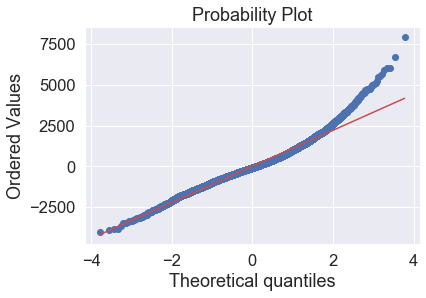

In [128]:
# 1.1 QQ plot
import scipy as sp
#plt.legend(['r'])
_, (__, ___, r)=sp.stats.probplot(LR.resid, plot=plt,fit=True)

QQ plot Conti columns
      
['resid']


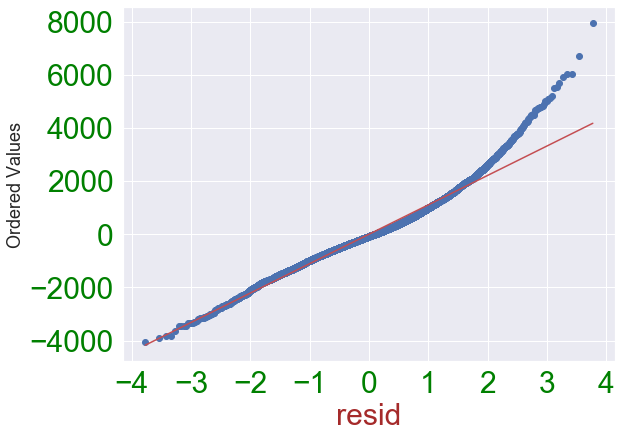

In [129]:
# QQ plot
residDF=pd.DataFrame(LR.resid,columns=['resid'])
contiUniVEDA.UniVEDA_conti_cols_PROBPLOT(['resid'],residDF)


### 1.2 Histogram to test resiudal noramality

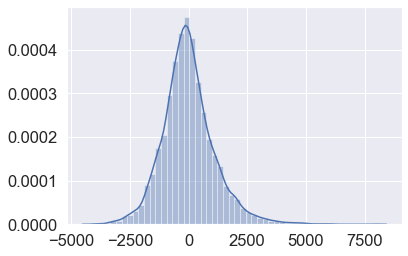

In [130]:

sns.distplot(LR.resid)

### 1.3 The Jarque-Bera (JB) and other test to check normality of Residuals

This test is usually used for large data sets,
because other tests like Q-Q Plots can become unreliable when your sample size is large.

the Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution.

The null hypothesis is a joint hypothesis of the skewness being zero and the excess kurtosis being zero
i. e data is noramally distributed

    JB(PValue>0.05)= Accept Ho (Normal Distribution)
    JB(PValue<0.05)= Reject Ho (Non-Normal Distribution)
    
    if p > 0.05:
        print('Sample looks Gaussian (fail to reject H0)-Accept Ho')
    else:
        print('Sample does not look Gaussian (reject H0)')


Here is how you use JB in statsmodels. A JB value of roughly 6 or higher indicates that errors are not normally distributed. In other words, this means that the normality null hypothesis has been rejected at the $5\%$ significance level. A value close to 0 on the contrary, indicates the data $is$ normally distributed. We have already seen the JB test using model.summary(). The code below shows you how to run this test on its own.

Example 1
[('Jarque-Bera', 0.6688077048615619),

('Prob', 0.7157646605518615),

('Skew', -0.08863202396577206),

('Kurtosis', 2.779014973597054)]
 
 We have a JB value = 0.67, which is pretty low (and in favor of normality), But But But the p-value of 0.71 is quite high to reject the null hypothesis for normality. Additionally, the kurtosis is below 3, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. The skewness values however show that underlying data is moderately skewed.

Example 2

 [('Jarque-Bera', 21.90969546280269),
 
 ('Prob', 1.74731047370758e-05),
 
 ('Skew', -0.7636952540480038),
 
 ('Kurtosis', 3.5442808937621666)]
 
 the JB results considerably worse. More-over, a JB p-value much smaller than 0.05 indicates that the normality assumption should definitely be rejected.

In [131]:
#sm.stats.linear_rainbow(res)
from scipy.stats import shapiro,normaltest,chi2,kstest#,linear_harvey_collier
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import normal_ad
JBname = ['Jarque-Bera','Chi^2 two-tail Prob.','Skew', 'Kurtosis']
ONname = ['Omni-Norm-Chi^2', 'Two-tail prob.']

#for i in df.columns:
print("\n--------Noramality test of Linear Regression Residuals-------\n")
print("\t1.  shiproTest:", shapiro(LR.resid))
print("\t2. "  ,normaltest(LR.resid))
print("\t3. " ,kstest(LR.resid,'norm'))
print("\t4. ",dict(zip(JBname, sms.jarque_bera(LR.resid))))
print("\t5. ",dict(zip(ONname, sms.omni_normtest(LR.resid))))
print("\t6.  Anderson-Darling" ,normal_ad(LR.resid))
#sms.linear_rainbow(LR)


--------Noramality test of Linear Regression Residuals-------

	1.  shiproTest: (0.9710742831230164, 3.007456674784979e-38)
	2.  NormaltestResult(statistic=963.9190251715559, pvalue=4.8712810070705525e-210)
	3.  KstestResult(statistic=0.5362252323566491, pvalue=0.0)
	4.  {'Jarque-Bera': 2350.066749482678, 'Chi^2 two-tail Prob.': 0.0, 'Skew': 0.6624395577724959, 'Kurtosis': 5.205055902533405}
	5.  {'Omni-Norm-Chi^2': 963.9190251715559, 'Two-tail prob.': 4.8712810070705525e-210}
	6.  Anderson-Darling (52.04885570501574, 0.0)


# 2. Durbin Watson Statistic (DW -  autocorrelation test) 

    Auto Correlation is also called serial correlation.
    This test is used to check autocorrelation in residuals or error terms. Its value lies between 0 and 4. 
    DW=2  means no autocorrelation. However
    0 < DW < 2 implies positive autocorrelation
    2 < DW < 4 implies negative autocorrelation.
    Null hypothese of DW test say , there in no auto-correlation in the error trems
    DW test is also called AR(1) serieal correlation test 
    


In [132]:
from statsmodels.stats.stattools import durbin_watson
print("DW test Value (Auto-Correlation value) over linearn regression residuals:", durbin_watson(LR.resid))

DW test Value (Auto-Correlation value) over linearn regression residuals: 2.0052818073583385


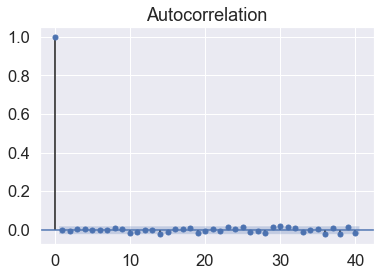

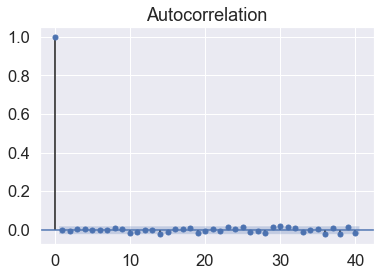

In [133]:
dir(LR) #dta.values.squeeze()
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(LR.resid.values.squeeze(), lags=40)

In [134]:
from scipy.stats import ks_2samp
print(ks_2samp(data[:ntrain]['Item_MRP'],data[:ntrain][label_col]))
#print(kstest(train_org[:ntrain]['Item_MRP'],'norm'))
#print(kstest(xtrain[:ntrain]['Item_MRP'],'norm'))


Ks_2sampResult(statistic=0.9218585005279831, pvalue=0.0)


In [135]:
pv_cols

Index(['Item_MRP', 'Outlet_Size', 'Outlet_Type_wiseVisibility',
       'Outlet_Ranking', 'Total_Points', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Others', 'Item_Category_Drinks',
       'Item_Category_Food', 'Item_Category_Non-Consumable',
       'Total_Points_Item_Visibility', 'Item_Visibility^2',
       'Item_Visibility_ItemAvgMRPmap', 'Total_Points^2_MrpPerUnit',
       'Total_Points_ItemAvgMRPmap^2', 'ItemAvgMRPmap^3'],
      dtype='object')

# 3. Linearity Test
This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive.

1. Usefullness of this test
    To Evaluate if linear regression would be a good fitting estimator (pun intended) for your data

2. Impact of ignoring this test:

    your model predictions will be extremely inaccurate because our model is underfitting. This is a serious violation that should not be ignored.
    
    You keep on struggle tuning you model, but it will always underfit... finally answer - test linearity of the data if the data deserve to be fitted with linear model or non linear model
    
#### How to fix Linearity issue: 
    Either adding polynomial terms to some of the predictors or applying nonlinear transformations . If those do not work, try adding additional variables to help capture the relationship between the predictors and the label.
    
    Linearity: Assumes that there is a linear relationship between the predictors and
           the response variable. If not, either a quadratic term or another
           algorithm should be used.
           
# How to test linearity
    regplot or scatter plot between predicted and actual value
    pair plot between label col and feature  with high correlation

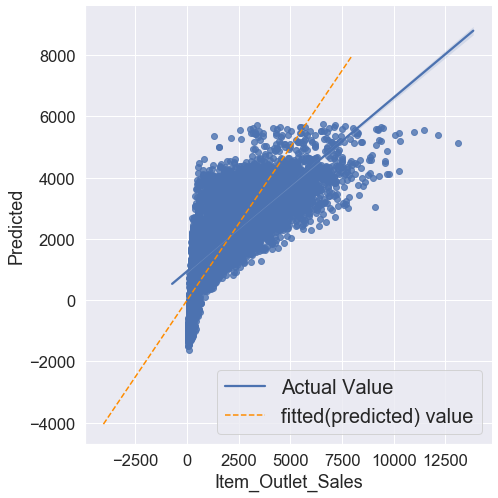

In [136]:
df11=pd.DataFrame(data[:ntrain][label_col],columns=[label_col])
df11['Predicted']=LR.fittedvalues#abs(LR.predict(xtrain[pv_cols]))
df11
#PPM.desc1(df11,2)
sns.lmplot(x=label_col, y='Predicted', data=df11, fit_reg=True,size=7)
line_coords = np.arange(LR.resid.min().min(), LR.resid.max().max())
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')
plt.legend(['Actual Value','fitted(predicted) value'])


Text(0.5, 1.0, 'residual vs predicted/fitted values\n')

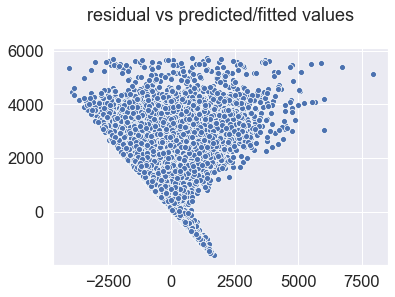

In [137]:
# residual plot between actual value and residuals # LR.resid
sns.scatterplot(LR.resid,LR.fittedvalues)
plt.title('residual vs predicted/fitted values\n')

In [138]:
# Observe above prediction 

# 4. Homoscedasticity/Homogeneity of Variance/Assumption of Equal Variance

    - Homoscedasticity, Data points shows same scatters called fanning effect
    - heterocedasticity, data points shows different scatter called funnel effect/pattern

Linear model does good when there is no heterocedasticity i.e there should not be any trend in the variance of the error terms or residuals; means the variance should be constant.

There are two major things which you should learn:

1. If there exist any pattern (may be, a parabolic shape) in this plot, consider it as signs of non-linearity in the data. It means that the model doesn’t capture non-linear effects.


2. If a funnel shape is evident in the plot, consider it as the signs of non constant variance i.e. heteroskedasticity.


##### 1. scipy statistical test to check zero variance
    Use following test to check equal variance in the data
        1. the Quandt-Goldfeld (no longer used), and 
        2. the Breusch-Pagan and 
        3. White tests (the mainstays).
        4. F statistic in OLS.summary
        Bartlett’s Test
        2. Box’s M Test
        3. Brown-Forsythe Test
        4. Hartley’s Fmax test
        5. Levene’s Test
        
##### 2. Via Residual plots      
    Use residual plot
    We can easily check this by looking at residual vs fitted values plot. If heteroskedasticity exists, the plot would exhibit a funnel shape pattern as shown above. This indicates signs of non linearity in the data which has not been captured by the model. I would highly recommend going through this article for a detailed understanding of assumptions and interpretation of regression plots.
    In order to capture this non-linear effects, we have another type of regression known as polynomial regression. So let us now understand it.

##### 3. 3. Scale Location Plot

##### Solution to Heteroskedasticty:

    The presence of non-constant variance in the error terms results in heteroskedasticity. We can clearly see that the variance of error terms(residuals) is not constant. Generally, non-constant variance arises in presence of outliers or extreme leverage values or non linearity These values get too much weight, thereby disproportionately influencing the model’s performance. When this phenomenon occurs, the confidence interval for out of sample prediction tends to be unrealistically wide or narrow.
    
    To overcome the issue of non-linearity, you can do a non linear transformation of predictors such as log (X), √X or X² transform the dependent variable. To overcome heteroskedasticity, a possible way is to transform the response variable such as log(Y) or √Y. Also, you can use weighted least square method to tackle heteroskedasticity


In [139]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
# het_breuschpagan test is recommended to check homoskedasticity
bpLabels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

# het_white is time taking test to check homoskedasticity
from statsmodels.stats.diagnostic import het_white 

# het_goldfeldquandt test is recommended to check homoskedasticity
gqLabels = ['F statistic', 'p-value']
# het_goldfeldquandt test is recommended to check homoskedasticity

# from  scipy.stats import bartlett
# bartlett(LR.resid,xtrain.values)
print("1. het_breuschpagan-BP test is recommended to check homoskedasticity\n\n\t",
dict(zip(bpLabels,het_breuschpagan(LR.resid,xtrain.values))))

print( "\n2. het_goldfeldquandt-GQ test is recommended to check homoskedasticity\n\n\t",
dict(zip(gqLabels,het_goldfeldquandt(LR.resid,xtrain.values))))

#print(sms.linear_harvey_collier())

1. het_breuschpagan-BP test is recommended to check homoskedasticity

	 {'LM Statistic': 1366.9337055145736, 'LM-Test p-value': 6.641660413465634e-243, 'F-Statistic': 26.064642385018438, 'F-Test p-value': 2.8283287022450806e-269}

2. het_goldfeldquandt-GQ test is recommended to check homoskedasticity

	 {'F statistic': 0.9971840610227011, 'p-value': 0.5363937727718207}


In [140]:
df11=pd.DataFrame(LR.resid,columns=['resid'])

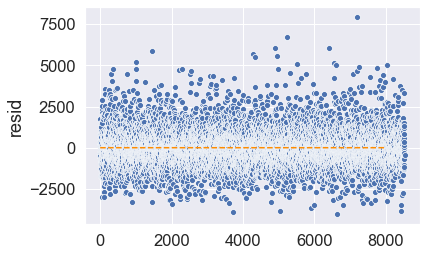

In [141]:
sns.scatterplot(df11.index,df11.resid)
plt.plot(np.repeat(0, LR.resid.max()), color='darkorange', linestyle='--')

------------      LinearREgression     ------------
fit_time =0.03
score_time =0.01
test_r2 =0.56
train_r2 =0.57
test_neg_mean_absolute_error =28.97
train_neg_mean_absolute_error =28.82
test_neg_mean_squared_error =1131.04
train_neg_mean_squared_error =1118.83
overFitt_val =  12.213078572987115


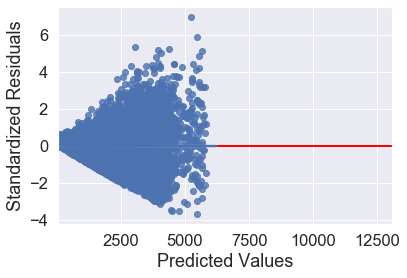

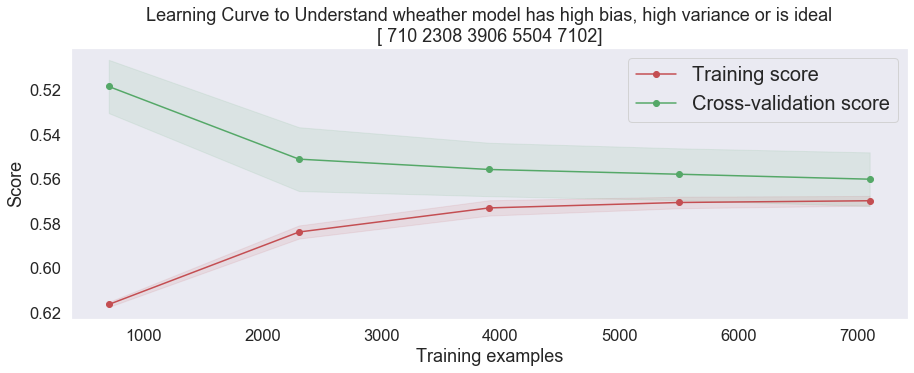

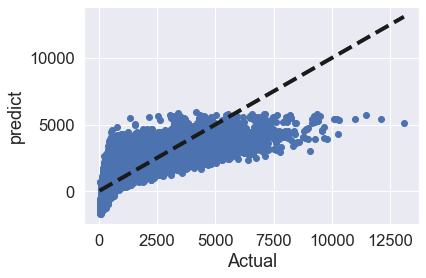

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [142]:


def plotLearningCurve(_model,_ColList,_xtrain,_ytrain,_cv=5):
    from sklearn.model_selection import learning_curve
    _LC_output=learning_curve(_model, _xtrain[_ColList], _ytrain, n_jobs=-1, cv=_cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    _train_sizes, _train_scores, _test_scores =_LC_output[0],_LC_output[1],_LC_output[2]

    _train_scores_mean,_train_scores_std=np.mean(_LC_output[1], axis=1),np.std(_LC_output[1], axis=1)

    _test_scores_mean,_test_scores_std=np.mean(_LC_output[2], axis=1),np.std(_LC_output[2], axis=1)
    plt.figure(figsize=(15,5))
    plt.title("""Learning Curve to Understand wheather model has high bias, high variance or is ideal\n"""+str(_train_sizes))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    print()
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(_train_sizes, _train_scores_mean - _train_scores_std, _train_scores_mean + _train_scores_std, alpha=0.1, color="r")
    plt.fill_between(_train_sizes, _test_scores_mean - _test_scores_std, _test_scores_mean + _test_scores_std, alpha=0.1, color="g")
    #print(train_scores_mean)  
        # plot the average training and test score lines at each training set size
    plt.plot(_train_sizes, _train_scores_mean, 'o-', color="r", label="Training score",)
    plt.plot(_train_sizes, _test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    from sklearn.model_selection import cross_val_predict
    _ptrain=cross_val_predict(_model,_xtrain,_ytrain,cv=_cv)
    fig, ax = plt.subplots()
    ax.scatter(x=_ytrain, y=_ptrain)
    ax.plot([_ytrain.min(), _ytrain.max()], [_ytrain.min(), _ytrain.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('predict')
    plt.show()

# Method 1 - score with all default features in the dataset
LinReg_best=LinearRegression()

#e=PPM.regressionModelfit_CV(LinReg,data[:ntrain].drop(label_col,1).columns, data[:ntrain].drop(label_col,1), data[:ntrain][label_col],'LinearREgression',5)
e=PPM.regressionModelfit_CV(LinReg_best,xtrain.columns, xtrain, ytrain,'LinearREgression',5)

# residual plots
Outputresidual=resilduals_plots(LinReg_best,xtrain.columns,xtrain,ytrain,False)

# learning Curve and 
plotLearningCurve(LinReg_best,xtrain.columns,xtrain,ytrain,6)

LinReg=LinearRegression()
print(LinReg)

In [143]:
#Method 2 OLS Backward feature Elimination 
e=PPM.regressionModelfit_CV(LinReg,pv_cols, xtrain, ytrain,'LinearREgression',5)

------------      LinearREgression     ------------
fit_time =0.08
score_time =0.02
test_r2 =0.56
train_r2 =0.57
test_neg_mean_absolute_error =28.88
train_neg_mean_absolute_error =28.84
test_neg_mean_squared_error =1125.47
train_neg_mean_squared_error =1122.35
overFitt_val =  3.126099557560792


In [144]:
# Method 3 - score with all features select via VIF in the dataset
def getVIF(input_data):
    import statsmodels.formula.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor 
    x_vars=input_data#.drop([dependent_col], axis=1)
    scale = StandardScaler(with_std=False)
    cols = x_vars.columns
    #x_vars1 = pd.DataFrame(scale.fit_transform(x_vars), columns= cols)
    """
    VIF value 
        1 = not correlated.
        Between 1 and 5 = moderately correlated.
        Greater than 5 = highly correlated.
    """
    xvar_names=x_vars.columns
    #cols=[]
    vifL=[]
    variable_IF=[]
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        ##_variable_IF = variance_inflation_factor(x_vars1.values, i) 
        ##variable_IF.append(_variable_IF)
        vif=round(1/(1-rsq),2)
        ##cols.append(xvar_names[i])
        vifL.append(vif)
    return pd.DataFrame({"vif factor": vifL,  "cols":x_vars.columns}).sort_values('vif factor',ascending=False)

VIF_o=getVIF(xtrain)
vif_cols=VIF_o[VIF_o['vif factor']!=VIF_o['vif factor'].max()]['cols'].values
print(len(vif_cols))
LinReg=LinearRegression()
print(LinReg)
e=PPM.regressionModelfit_CV(LinReg,vif_cols, xtrain, ytrain,'LinearREgression',5)


49
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
------------      LinearREgression     ------------
fit_time =0.03
score_time =0.02
test_r2 =0.56
train_r2 =0.57
test_neg_mean_absolute_error =28.94
train_neg_mean_absolute_error =28.83
test_neg_mean_squared_error =1129.29
train_neg_mean_squared_error =1120.26
overFitt_val =  9.03323295187215


In [145]:
# Method 3 - score with selected features from OLS backward Elimation
LinReg=LinearRegression(normalize=True)
print(LinReg)
e=PPM.regressionModelfit_CV(LinReg,pv_cols, xtrain, ytrain,'LinearREgression',9)
LinRegPred=generate_submission_file('n.csv',LinReg,test_org,xtest[pv_cols])
from sklearn.model_selection import learning_curve
LC_output=learning_curve(LinReg, xtrain[pv_cols], xtrain, n_jobs=-1, cv=6, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)
train_sizes, train_scores, test_scores =LC_output[0],LC_output[1],LC_output[2]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
------------      LinearREgression     ------------
fit_time =0.01
score_time =0.01
test_r2 =0.56
train_r2 =0.57
test_neg_mean_absolute_error =28.88
train_neg_mean_absolute_error =28.84
test_neg_mean_squared_error =1125.21
train_neg_mean_squared_error =1122.52
overFitt_val =  2.6930149635334146
Output contain Negative records: 255


In [146]:
# Method 4 - score with selected features after elimination correlated features
corr = data[:ntrain].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.52:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
print(LinReg)
e=PPM.regressionModelfit_CV(LinReg,selected_columns, xtrain, ytrain,'LinearREgression',5)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
------------      LinearREgression     ------------
fit_time =0.02
score_time =0.01
test_r2 =0.53
train_r2 =0.54
test_neg_mean_absolute_error =29.53
train_neg_mean_absolute_error =29.44
test_neg_mean_squared_error =1168.93
train_neg_mean_squared_error =1162.98
overFitt_val =  5.94284700876733


In [147]:
# Method 5 - manual feature selection , by removing high coefficient and low coefficient columns
coef = pd.Series(LinReg_best.coef_,xtrain.columns).sort_values()
coef=coef.abs()#
coeff_cols=coef[(coef<5000) & (coef>700)].index
print(len(coeff_cols))
e=PPM.regressionModelfit_CV(LinReg,coeff_cols, xtrain, ytrain,'LinearREgression',5)
#coef.plot(kind='bar', title='Modal Coefficients',figsize=(25,15))

11
------------      LinearREgression     ------------
fit_time =0.01
score_time =0.01
test_r2 =0.56
train_r2 =0.57
test_neg_mean_absolute_error =28.90
train_neg_mean_absolute_error =28.87
test_neg_mean_squared_error =1127.41
train_neg_mean_squared_error =1125.21
overFitt_val =  2.1995318050069272


In [148]:
PPM.desc1(data[[label_col]+list(coeff_cols)],1,label_col)

dtypes  null_count  total count  \
Item_Outlet_Sales                         float64      5681.0       8523.0   
Item_MRP                                  float64         0.0      14204.0   
ItemAvgMRPmap^2                           float64         0.0      14204.0   
Total_Points_MrpPerUnit_ItemAvgMRPmap     float64         0.0      14204.0   
Outlet_Type_wiseVisibility                  int64         0.0      14204.0   
Item_Visibility_MrpPerUnit_ItemAvgMRPmap  float64         0.0      14204.0   
Item_Visibility_MrpPerUnit^2              float64         0.0      14204.0   
Item_Visibility_ItemAvgMRPmap^2           float64         0.0      14204.0   
Item_Visibility                           float64         0.0      14204.0   
Outlet_Size                                 int64         0.0      14204.0   
Outlet_Type_Supermarket Type2               uint8         0.0      14204.0   
Outlet_Type_Grocery Store                   uint8         0.0      14204.0   

                                          unique_count  missing value ratio  \
Item_Outlet_Sales                               3493.0                 40.0   
Item_MRP                                        8052.0                  0.0   
ItemAvgMRPmap^2                                 1559.0                  0.0   
Total_Points_MrpPerUnit_ItemAvgMRPmap          13851.0                  0.0   
Outlet_Type_wiseVisibility                         4.0                  0.0   
Item_Visibility_MrpPerUnit_ItemAvgMRPmap       13851.0                  0.0   
Item_Visibility_MrpPerUnit^2                   13851.0                  0.0   
Item_Visibility_ItemAvgMRPmap^2                13700.0                  0.0   
Item_Visibility                                13384.0                  0.0   
Outlet_Size                                        3.0                  0.0   
Outlet_Type_Supermarket Type2                      2.0                  0.0   
Outlet_Type_Grocery Store                          2.0                  0.0   

                                          variance of numerics        std  \
Item_Outlet_Sales                                 2.912140e+06    1706.50   
Item_MRP                                          3.854790e+03      62.09   
ItemAvgMRPmap^2                                   9.469370e+04     307.72   
Total_Points_MrpPerUnit_ItemAvgMRPmap             1.274480e+11  356999.00   
Outlet_Type_wiseVisibility                        6.300000e-01       0.80   
Item_Visibility_MrpPerUnit_ItemAvgMRPmap          2.338170e+04     152.91   
Item_Visibility_MrpPerUnit^2                      2.243880e+06    1497.96   
Item_Visibility_ItemAvgMRPmap^2                   6.941200e+02      26.35   
Item_Visibility                                   0.000000e+00       0.05   
Outlet_Size                                       4.600000e-01       0.68   
Outlet_Type_Supermarket Type2                     0.000000e+00       0.00   
Outlet_Type_Grocery Store                         0.000000e+00       0.00   

                                               mean      min         max  \
Item_Outlet_Sales                           2181.29  33.2900    13087.00   
Item_MRP                                     141.00  31.2900      266.89   
ItemAvgMRPmap^2                              228.95   3.0628     2542.78   
Total_Points_MrpPerUnit_ItemAvgMRPmap     220038.00   0.0000  3953590.00   
Outlet_Type_wiseVisibility                     2.80   1.0000        4.00   
Item_Visibility_MrpPerUnit_ItemAvgMRPmap     105.30   0.0000     2035.77   
Item_Visibility_MrpPerUnit^2                 971.87   0.0000    16115.00   
Item_Visibility_ItemAvgMRPmap^2               15.30   0.0000      336.21   
Item_Visibility                                0.07   0.0000        0.32   
Outlet_Size                                    1.61   1.0000        3.00   
Outlet_Type_Supermarket Type2                  0.00   0.0000        0.00   
Outlet_Type_Grocery Store                      0.00   0.0000        0.00   

         

['Outlet_Age'] = R2_SQUARE 0.0024142453202204983


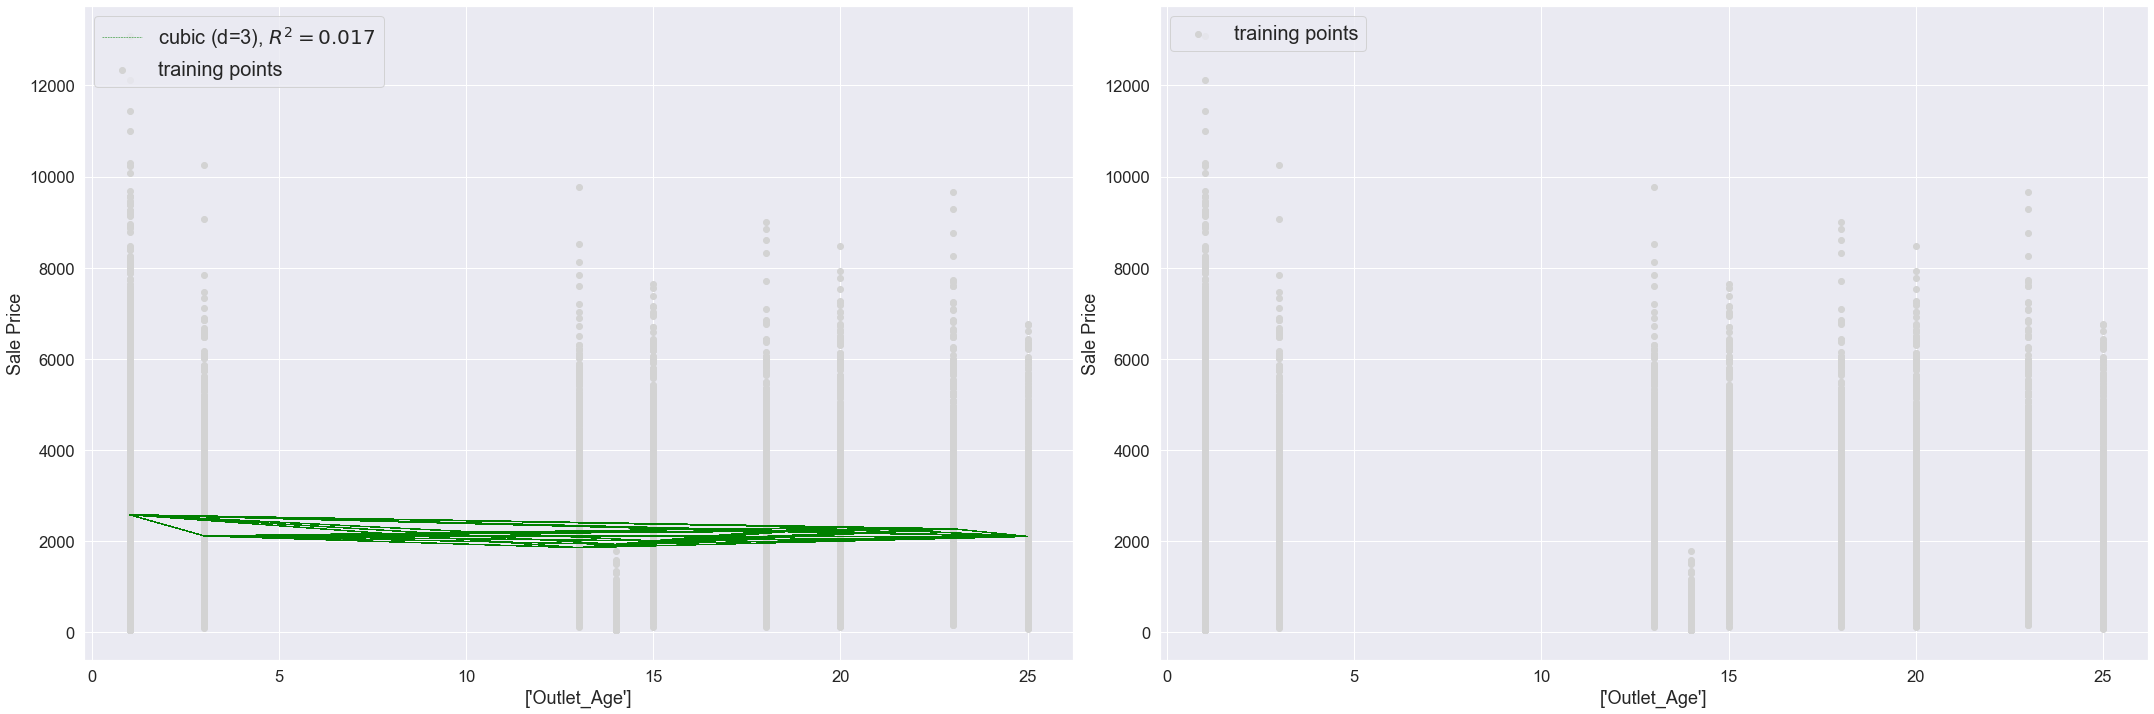

In [149]:
#poly(xtrain,ytrain,'Item_MRP')
poly_cols=['Outlet_Age']
#corr_cols_polyDF=poly(poly_cols,all_data,3)    
for i in range(len(poly_cols)):
     poly(poly_cols[i:i+1],data[:ntrain],3) 

In [150]:
def evaluateColumn_Polynomial(_feature,_label_col,_df,_degree=0,_numCol=3):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
    from sklearn.linear_model import SGDRegressor,LinearRegression,Ridge,Lasso,ElasticNet
   
    # Initializatin of regression models
    regr = LinearRegression()
    def extractData(feat):
        #print("ddd")
        y = _df[_df[_label_col]>0][_label_col]
        X = _df.loc[_df[_label_col]>0, [feat]]
        return (X,y)
    
    def getFeatureR2(_model,feat):
        X,y=extractData(feat)
        _model = _model.fit(X, y)
        y_lin_fit = _model.predict(X)
        #print(r2_score(y, y_lin_fit))
        return r2_score(y, y_lin_fit)


    def getPolyDF(_model,_degree,_feat):
        X,y=extractData(_feat)
        _polyType = PolynomialFeatures(degree=_degree, interaction_only=False, include_bias=False)
        _fittedPoly = _polyType.fit_transform(_df[[feat]])
        target_feature_names = [feature.replace(' ','_') for feature in _polyType.get_feature_names(feat)]
        output_df = pd.DataFrame(_fittedPoly, columns = target_feature_names,  index=_df.index).iloc[:,0:]
        
        _fitted_model = _model.fit(output_df, y)
        _polyPrediction = _model.predict(output_df)
        poly_r2 = r2_score(y, _polyPrediction)
        linear_r2 =getFeatureR2(regr,feat).round(4)
        return ( linear_r2.round(4),poly_r2.round(4),output_df.shape[1])
    _cols=['colname','col_R2_val1','col_poly_R2_val2','diff(val2,val1)','colCount']
    FeaturePoly_r2DF=pd.DataFrame(columns=_cols)

    for feat in _feature:
            r2VAL1,r2VAL2,cnt= getPolyDF(regr,_degree,feat)
            #print(feat,r2VAL1,r2VAL2,r2VAL2-r2VAL1)
            _ser1={'colname':feat,'col_R2_val1':r2VAL1,'col_poly_R2_val2':r2VAL2,'diff(val2,val1)':r2VAL2-r2VAL1,'colCount':cnt}
            FeaturePoly_r2DF=FeaturePoly_r2DF.append(_ser1,ignore_index=True)

    return FeaturePoly_r2DF.sort_values('diff(val2,val1)',ascending=False)

df = ['Outlet_Type_wiseVisibility','Outlet_Identifier_wiseVisibility','MrpPerUnit_ItemAvgMRPmap^2']
poly_cols=['Total_Points', 'Item_Visibility', 'MrpPerUnit', 'ItemAvgMRPmap','Item_MRP']
poly_cols=data.columns
best_Polies=evaluateColumn_Polynomial(poly_cols,label_col,data[:ntrain],2,3).head(5).colname.values
evaluateColumn_Polynomial(list(coeff_cols)+['Outlet_Ranking'],label_col,data[:ntrain],2,3)

colname  col_R2_val1  col_poly_R2_val2  \
4                 Outlet_Type_wiseVisibility       0.0702            0.2209   
9      Total_Points_MrpPerUnit_ItemAvgMRPmap       0.0706            0.1202   
10                           ItemAvgMRPmap^2       0.0918            0.1304   
8   Item_Visibility_MrpPerUnit_ItemAvgMRPmap       0.0418            0.0708   
5            Item_Visibility_ItemAvgMRPmap^2       0.0334            0.0596   
0               Item_Visibility_MrpPerUnit^2       0.0345            0.0531   
11                            Outlet_Ranking       0.1683            0.1746   
7                            Item_Visibility       0.0099            0.0113   
3                                Outlet_Size       0.0037            0.0044   
6                                   Item_MRP       0.3221            0.3222   
1              Outlet_Type_Supermarket Type2       0.0014            0.0014   
2                  Outlet_Type_Grocery Store       0.1695            0.1695   

    diff(val2,val1) colCount  
4            0.1507        2  
9            0.0496        2  
10           0.0386        2  
8            0.0290        2  
5            0.0262        2  
0            0.0186        2  
11           0.0063        2  
7            0.0014        2  
3            0.0007        2  
6            0.0001        2  
1            0.0000        2  
2            0.0000        2

In [151]:
# df=data[:ntrain][[label_col]+list(best_Polies)]
# df['I_1']=df['MrpPerUnit_ItemAvgMRPmap'] + df['Total_Points_ItemAvgMRPmap^2']
# df['I_4']=df['Outlet_Type_wiseVisibility'] / df['Total_Points_ItemAvgMRPmap^2']
# df['I_2']=df['Outlet_Identifier_wiseVisibility'] / df['Total_Points_ItemAvgMRPmap^2']
# #df['I_3']=df['MrpPerUnit_ItemAvgMRPmap'] + df['Total_Points_ItemAvgMRPmap^2']
# PPM.desc1(df,1,label_col)
# evaluateColumn_Polynomial(df.columns,label_col,df,2,3)

In [682]:
def getPolyR2(_feature,_label_col,_df,_degree=3,_retDF=0):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
    from sklearn.linear_model import SGDRegressor,LinearRegression,Ridge,Lasso,ElasticNet
   
    # Initializatin of regression models
    regr = LinearRegression()
    def extractData(feat):
        #print("ddd")
        y = _df[_df[_label_col]>0][_label_col]
        X = _df.loc[_df[_label_col]>0, feat]
        return (X,y)
    
    def getFeatureR2(_model,feat):
        X,y=extractData(feat)
        _model = _model.fit(X, y)
        y_lin_fit = _model.predict(X)
        #print(r2_score(y, y_lin_fit))
        print("----")
        return r2_score(y, y_lin_fit)
    def getPolyDF(_model,_degree,_feat):
        X,y=extractData(_feat)
        _polyType = PolynomialFeatures(degree=_degree, interaction_only=False, include_bias=False)
        _fittedPoly = _polyType.fit_transform(_df[_feat])
        _polyType.get_feature_names(_feat)
        target_feature_names = [feature.replace(' ','_') for feature in _polyType.get_feature_names(_feat)]
        output_df = pd.DataFrame(_fittedPoly, columns = target_feature_names,  index=_df.index).iloc[:, 0:]
        if _retDF==1:
            return output_df
        
        _fitted_model = _model.fit(output_df, y)
        _polyPrediction = _model.predict(output_df)
        poly_r2 = r2_score(y, _polyPrediction)
        linear_r2 =getFeatureR2(regr,_feat).round(4)
        retVal=( linear_r2.round(4),poly_r2.round(4),output_df.shape[1])
        #print(retVal)
        return retVal
    return getPolyDF(regr,_degree,_feature)
    #print(getFeatureR2(regr,_feature))


In [683]:
myCol=set(['Outlet_Ranking','Item_Weight','Item_MRP','Outlet_Type_Grocery Store']).union(set(coeff_cols))
df=data[:ntrain][[label_col]+list(myCol)]

PPM.desc1(df,1,label_col)
baseR2,polyR2,polyDF=getPolyR2(list(myCol),label_col,df,2)
baseR2,polyR2,polyDF

----


(0.5664, 0.6123, 104)

In [684]:
summydf=PPM.desc1(data[:ntrain],1,label_col)
intCols=data.columns[data.dtypes == 'int64']
intdf=data[:ntrain][[label_col,'Item_MRP']+list(intCols)]
evaluateColumn_Polynomial(intdf.drop(label_col,1).columns,label_col,intdf,9,)[['col_R2_val1','col_poly_R2_val2','diff(val2,val1)']].sum(0)
#getRegressionR2(intdf.drop(label_col,1).columns,label_col,intdf)
baseR2,polyR2,polyDF=getPolyR2(intdf.drop(label_col,1).columns,label_col,intdf,2)
baseR2,polyR2,polyDF

----


(0.5348, 0.6028, 44)

In [685]:
list(set(coeff_cols).union(set(intCols))) 

['Item_Visibility',
 'Outlet_Type_Supermarket Type2',
 'Item_Visibility_ItemAvgMRPmap^2',
 'Item_MRP',
 'Item_Visibility_MrpPerUnit_ItemAvgMRPmap',
 'Outlet_Identifier_wiseVisibility',
 'Outlet_Ranking',
 'Outlet_location_type_wiseVisibility',
 'ItemAvgMRPmap^2',
 'Outlet_Age',
 'Outlet_Type_wiseVisibility',
 'Outlet_Type_Grocery Store',
 'Outlet_Size',
 'Total_Points_MrpPerUnit_ItemAvgMRPmap',
 'Item_Visibility_MrpPerUnit^2',
 'Item_Fat_Content']

In [686]:
summydf=PPM.desc1(data[:ntrain],1,label_col)
intCols=data.columns[data.dtypes == 'int64']
intCols=list(set(coeff_cols).union(set(intCols)))
intdf=data[:ntrain][[label_col]+list(intCols)]
#evaluateColumn_Polynomial(intdf.drop(label_col,1).columns,label_col,intdf,9,)[['col_R2_val1','col_poly_R2_val2','diff(val2,val1)']].sum(0)
#getRegressionR2(intdf.drop(label_col,1).columns,label_col,intdf)
iCol=intdf.drop(label_col,1).columns#[9:]
print(len(iCol))
baseR2,polyR2,polyDF=getPolyR2(iCol,label_col,intdf,2)
baseR2,polyR2,polyDF

16
----


(0.5667, 0.6136, 152)

In [687]:
polyDF=getPolyR2(iCol,label_col,data,2,1)
polyDF.shape

(14204, 152)

In [688]:
# generate_all_model_score(xtrain[pv_cols],ytrain,xtest[pv_cols],'with_normal')
# olstab=pd.DataFrame({ "colname": LR.params.index,
# "coeff": LR.params.values.round(4),
# "tval":LR.tvalues.values.round(4),
# "pval":LR.pvalues.values.round(4)})
# olstab.head()

In [689]:
e=PPM.regressionModelfit_CV(LinReg,polyDF.columns, polyDF[:ntrain], ytrain,'LinearREgression',5)
LinReg.fit(polyDF[:ntrain],ytrain)
#LinReg.predict(polyDF[ntrain:])
generate_submission_file('n1.csv',LinReg,test_org,polyDF[ntrain:])

------------      LinearREgression     ------------
fit_time =0.09
score_time =0.01
test_r2 =0.60
train_r2 =0.62
test_neg_mean_absolute_error =27.56
train_neg_mean_absolute_error =27.26
test_neg_mean_squared_error =1084.54
train_neg_mean_squared_error =1057.94
overFitt_val =  26.59425434657146
Output contain Negative records: 16


Item_Identifier Outlet_Identifier  Item_Outlet_Sales
78             DRP47            OUT019         -36.620423
242            FDJ10            OUT010        -411.858725
474            FDV28            OUT019        -275.247573
930            DRC01            OUT010         -40.870839
1191           FDB03            OUT019       -1079.696798
1616           DRF51            OUT010         -23.746240
2179           FDQ47            OUT019        -242.790328
2609           NCE31            OUT019        -315.830907
3231           FDX10            OUT019         -14.812302
3378           FDJ10            OUT019         -69.479262
3970           DRF01            OUT010        -675.285664
4250           FDY52            OUT010          -7.687506
4317           FDF09            OUT010        -123.202554
4421           FDE44            OUT019         -51.192464
4741           FDD51            OUT010         -81.233333
4772           FDK36            OUT010         -64.585244

In [690]:
# Bagging of Linear Regressor 
from sklearn.ensemble import BaggingRegressor
BgingRegr = BaggingRegressor(base_estimator=LinReg, n_estimators=1000, random_state=0)
BgingRegr.fit(polyDF[:ntrain], ytrain)
ptrain=BgingRegr.predict(polyDF[:ntrain])
rmse=np.sqrt(np.mean((ptrain - ytrain)*(ptrain - ytrain)))
print("\nBagging RMSE-",rmse)
baggingRegressionSubmissions=generate_submission_file('n.csv',BgingRegr,test_org,polyDF[ntrain:])
#e=PPM.regressionModelfit_CV(BgingRegr,polyDF.columns, polyDF[:ntrain], ytrain,'BaggingLinearRegression',5)



Bagging RMSE- 1060.5353205815275
Output contain Negative records: 16


In [691]:
e=generate_submission_file('n.csv',BgingRegr,test_org,polyDF[ntrain:])

Output contain Negative records: 16


In [692]:
dupCol=[]

print("before col len",len(polyDF.columns))
for i in polyDF.columns:
    if i in dupCol:
        print(i)
    dupCol.append(i)
dupColDF=polyDF['Item_Visibility_ItemAvgMRPmap^2'].iloc[:,1:]
polyDF=polyDF.drop('Item_Visibility_ItemAvgMRPmap^2',1)
polyDF['Item_Visibility_ItemAvgMRPmap^2']=dupColDF
print("after col len",len(polyDF.columns))


before col len 152
Item_Visibility_ItemAvgMRPmap^2
after col len 151


# Decision Tree Tuning

In [693]:
# I prefer Manual tuning Dectison tree hypertuning parameter

In [694]:
paramDT={     "criterion": "mse",
              "min_samples_split": 20,#[i for i in range(3,500,10)],
              "max_depth": 20,# [i for i in range(2,,3)],
             "min_samples_leaf": 10,#[i for i in range(1,500,20)],
              "max_leaf_nodes": 300,#[i for i in range(2,100,20)],
              "max_features":42# ['auto', 'sqrt', 'log2'],
              }
dt_DefaultModel= DecisionTreeRegressor(**paramDT)
e=PPM.regressionModelfit_CV(dt_DefaultModel,xtrain.columns, xtrain, ytrain,'DeciTree',5)


------------      DeciTree     ------------
fit_time =0.19
score_time =0.01
test_r2 =0.48
train_r2 =0.73
test_neg_mean_absolute_error =29.08
train_neg_mean_absolute_error =24.91
test_neg_mean_squared_error =1231.10
train_neg_mean_squared_error =878.87
overFitt_val =  352.2264170822052


In [695]:
paramDT={     "criterion": "mse",
              "min_samples_split": 200,#[i for i in range(3,500,10)],
              "max_depth": 12,# [i for i in range(2,,3)],
             "min_samples_leaf": 40,#[i for i in range(1,500,20)],
              "max_leaf_nodes": 100,#[i for i in range(2,100,20)],
              "max_features":150# ['auto', 'sqrt', 'log2'],

              }
paramDT2={     "criterion": "mse",
              "min_samples_split": 500,#[i for i in range(3,500,10)],
              "max_depth": 8,# [i for i in range(2,,3)],
              "min_samples_leaf": 6,#[i for i in range(1,500,20)],
              "max_leaf_nodes": 100,#[i for i in range(2,100,20)],
              "max_features":'auto'# ['auto', 'sqrt', 'log2'],


              }
#print(goodcols)
dt_DefaultModel= DecisionTreeRegressor(**paramDT2,random_state=49)
e=PPM.regressionModelfit_CV(dt_DefaultModel,polyDF.columns, polyDF[:ntrain], ytrain,'LinearREgression',2)
#dt_DefaultModel.fit(polyDF[:ntrain],ytrain)
dtPred=generate_submission_file('n1.csv',dt_DefaultModel,test_org,polyDF[ntrain:])


------------      LinearREgression     ------------
fit_time =0.19
score_time =0.01
test_r2 =0.56
train_r2 =0.59
test_neg_mean_absolute_error =28.17
train_neg_mean_absolute_error =27.75
test_neg_mean_squared_error =1128.30
train_neg_mean_squared_error =1092.86
overFitt_val =  35.43597762773538


# RandomizedSearchCV for Decision Tree ( i having used it )

In [172]:
# print(xtrain.shape)

# # 6 Decision_Tree_param_grid 
# Decision_Tree_param_grid = {"criterion": ["mse"],
#               "max_depth": [6],#[i for i in range(1,20,1)],
#               "max_features":[57],#['auto', 'sqrt', 'log2'], 
#               "min_samples_split":[i for i in range(3,500,10)],#[180],
#               "min_samples_leaf": [i for i in range(1,50,2)],
#               "max_leaf_nodes": [i for i in range(2,100,2)],
              
#               }
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# dt_model= DecisionTreeRegressor(random_state=46)

# dt_esti = RandomizedSearchCV(estimator = dt_model, param_distributions = Decision_Tree_param_grid,
#                              n_iter = 100, 
#                             cv = 6,verbose=0, random_state=42, n_jobs = -1,scoring='neg_mean_squared_error')
# dt_esti.fit(xtrain,ytrain)
# print(dt_esti.best_params_,"\n\nRMSE-",np.sqrt(dt_esti.best_score_*-1))
# dt_param=dt_esti.best_params_
# model_RFE= DecisionTreeRegressor(**dt_param)
# e=PPM.regressionModelfit_CV(model_RFE,xtrain.columns, xtrain, ytrain,'DeciTree',5)
# generate_submission_file('n.csv',model_RFE,test_org,xtest)

# high variance and Overfitting is the curse in Decision tree

    - Random Forest Vs BaggingRegressor
    The fundamental difference is that in Random forests, only a subset of features are selected at random out of the total and the best split feature from the subset is used to split each node in a tree, unlike in bagging where all features are considered for splitting a node.
    
    The second Major difference is that the prediction from diffrent estimators in Random forest are less correlated  ( reason you know - because the each estimator is using different set of feature for node split) while prediction from different estimator in BaggingRegressor is correlated ( reason you know - because the each estimator is same set of features for node split) 
    
    These two are Bagging(BootStrap aggregation) used to address the High variance or overfitting issue of the Decision tree (as you know Decision Tree always overfit with default parameter that allows the individual DT model to go deep without pruning)

### 1. Address high variance in decision tree using bagging regressor


overfitting happens when our model captures the noise along with the underlying pattern in data. It happens when we train our model a lot over noisy dataset. These models have low bias and high variance. These models are very complex like Decision trees which are prone to overfitting

The larger the variance, the more sensitive are the predictions for x to small changes in the training set. 

In [173]:
# Bagging regressor On top of manual tuned decision tree

In [174]:
from sklearn.ensemble import BaggingRegressor
BgingRegr = BaggingRegressor(base_estimator=dt_DefaultModel, n_estimators=1500, random_state=0)
BgingRegr.fit(polyDF[:ntrain], ytrain)
ptrain=BgingRegr.predict(polyDF[:ntrain])
rmse=np.sqrt(np.mean((ptrain - ytrain)*(ptrain - ytrain)))
print("\nBagging RMSE-",rmse)
#e=PPM.regressionModelfit_CV(BgingRegr,xtrain.columns, xtrain, ytrain,'DeciTree',5)
baggPred=generate_submission_file('n1.csv',BgingRegr,test_org,polyDF[ntrain:])
[baggPred,dtPred]



Bagging RMSE- 1064.2174877321377


[array([1700.32998629, 1482.33427921,  491.93868241, ..., 1739.97058574,
        4039.49210958, 1334.23422041]),
 array([1693.57637063, 1330.7066481 ,  569.31422765, ..., 1764.34183927,
        4080.42188   , 1270.26630376])]

In [175]:
# from sklearn.ensemble import BaggingRegressor
# BgingRegr = BaggingRegressor(base_estimator=model_RFE, n_estimators=300, random_state=0)
# BgingRegr.fit(xtrain, ytrain)
# ptrain=BgingRegr.predict(xtrain)
# rmse=np.sqrt(np.mean((ptrain - ytrain)*(ptrain - ytrain)))
# print("\nBagging RMSE-",rmse)
# e=PPM.regressionModelfit_CV(BgingRegr,xtrain.columns, xtrain, ytrain,'DeciTree',5)


# Random Forest

1. The Random Forest algorithm does overfit without changing the bias
Adding more tree will reduce the variance

2. The single decision tree is very sensitive to data variations. It can easily overfit to noise in the data. The Random Forest with only one tree will overfit to data as well because it is the same as a single decision tree. When we add trees to the Random Forest then the tendency to overfitting should decrease (thanks to bagging and random feature selection). However, the generalization error will not go to zero.

3. A random forest is like a black box and works as mentioned in above answer. It's a forest you can build and control. You can specify the number of trees you want in your forest(n_estimators) and also you can specify max num of features to be used in each tree. But you cannot control the randomness, you cannot control which feature is part of which tree in the forest, you cannot control which data point is part of which tree. Accuracy keeps increasing as you increase the number of trees, but becomes constant at certain point.

#### Advantages of Random Forest
1. One of benefits of Random forest which excites me most is, the power of handle large data set with higher dimensionality. It can handle thousands of input variables and identify most significant variables so it is considered as one of the dimensionality reduction methods. Further, the model outputs Importance of variable, which can be a very handy feature (on some random data set).

2. It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.

3. It has methods for balancing errors in data sets where classes are imbalanced.

4. The capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection.

5. Random Forest involves sampling of the input data with replacement called as bootstrap sampling. Here one third of the data is not used for training and can be used to testing. These are called the out of bag samples. Error estimated on these out of bag samples is known as out of bag error. Study of error estimates by Out of bag, gives evidence to show that the out-of-bag estimate is as accurate as using a test set of the same size as the training set. Therefore, using the out-of-bag error estimate removes the need for a set aside test set.
 

#### Disadvantages of Random Forest
    It surely does a good job at classification but not as good as for regression problem as it does not give precise continuous nature predictions. In case of regression, it doesn’t predict beyond the range in the training data, and that they may over-fit data sets that are particularly noisy.
    Random Forest can feel like a black box approach for statistical modelers – you have very little control on what the model does. You can at best – try different parameters and random seeds!

In [176]:
#got 1150 score

In [177]:
paramDT1={     "criterion": "mse",
              "min_samples_split": 250,#[i for i in range(3,500,10)],
              "max_depth": 10,# [i for i in range(2,,3)],
              "min_samples_leaf": 7,#[i for i in range(1,500,20)],
              "max_leaf_nodes": 130,#[i for i in range(2,100,20)],
              "max_features":'auto',# ['auto', 'sqrt', 'log2'],
              "n_estimators":100

              }

rf= RandomForestRegressor(**paramDT1,random_state=45)

rf.fit(polyDF[:ntrain], ytrain)
ptrain=rf.predict(polyDF[:ntrain])
rmse=np.sqrt(np.mean((ptrain - ytrain)*(ptrain - ytrain)))
print("\nBagging RMSE-",rmse)
rfPred=generate_submission_file('n2.csv',rf,test_org,polyDF[ntrain:])
#e=PPM.regressionModelfit_CV(rf,polyDF.columns, polyDF[:ntrain], ytrain,'randomForest',5)
# submission score is 1157



Bagging RMSE- 1037.1732432997887


##### {'criterion': 'mse', 'min_samples_split': 200, 'max_depth': 12, 'min_samples_leaf': 40, 'max_leaf_nodes': 100,
 'max_features': 150, 'n_estimators': 5}
fit_time =86.27
score_time =1.48
test_r2 =0.60
train_r2 =0.66
test_neg_mean_absolute_error =27.50
train_neg_mean_absolute_error =26.38
test_neg_mean_squared_error =1083.29
train_neg_mean_squared_error =995.74

Total Columns= 151
Number of selected good_columns= 106  with threshold= 0.0001

Bagging RMSE- 1045.2590462233165


<Figure size 1440x1080 with 0 Axes>

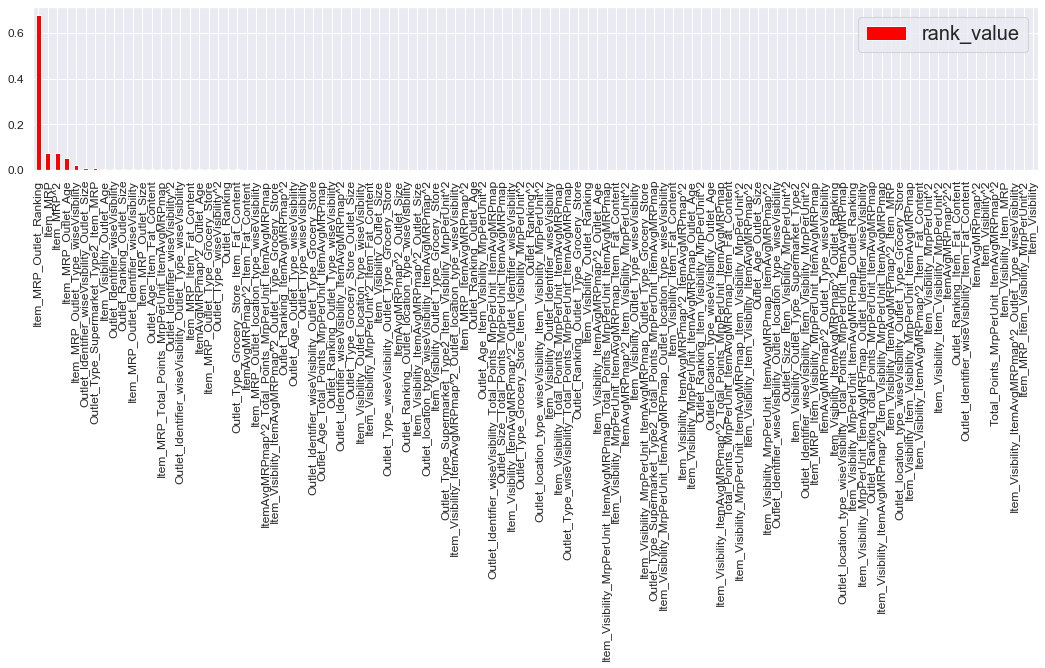

In [178]:
imp_feature=rf.feature_importances_

def featureImportance_BAR(_imp_features,_df1,rank_threshold=0.0001):
    _df=pd.DataFrame({'rank_value':imp_feature,'feature_name':_df1.columns},index=_df1.columns).sort_values('rank_value',ascending=False)
    _df=_df[_df['rank_value']>rank_threshold]
    fig=plt.figure(figsize=(20,15))
    #print(_df.tail())
    _df.plot.bar(figsize=(18,3),fontsize=12,color='red')
    print('Total Columns=',_df1.shape[1])
    print('Number of selected good_columns=',len(_df)," with threshold=",rank_threshold)
    return _df.index


paramDT1={     "criterion": "mse",
              "min_samples_split": 300,#[i for i in range(3,500,10)],
              "max_depth": 10,# [i for i in range(2,,3)],
              "min_samples_leaf": 7,#[i for i in range(1,500,20)],
              "max_leaf_nodes": 130,#[i for i in range(2,100,20)],
              "max_features":'auto',# ['auto', 'sqrt', 'log2'],
              "n_estimators":10

              }

rf2= RandomForestRegressor(**paramDT1,random_state=45)
goodcols=featureImportance_BAR(imp_feature,polyDF[:ntrain],0.0001)
rf2.fit(polyDF[:ntrain][goodcols], ytrain)
ptrain=rf2.predict(polyDF[:ntrain][goodcols])
rmse=np.sqrt(np.mean((ptrain - ytrain)*(ptrain - ytrain)))
print("\nBagging RMSE-",rmse)
rfPred=generate_submission_file('n2.csv',rf2,test_org,polyDF[ntrain:][goodcols])
#e=PPM.regressionModelfit_CV(rf2,goodcols, polyDF[:ntrain], ytrain,'randomForest',5)


In [179]:
# Randamization parameter tuning

# # # 7.Random_forest_random_grid
# rf= RandomForestRegressor(random_state=46)
# Random_forest_random_grid = {
#              "criterion": ["mse"],
#               "min_samples_split": [2,4,7,9],
#               "max_depth":  [2,5,10,14],
#               "min_samples_leaf": [10,20,50,70],
#               "max_leaf_nodes": [2,5,10],
#               "max_features": ['auto']#, 'sqrt', 'log2'],
#               "n_estimators":[10,30,60]
#                }
# rf_random11 = RandomizedSearchCV(estimator = rf, param_distributions = Random_forest_random_grid, n_iter = 150,
#                                cv = 7,
#                                verbose=0, random_state=42, n_jobs = -1,scoring='neg_mean_squared_error')
# #model_type_wise_hyperParams_grid_dict['random_forest_regressor']=Random_forest_random_grid
# rf_random11.fit(polyDF[:ntrain],ytrain)
# xfb_Bestmodel=rf_random.best_estimator_
# e2=PPM.regressionModelfit_CV(xfb_Bestmodel,goodcols[:20], xtrain, ytrain,'xgb',6)
# # from sklearn.metrics import mean_squared_error
# imp_feature=xfb_Bestmodel.feature_importances_

# def featureImportance_BAR(_imp_features,_df1):
#     _df=pd.DataFrame({'rank_value':imp_feature,'feature_name':_df1.columns},index=_df1.columns).sort_values('rank_value',ascending=False)
#     _df=_df[_df['rank_value']>0.0001]
#     fig=plt.figure(figsize=(20,15))
#     #print(_df.tail())
#     _df.plot.bar(figsize=(18,3),fontsize=12,color='red')
#     print('Total Columns=',len(_df1))
#     print('Number_of_good_columns=',len(_df))
#     return _df.index
# goodcols=featureImportance_BAR(imp_feature,xtrain)
# #generate_submission_file('n.csv',rf_estim,test_org,xtest)
# goodcols


# xGB boost


XGBoost-XGBM/Light GBM are two open source implementation of the GBDT concept(scikit-learn has another version of GBDT algorithm, but XGBoost is faster and many other technical advantages.)

#####  how xgb boosting works

In order to train the model, we need to define the  ###  --- ['objective function'] --- ### to measure how well the model fit the training data.

A salient characteristic of objective functions is that they consist two parts: 
    - training loss function or gradient coefficient that is optimized with each subsequent model building 
    - regularization term:

object function is the sum of training loss function and regurlarisation function

Where 
1. 𝐿 is the training loss function,  A common choice of 𝐿 is the mean squared error,
2. Ω is the regularization term.

Xgbm is additive algorithm that train Week learners or estimators with low bias and high variance and its predicton pass on to next subsequent week learning is build in order to minimize loss function (like MSE) or regularize the loss function and its predicton are added to previous week learner and it repeats with each iteration until  minumam and best coeffiects and that how it forms strong learner.

The important thing to note here is that computing the best split/coefficients requires the model to go through various splits and compute the criterion for each split. There is no analytical solution for determining the best split at each stage.

Unlike Adaboost where we are assigning or increments the weight of incorrect predictions instead Gradient descent tries to optimize the cost function.

Gradient boosting helps in predicting the optimal gradient for the additive model, unlike classical gradient descent techniques which reduce error in the output at each iteration.

#### What is Boosting Algorithm 

As you know, a single decision tree is prone to overfitting and is unlikely to generalize well.
On other hand, if we reduce the flexibility of a decision tree, such as by limiting its depth, but those methods then cause the decision tree to underfit. To address both these limitation we use boosting.

It’s a boosting algorithm in which their bases models (learner/estimator) are of same type and are built sequentially and each subsequent model is built over the errors of previous learner in order to reduces error and correct the predictions.


The each subsequent model performance is boosted because it works on the mistakes of the previous model and try to understand the pattern of error.


The base learners in boosting are weak learners in which the bias is high, and the predictive power is just a tad better than random guessing. Each of these weak learners contributes some vital information for prediction, enabling the boosting technique to produce a strong learner by effectively combining these weak learners. The final strong learner brings down both the bias and the variance.

In contrast to bagging techniques like Random Forest, in which trees are grown to their maximum extent, boosting makes use of trees with fewer splits or short trees

###### When to use a boosted trees model?
Different kinds of models have different advantages. The boosted trees model is very good at handling tabular data with numerical features, or categorical features with fewer than hundreds of categories. Unlike linear models, the boosted trees model are able to capture non-linear interaction between the features and the target.

##### restrication on tree based model?
One important note is that tree based models are not designed to work with very sparse features. When dealing with sparse input data (e.g. categorical features with large dimension), we can either pre-process the sparse features to generate numerical statistics, or switch to a linear model, which is better suited for such scenarios.

###### ADA vs GBM
ADA boost the performance by providing higher wieght to wrong predicton while GBM boost the perform bossting by optimizing the cost function

Both Gradient boost and Ada boost work with decision trees however, Trees in Gradient Boost are larger than trees in Ada Boost.

Both Gradient boost and Ada boost scales decision trees however, Gradient boost scales all trees by same amount unlike Ada boost.

GBM  offers 
    Better accuracy,
    Less pre-processing,
    Higher flexibility with many hyper-parameter and loss functions,
    handles the missing data on its own and does not require us to handle it explicitly


Note: GBM focus on cost function that is optimised on residuals unlike linear regression which focus on loss function on residual square (that usually offers less control and does not essentially correspond with real world applications.)




# Note on Xgboosting Tuning

Xgbm also called additive model as it add weak learners to minimize the loss function.

1. max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.

2. max_depth: Determines how deeply each tree is allowed to grow during any boosting round. [default=6]

2. n_estimators:
    xgb.XGBRegressor is the xgb implementation in scikit , So num_boost_round and n_estimators are same
    its low value cause underfitting, high value cause over fitting-  Typical values range from 100-1000
3. early_stopping_rounds: 
    It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating ideal value early_stopping_rounds = 5

4. Learning rate-important trick: also called shrinkage or weighting factor. As we know, xgboost lineup week unit length trees(stump) in a sequence and it pass on the predicted residual from one to next tree in order the correct the prediction. learning rate value should be less than 0.3 is considered good

its common called Step size shrinkag.

Instead of getting predictions by simply adding up the predictions from each component model, we will multiply the predictions from each model by a small number before adding them in. This means each tree we add to the ensemble helps us less. In practice, this reduces the model's propensity to overfit.

In general small value of learning rate and large value of n_estimater give you optimal model

5. n_jobs : to parallelize model 

6. colsample_bytree: Percentage of features used per tree. High value can lead to overfitting. [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1

7. subsample: Percentage of samples used per tree. Low value can lead to underfitting.[default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1


9 min_child_weight: Minimum sum of instance weight (hessian) needed in a child. The larger min_child_weight is, the more conservative the algorithm will be. [default=1]

10 reg_alpha: L1 regularization term on weights. Increasing this value will make model more conservative.[default=0]
    L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented

11 reg_lambda: L2 regularization term on weights. Increasing this value will make model more conservative.[default=1]
    L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.

12 gamma: Controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits.

13 silent: 0 means printing running messages, 1 means silent mode.[default=0]

14 nthread: Number of parallel threads used to run XGBoost[If -1, uses maximum threads available on the system]

15. random_state: Random number seed. (replaces seed)

15. Increasing eta, descreases the number of round, hence makes computation faster but does not make reaching the best optimum.

 Decreasing eta , increases the number of round,hence makes computation slower but makes easier reaching the best optimum.
 
 
# Guide lines for GradientBoosting Regressor
1. Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems


2. Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.

3. Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

4. Lower the learning rate and increase the estimators proportionally to get more robust models.

# Important parameters to tune
Although there are many hyperparameters to tune, perhaps the most important are as follows:

- The number of trees or estimators in the model.
- The learning rate of the model.
- The row and column sampling rate for stochastic models.
- The maximum tree depth.
- The minimum tree weight.
- The regularization terms alpha and lambda.

In [621]:
yytrain.shape

(5966,)

In [622]:
xxtrain, xxVali, yytrain, yyVali = train_test_split(polyDF[:ntrain],ytrain , test_size=0.30, random_state=101)
xxtrain.shape, xxVali.shape, yytrain.shape, yyVali.shape

((5966, 151), (2557, 151), (5966,), (2557,))

In [900]:
import xgboost as xgb
from xgboost import XGBRegressor,plot_importance

param_grid2 = {
    # Parameters that we are going to tune.
    'silent':1,
    #'eta':1111111111,  # use less
    'njobs':-1,
   # 'subsample':0.5,
    # Other parameters
   'early_stopping_rounds':3,
   'n_estimators' : 1000,#135,
   'learning_rate': .07, # negativity correlated with n_estimators
    
    #'objective': 'reg:linear',#'reg:tweedie','reg:gamma'],
    'max_depth' :11,    
    "min_child_weight" : 255,
    #'max_leaf_nodes': 20  # enabling this will disable max_depth
    "reg_lambda":3000,  # ridge
    "reg_alpha":3000,  # lasso
    #"gamma" : 0.01,  #impactless
    "colsample_bytree" : 1,  # max features,
    "seed":45   
}
XGBReg_estimator = xgb.XGBRegressor(**param_grid2,random_state=25)
XGBReg_estimator.fit(xxtrain, yytrain)
#rf2.fit(polyDF[:ntrain][goodcols], ytrain)
ptrain=XGBReg_estimator.predict(xxtrain)
pVali=XGBReg_estimator.predict(xxVali)
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
xgbPred=generate_submission_file('n2.csv',XGBReg_estimator,test_org,polyDF[ntrain:])
imp_feature=XGBReg_estimator.feature_importances_





train R2: 0.6711704971436745 
Test R2: 0.5943234221715936

train rmse: 993.8979628929648 
Test Rmse: 1043.9809846978096


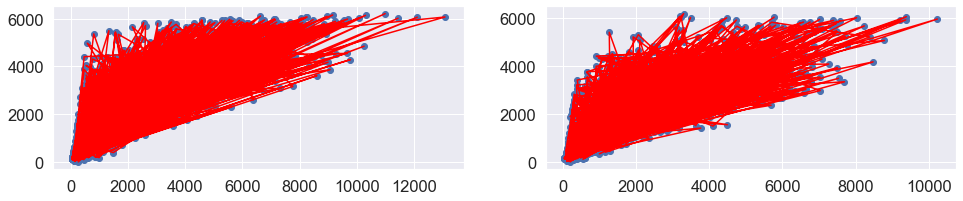

In [901]:
#e=PPM.regressionModelfit_CV(XGBReg_estimator,polyDF[ntrain:].columns, polyDF[:ntrain], ytrain,'xgb',2)
plt.figure(figsize=(25,3))
fig = plt.subplot(131)
plt.scatter(yytrain, ptrain)
plt.plot(yytrain, ptrain,color='red')
fig = plt.subplot(132)
plt.scatter(yyVali, pVali)
plt.plot(yyVali, pVali,color='red')


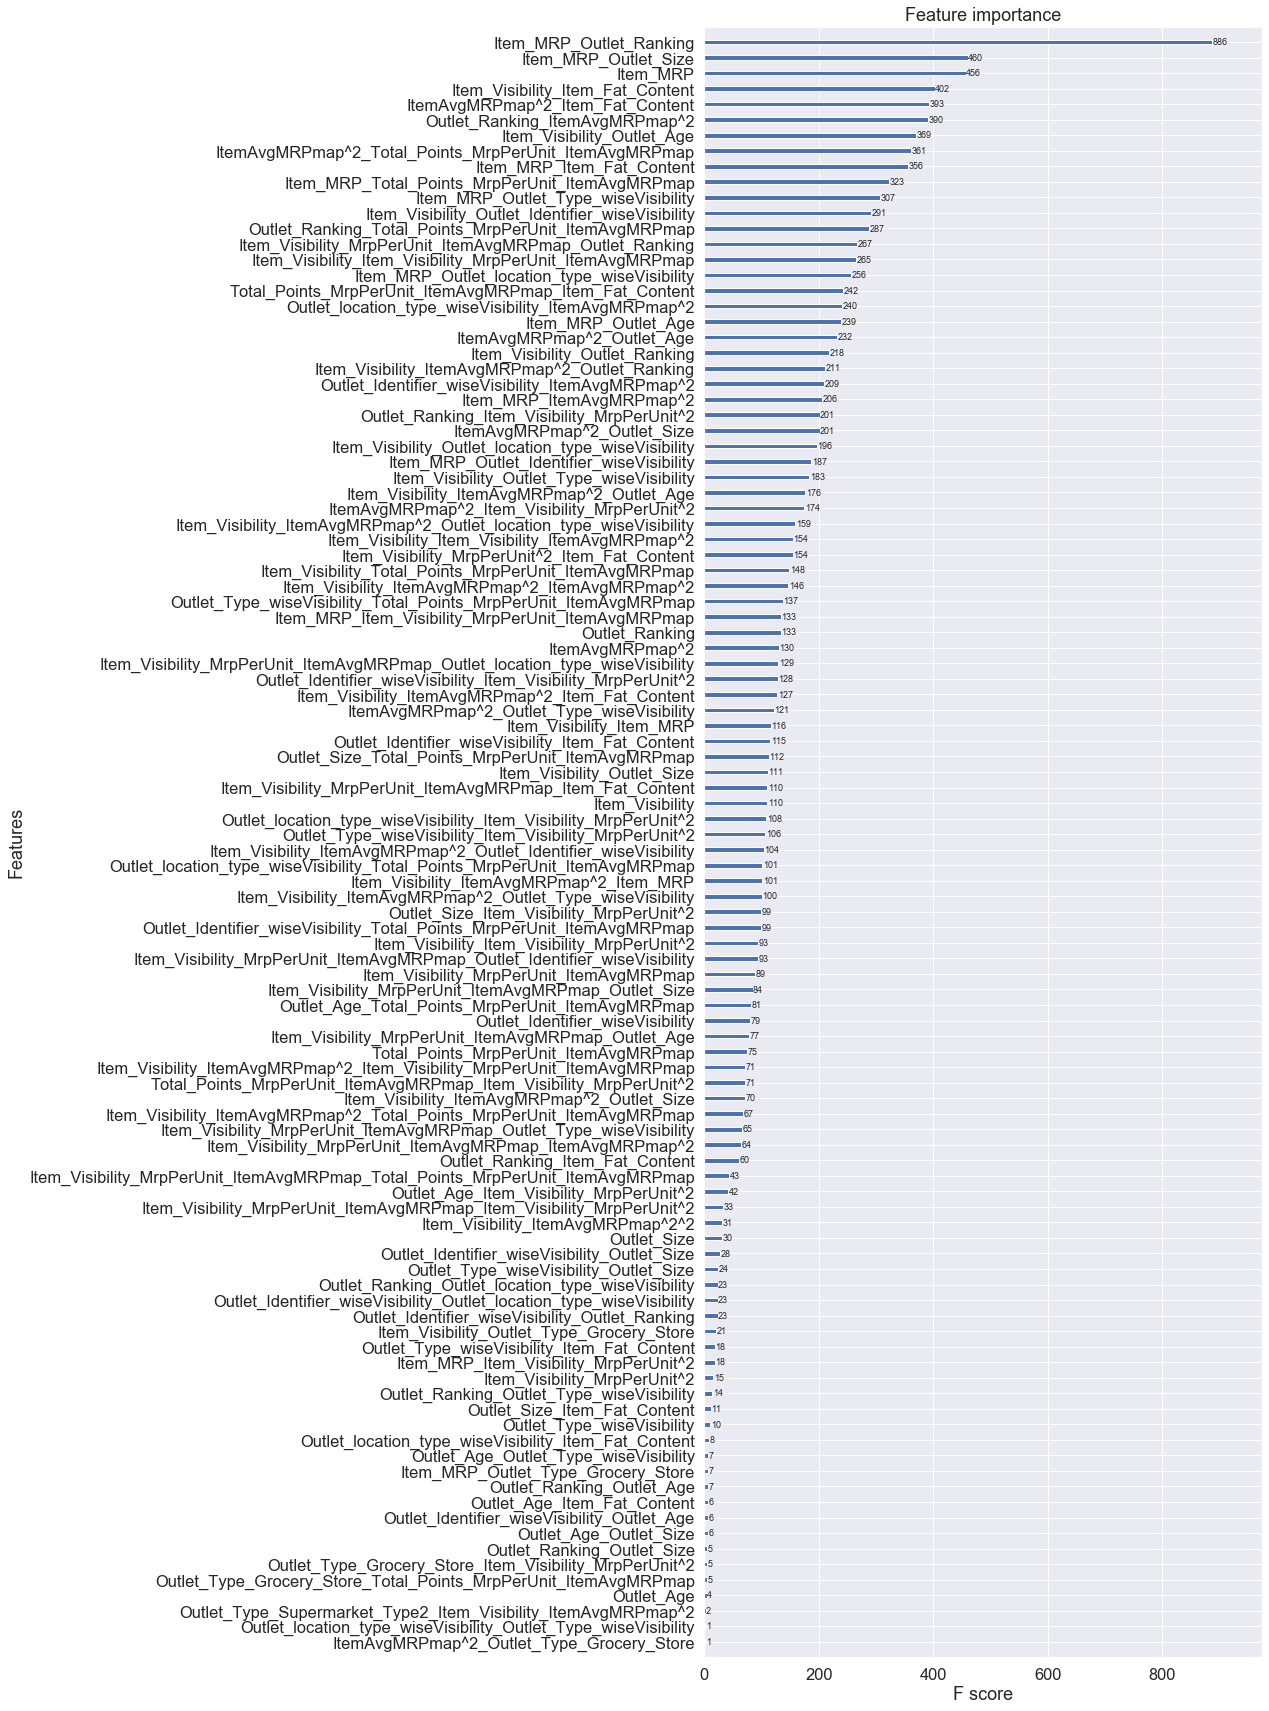

In [183]:
fig, ax = plt.subplots(1,1,figsize=(10,30))
# plot_importance(booster=booster, ax=ax, **kwargs)
g = plot_importance(XGBReg_estimator,ax=ax, height=.3)
#ax3.yticks(fontsize=12)

In [184]:
def featureImportance_BAR(_imp_features,_df1,show=1):
    _df=pd.DataFrame({'rank_value':imp_feature,'feature_name':_df1.columns},index=_df1.columns).sort_values('rank_value',ascending=False)
    _df=_df[_df['rank_value']>0.0001]
    if show==1:
        fig=plt.figure(figsize=(20,15))
        _df.plot.bar(figsize=(18,3),fontsize=12,color='red')
    print('Total Columns=',len(_df1))
    print('Number_of_good_columns=',len(_df))
    #print(_df['feature_name'])
    return _df

xbg_feat_importDF=featureImportance_BAR(imp_feature,xxtrain,0)

xgbm_best_col=list(xbg_feat_importDF[:70].feature_name.index)

XGBReg_estimator1 = xgb.XGBRegressor(**param_grid2,random_state=25)
XGBReg_estimator1.fit(xxtrain[xgbm_best_col], yytrain)
#rf2.fit(polyDF[:ntrain][goodcols], ytrain)
ptrain=XGBReg_estimator1.predict(xxtrain[xgbm_best_col])
pVali=XGBReg_estimator1.predict(xxVali[xgbm_best_col])
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)

Total Columns= 5966
Number_of_good_columns= 102

train R2: 0.6705254439516668 
Test R2: 0.5941564623831614

train rmse: 994.8723325005919 
Test Rmse: 1044.1957924086512


# ADA boost (introduced in 1995 by Freund and Schapire)
One thing that can be confusing is the difference between xgboost, lightGBM and Gradient Boosting Decision Trees (which we will henceforth refer to as GBDTs). Xgboost and lightGBM are both subtypes/specific instances of the GBDT algorithm

There are many boosting technique

1. GentleBoost

2. Gradient Boosting (Always my first choice for any Kaggle problem) (scikit GBDT differenct from xgbm)

3.  LPBoost

4. BrownBoost

5. Adaboost

It used one of ensemble method used for binary classification rather than regression.

It uses very short week learner called stump.

It also converts a set of weak classifiers into a strong classifier.

Unlike GBM( little more tree depth), the week learners have high bias and low variance.

It initializes default weight to each observation in the first iteration and makes the prediction and provide higher weight to incorrect predictions and pass on the next

The most essential difference between Boosting and bagging is that Boosting does not treat the basic model consistently. Instead, he tries to select the "elite" through constant testing and screening, and then gives the elite more voting rights. The poorly performing basic model gives Less voting rights, then combined with everyone's vote to get the final result


Following ideas combined together to invent adaptive boosting
1.	Types of Decision tree used in ADABOOST ensemble technique are stump types that means they have only one node and two leaves.
Stumps are also called weak learner.
2.	Variable for stump node is chosen by compare the weight gini score or entropy score of all the variables of dataset.
3.	Each stump are trained sequentially over weighted prediction of previous tree where higher weight is provided to incorrect predictions.
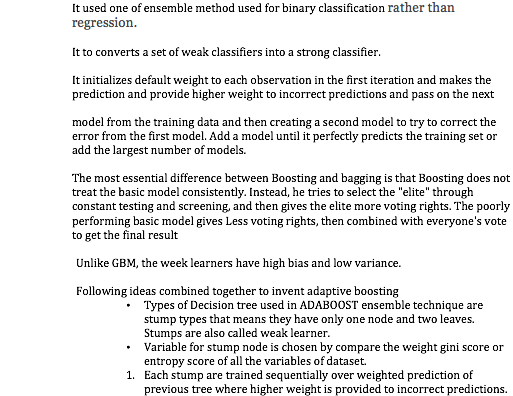

#### Tuning parameter
The number of weak learners is controlled by the parameter n_estimators. 

The learning_rate parameter controls the contribution of the weak learners in the final combination.

By default, weak learners are decision stumps. Different weak learners can be specified through the base_estimator parameter. The main parameters to tune to obtain good results are n_estimators and the complexity of the base estimators (e.g., its depth max_depth or minimum required number of samples to consider a split min_samples_split).

##### Controlling the tree size¶

If you specify max_depth=h then complete binary trees of depth h will be grown. Such trees will have (at most) 2**h leaf nodes and 2**h - 1 split nodes.

Alternatively, you can control the tree size by specifying the number of leaf nodes via the parameter max_leaf_nodes. In this case, trees will be grown using best-first search where nodes with the highest improvement in impurity will be expanded first. A tree with max_leaf_nodes=k has k - 1 split nodes and thus can model interactions of up to order max_leaf_nodes - 1 .

We found that max_leaf_nodes=k gives comparable results to max_depth=k-1 but is significantly faster to train at the expense of a slightly higher training error. The parameter max_leaf_nodes corresponds to the variable J in the chapter on gradient boosting in [F2001] and is related to the parameter interaction.depth in R’s gbm package where max_leaf_nodes == interaction.depth + 1



In [185]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
dic1={'min_samples_split': 45, 'min_samples_leaf': 10, 
       'max_leaf_nodes': 45, 'max_features': 'sqrt',
       'max_depth': 10, 'criterion': 'mse'}
ada={'base_estimator': DecisionTreeRegressor(**dic1), #(default=None)
      'n_estimators': 300, #(default=50)
      'learning_rate': 0.0006, #(default=1.)
      'loss': 'exponential',#},'linear',#'square', #
       'random_state':45}
AdaRegr=AdaBoostRegressor(**ada)
AdaRegr.fit(xxtrain, yytrain)
ptrain=AdaRegr.predict(xxtrain)
pVali=AdaRegr.predict(xxVali)
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
adaPred=generate_submission_file('n2.csv',AdaRegr,test_org,polyDF[ntrain:])




train R2: 0.6467053527834344 
Test R2: 0.6063486720944483

train rmse: 1030.2080550916135 
Test Rmse: 1028.3915080836073


In [186]:
# dic1={'min_samples_split': 45, 'min_samples_leaf': 10, 
#        'max_leaf_nodes': 45, 'max_features': 'sqrt',
#        'max_depth': 10, 'criterion': 'mse'}
# dtr= DecisionTreeRegressor(**dic1)

# Random_forest_random_grid = {
#                'n_estimators':[1000],
#                'learning_rate':  np.linspace(0.0000007,0.0006,20),
#                 'loss': ['exponential'],#'loss' : ['linear', 'square', 'exponential'],
#                 'random_state':[45]
#                 }
# rf1= RandomForestRegressor(random_state=46,**dic1)

# regr_2 = AdaBoostRegressor(dtr,
#                            random_state=10)

# regr_ada = RandomizedSearchCV(estimator = regr_2, param_distributions = Random_forest_random_grid, n_iter = 100, cv = 2,
#                                verbose=2, random_state=42, n_jobs = -1,scoring='neg_mean_squared_error')
# regr_ada.fit(xxtrain, yytrain)
# regr_ada_Bestmodel=regr_ada.best_estimator_
# ptrain=regr_ada_Bestmodel.predict(xxtrain)
# pVali=regr_ada_Bestmodel.predict(xxVali)
# Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
# Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
# Train_r2_sqV=r2_score(yytrain, ptrain)
# test_r2_sqV=r2_score(yyVali, pVali)
# print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
# print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
# xgbPred=generate_submission_file('n2.csv',regr_ada_Bestmodel,test_org,polyDF[ntrain:])

# light XGBM or Histogram based Gradient Boosting Regressor

XGBoost-XGBM/Light GBM are two open source implementation of the GBDT concept(scikit-learn has another version of GBDT algorithm, but XGBoost is faster and many other technical advantages.)

Although many engineering optimizations have been adopted Light GBM, the efficiency and scalability are still unsatisfactory when the feature dimension is high and data size is large.

Light GBM is different from Xgbm in terms of the way the tree grows.

XGBM employs level wise tree split strategy while light GBM employs leaf wise split strategy.


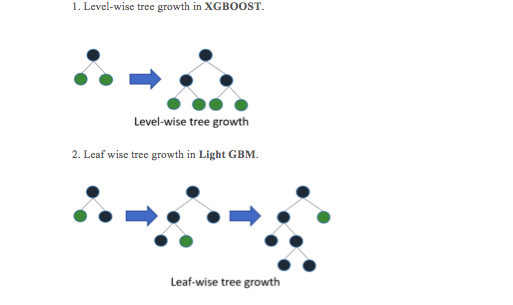
  
The level-wise strategy maintains a balanced tree, whereas the leaf-wise strategy splits the leaf that reduces the loss the most.

While other algorithms grow trees horizontally, Light GBM grows tree vertically meaning that Light GBM grows tree leaf-wise while other algorithms grow level-wise. It, in order to grow, will choose the leaf that has a max delta loss. When growing the same leaf, Leaf-wise algorithm can reduce more loss when compared to a level-wise algorithm.

Leaf wise splits lead to increase in complexity and may lead to overfitting and it can be overcome by specifying another parameter max-depth which specifies the depth to which splitting will occur while Level-wise training can be seen as a form of regularized training and do not overfit easily and considered reliable even with huge dataset.

Light GBM uses histogram-based algorithms while XGBM use pre-sort-based algorithms (easy but tough to optimize)!

light GBM tree has more depth as compared with XGBM when the number of leaves are same.

While if we set the max_Depth same for both algorithms, it will result in vastly different tree structure and complexity for both alogrithm



- https://lightgbm.readthedocs.io/en/latest/

##### why Light is faster  as employ histogram approach to evaluate and select best split.
    The amount of time it takes to build a tree is proportional to the number of splits that have to be evaluated. Often, small changes in the split don't make much of a difference in the performance of the tree. Histogram-based methods take advantage of this fact by grouping features into a set of bins and perform splitting on the bins instead of the features. This is equivalent to subsampling the number of splits that the model evaluates. Since the features can be binned before building each tree, this method can greatly speed up training, reducing the computational complexity


##### Tree balacing/ Accuracy / histogram binning
    Though conceptually simple, histogram-based methods present several choices that the user has to make. Firstly the number of bins creates a trade-off between speed and accuracy: the more bins there are, the more accurate the algorithm is, but the slower it is as well. Secondly, how to divide the features into discrete bins is a non-trivial problem: dividing the bins into equal intervals (the most simple method) can often result in an unbalanced allocation of data. Though the details are beyond the scope of this post, the "most balanced" method of dividing the bins actually depends on the gradient statistics. Xgboost offers the option tree_method=approx, which computes a new set of bins at each split using the gradient statistics. LightGBM and xgboost with the tree_method set to hist will both compute the bins at the beginning of training and reuse the same bins throughout the entire training process.

##### Ignoring sparse inputs (xgboost and lightGBM) and handling missing value
    Xgboost and lightGBM tend to be used on tabular data or text data that has been vectorized. Therefore, the inputs to xgboost and lightGBM tend to be sparse. Since the vast majority of the values will be 0, having to look through all the values of a sparse feature is wasteful. Xgboost proposes to ignore the 0 features when computing the split, then allocating all the data with missing values to whichever side of the split reduces the loss more. This reduces the number of samples that have to be used when evaluating each split, speeding up the training process.

    Though lightGBM does not enable ignoring zero values by default, it has an option called zero_as_missing which, if set to True, will regard all zero values as missing while in xgboost, we need to set parameter 'use_missing' to True 

##### Subsampling the data: Gradient-based One-Side Sampling (lightGBM)
    This is a method that is employed exclusively in lightGBM. The essential observation behind this method is that not all data points contribute equally to training; data points with small gradients tend to be more well trained (close to a local minima). This means that it is more efficient to concentrate on data points with larger gradients.

    The most straightforward way to use this observation is to simply ignore data points with small gradients when computing the best split. However, this has the risk of leading to biased sampling, changing the distribution of data. For instance, if data that belonged to the "young" age group tended to be less well trained, the sampled data will have a much younger age distribution. This means that the split is likely to be younger than the optimal value.

    In order to mitigate this problem, lightGBM also randomly samples from data with small gradients. This results in a sample that is still biased towards data with large gradients, so lightGBM increases the weight of the samples with small gradients when computing their contribution to the change in loss (this is a form of importance sampling, a technique for efficient sampling from an arbitrary distribution).

#### Advantages of Light GBM
1.	Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
2.	Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
3.	Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
4.	Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST.
5.	Parallel learning supported.


#### Important Parameters of light GBM
1. task : default value = train ; options = train , prediction ; Specifies the task we wish to perform which is either train or prediction.
2. application: default=regression, type=enum, options= options :
    o	regression : perform regression task
    o	binary : Binary classification
    o	multiclass: Multiclass Classification
    o	lambdarank : lambdarank application
3.	data: type=string; training data , LightGBM will train from this data
4.	num_iterations: number of boosting iterations to be performed ; default=100; type=int
5.	num_leaves : number of leaves in one tree ; default = 31 ; type =int
6.	device : default= cpu ; options = gpu,cpu. Device on which we want to train our model. Choose GPU for faster training.
7.	max_depth: Specify the max depth to which tree will grow. This parameter is used to deal with overfitting.
8.	min_data_in_leaf: Min number of data in one leaf.
9.	feature_fraction: default=1 ; specifies the fraction of features to be taken for each iteration
10.	bagging_fraction: default=1 ; specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.
11.	min_gain_to_split: default=.1 ; min gain to perform splitting
12.	max_bin : max number of bins to bucket the feature values.
13.	min_data_in_bin : min number of data in one bin
14.	num_threads: default=OpenMP_default, type=int ;Number of threads for Light GBM.
15.	label : type=string ; specify the label column
16.	categorical_feature : type=string ; specify the categorical features we want to use for training our model
17.	num_class: default=1 ; type=int ; used only for multi-class classification

# Implementation/Tuning of Light GBM 
GBM implementation is quite easy, the only thing that turns out to be complicated is parameter tuning. Light GBM covers more than 100 parameters and It is very important for an implementer to know at least some basic parameters of Light GBM.


#### leaf-wise tree, these are some important parameters:

    num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

    min_data_in_leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

    max_depth. You also can use max_depth to limit the tree depth explicitly.

#### For Faster Speed
    Use bagging by setting bagging_fraction and bagging_freq

    Use feature sub-sampling by setting feature_fraction

    Use small max_bin

    Use save_binary to speed up data loading in future learning

    Use parallel learning, refer to Parallel Learning Guide

#### For Better Accuracy
    Use large max_bin (may be slower)

    Use small learning_rate with large num_iterations

    Use large num_leaves (may cause over-fitting)

    Use bigger training data

    Try dart

#### Deal with Over-fitting
    Use small max_bin

    Use small num_leaves

    Use min_data_in_leaf and min_sum_hessian_in_leaf

    Use bagging by set bagging_fraction and bagging_freq

    Use feature sub-sampling by set feature_fraction

    Use bigger training data

    Try lambda_l1, lambda_l2 and min_gain_to_split for regularization

    Try max_depth to avoid growing deep tree

Try extra_trees

In the LightGBM model, there are two was of feature importance
   - 'split', result contains numbers of times the feature is used in a model, 
   - 'gain', result contains total gains of splits which uses the feature.

On the XGBoost model the importance is calculated by:

- 'weight': the number of times a feature is used to split the data across all trees.
- 'gain': the average gain across all splits the feature is used in.
- 'cover': the average coverage across all splits the feature is used in.
- 'total_gain': the total gain across all splits the feature is used in.
- 'total_cover': the total coverage across all splits the feature is used in.

First measure is split-based and is very similar with the one given by for Gini Importance. But it doesn't take the number of samples into account.

The second measure is gain-based. It's basically the same as the Gini Importance implemented in R packages and in scikit-learn with Gini impurity replaced by the objective used by the gradient boosting model.

The cover, implemented exclusively in XGBoost, is counting the number of samples affected by the splits based on a feature.

- get_score(fmap='', importance_type='weight'): Get feature importance of each feature. 



In [187]:
from lightgbm import LGBMRegressor
# Save the move 
#   bst.save_model('model.txt')
# read the model back
#   bst = lgb.Booster(model_file='model.txt')  # init model
#lgb.cv(param, train_data, num_round, nfold=5)
#bst.best_iteration:

In [188]:
param_LGBM = {
  #num_leaves=10 # This is the main parameter to control the complexity of the tree model. Theoretically, we can set
            #num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. 
            #However, this simple conversion is not good in practice. The reason is that a leaf-wise tree 
        #is typically much deeper than a depth-wise tree for a fixed number of leaves.
    # Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, 
    #we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree 
    #can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80
    #may get better accuracy than depth-wise. 
    
#min_data_in_leaf = #. This is a very important parameter to prevent 
    #over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves.
    #Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. 
    #In practice, setting it to hundreds or thousands is enough for a large dataset.
#'max_depth':10,
#'num_leaves':10
# For Faster Speed-----------------
#   Use bagging by setting 
  #  bagging_fraction= 
  #  bagging_freq=

# Use feature sub-sampling by setting 
   # feature_fraction=

#Use small 
    #max_bin=

#  to speed up data loading in future learning
    #save_binary=

#Use parallel learning, refer to Parallel Learning Guide

# For Better Accuracy ------------------
#Use large (may be slower)
    #max_bin =

# Use small learning_rate with large num_iterations
#learning_rate=
#num_iterations=

# Use large num_leaves (may cause over-fitting)
#num_leaves=
#Use bigger training data

# Try dart

# Deal with Over-fitting ----------------
#Use small max_bin

#Use small num_leaves

#Use min_data_in_leaf and min_sum_hessian_in_leaf

#Use bagging by set bagging_fraction and bagging_freq

#Use feature sub-sampling by set feature_fraction

#Use bigger training data

#Try lambda_l1, lambda_l2 and min_gain_to_split for regularization

#Try max_depth to avoid growing deep tree

#Try extra_trees
#'boosting_type':'dart',Default='gbdt'
'max_depth':[3,5,10,20],
'num_leaves':[4,5,10,20],
'min_data_in_leaf':[20,50,150,300],
'n_estimators':[550],# (int, optional (default=100))
'learning_rate':[0.04,0.5,0.1,0.2]# (default=0.1))
#    'cv':5
}
LGBM_Reg_estimator =  LGBMRegressor(**param_LGBM,random_state=25)
#print(LGBM_Reg_estimator)
regr_lgbm = RandomizedSearchCV(estimator = LGBM_Reg_estimator, param_distributions = param_LGBM, n_iter = 100, cv = 2,
                                verbose=2, random_state=42, n_jobs = -1,scoring='neg_mean_squared_error')

regr_lgbm.fit(xxtrain, yytrain)
#LGBM_Reg_estimator.fit(polyDF[:ntrain][goodcols], ytrain)
LGBM_Reg_estimator=regr_lgbm.best_estimator_
ptrain=LGBM_Reg_estimator.predict(xxtrain)
pVali=LGBM_Reg_estimator.predict(xxVali)
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
LxgbPredx=generate_submission_file('n2.csv',LGBM_Reg_estimator,test_org,polyDF[ntrain:])



Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.0min finished



train R2: 0.6390167192915805 
Test R2: 0.6017718695429162

train rmse: 1041.3577568103356 
Test Rmse: 1034.352548621275
Output contain Negative records: 1


In [189]:
best_lgb={
 'learning_rate': 0.01,
 'n_estimators': 550,
 'max_depth': 12,
 'num_leaves': 20,
 'min_data_in_leaf': 15,
'feature_fraction':0.9,
'min_sum_hessian_in_leaf':90,
'lambda_l2':26,
'lambda_l1':.0005,
'boosting_type':'gbdt',
'subsample_for_bin':6800,
'min_gain_to_split':22000
 #'max_bin':2000
 #'bagging_fraction':.9
}
regr_lgbm1 =  LGBMRegressor(**best_lgb,random_state=25)
regr_lgbm1.fit(xxtrain, yytrain)
ptrain=regr_lgbm1.predict(xxtrain)
pVali=regr_lgbm1.predict(xxVali)
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
LxgbPred=generate_submission_file('n2.csv',regr_lgbm1,test_org,polyDF[ntrain:])



train R2: 0.6784330085115697 
Test R2: 0.5987517912538274

train rmse: 982.861093249218 
Test Rmse: 1038.2672964503145


# Random forest boosting with ADAboost
    Random forest reduces variance
    boosting reducess bias
    always week random forest learner

In [190]:
dic1={'criterion': 'mse',
     'max_depth': 5,
      'min_samples_leaf': 5,
      #'min_samples_split': 3, 
      # 'max_leaf_nodes': 46, 
      #'max_features': 'log2', 
      'n_estimators': 45,
       #     'learning_rate': 0.0006, #(default=1.)
      #'loss': 'exponential',#},'linear',#'square', #
     }
rf1= RandomForestRegressor(random_state=46,**dic1)
regr_Ada_withRF = AdaBoostRegressor(rf1,random_state=10,n_estimators=55,learning_rate=0.0003)
regr_Ada_withRF.fit(xxtrain, yytrain)
ptrain=regr_Ada_withRF.predict(xxtrain)
pVali=regr_Ada_withRF.predict(xxVali)
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
regr_Ada_withRFPred=generate_submission_file('n2.csv',regr_Ada_withRF,test_org,polyDF[ntrain:])



train R2: 0.6278598359767618 
Test R2: 0.6078614088762548

train rmse: 1057.3278821749625 
Test Rmse: 1026.4136370730334


In [191]:
# dic1={'n_estimators': 70, 'min_samples_split': 3, 
#       'min_samples_leaf': 6, 'max_leaf_nodes': 76, 
#       'max_features': 'log2', 'max_depth': 7, 
#       'criterion': 'mse'}
# Random_forest_random_grid = {
#                'learning_rate': np.linspace(0.00000007,1.5,100),
#                 'loss' : ['exponential']#['linear', 'square', ,
#                 'n_estimators': [i for i in range(10,200,50)],
#                 }
# rf1= RandomForestRegressor(random_state=46,**dic1)

# regr_2 = AdaBoostRegressor(rf,
#                            random_state=10)

# regr_2_random = RandomizedSearchCV(estimator = regr_2, param_distributions = Random_forest_random_grid, n_iter = 20, cv = 6,
#                                verbose=2, random_state=42, n_jobs = -1,scoring='neg_mean_squared_error')
# #model_type_wise_hyperParams_grid_dict['random_forest_regressor']=Random_forest_random_grid
# regr_2_random.fit(xtrain,ytrain)
# print(regr_2_random.best_params_)
# print("Best: %f using %s" % (np.sqrt(-1*regr_2_random.best_score_), regr_2_random.best_params_))
# print(regr_2_random.best_estimator_)
# #regressionModelfit_CV(regr_2_random.best_estimator_,xtrain.columns, xtrain, ytrain,'modelname',6)


# Ranking Avg
## Found best score of 1139 with 17th rank on Analytical Vidhya

In [636]:
all_Pred=pd.DataFrame({
                      # "bagged":baggPred,
                       "DT":dtPred,
                       "XGB":xgbPred,
                       "ADA":adaPred,
                       "LXGB":LxgbPred,
                        #"Ada_withRF":regr_Ada_withRFPred,
                        # "RF":rfPred,
                      })
avg_Pred=all_Pred.mean(1)
def generate_submission_file_avg(submission_csv_name,org_test,yAvgPred):
#Export submission file:
    org_test['Item_Outlet_Sales']=yAvgPred
    submission=org_test[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
    submission.to_csv(submission_csv_name, index=False)
    return yAvgPred
e=generate_submission_file_avg('Final_Score.csv',test_org,avg_Pred)

# Stacked Generalization and  blending used ...
# But not found useful

In [1148]:
XGBReg_estimator.predict(polyDF[:ntrain])
new_TrainPred=pd.DataFrame(columns=['DT','XGB','ADA','LXGB'])
new_TrainPred['DT']=dt_DefaultModel.predict(polyDF[:ntrain])
new_TrainPred['XGB']=XGBReg_estimator.predict(polyDF[:ntrain])
new_TrainPred['ADA']=AdaRegr.predict(polyDF[:ntrain])
new_TrainPred['LXGB']=regr_lgbm1.predict(polyDF[:ntrain])
new_TrainPred[label_col]=ytrain
new_TrainPred=getPolyR2(['DT','XGB','ADA','LXGB'],label_col,new_TrainPred,2,1)
new_TrainPred['avg']=new_TrainPred[['DT','XGB','ADA','LXGB']].mean(1)
#new_TrainPred['Item_MRP']=polyDF[:ntrain]['Item_MRP']

new_TestPred=pd.DataFrame(columns=['DT','XGB','ADA','LXGB'])
new_TestPred['DT']=dt_DefaultModel.predict(polyDF[ntrain:])
new_TestPred['XGB']=XGBReg_estimator.predict(polyDF[ntrain:])
new_TestPred['ADA']=AdaRegr.predict(polyDF[ntrain:])
new_TestPred['LXGB']=regr_lgbm1.predict(polyDF[ntrain:])
new_TestPred[label_col]=data[ntrain:][label_col]
new_TestPred=getPolyR2(['DT','XGB','ADA','LXGB'],label_col,new_TestPred,2,1)
new_TestPred['avg']=new_TestPred[['DT','XGB','ADA','LXGB']].mean(1)

#new_TestPred['Item_MRP']=polyDF[ntrain:]['Item_MRP']

xxTrainPred=pd.DataFrame()#columns=['DT','XGB','ADA','LXGB','Ada_withRF'])
xxTrainPred['DT']=dt_DefaultModel.predict(xxtrain)
xxTrainPred['XGB']=XGBReg_estimator.predict(xxtrain)
xxTrainPred['ADA']=AdaRegr.predict(xxtrain)
xxTrainPred['LXGB']=regr_lgbm1.predict(xxtrain)
xxTrainPred[label_col]=yytrain
xxTrainPred=getPolyR2(['DT','XGB','ADA','LXGB'],label_col,xxTrainPred,2,1)
xxTrainPred['avg']=xxTrainPred[['DT','XGB','ADA','LXGB']].mean(1)

#xxTrainPred['Item_MRP']=xxtrain['Item_MRP']

xxValiPred=pd.DataFrame()#(columns=['DT','XGB','ADA','LXGB','Ada_withRF'])
xxValiPred['DT']=dt_DefaultModel.predict(xxVali)
xxValiPred['XGB']=XGBReg_estimator.predict(xxVali)
xxValiPred['ADA']=AdaRegr.predict(xxVali)
xxValiPred['LXGB']=regr_lgbm1.predict(xxVali)
xxValiPred[label_col]=yyVali
xxValiPred=getPolyR2(['DT','XGB','ADA','LXGB'],label_col,xxValiPred,2,1)
xxValiPred['avg']=xxValiPred[['DT','XGB','ADA','LXGB']].mean(1)

#xxValiPred['Item_MRP']=xxVali['Item_MRP']


In [1175]:
mydict= {
    # Parameters that we are going to tune.
    'silent':1,
   # 'subsample':0.5,
    # Other parameters
   #'early_stopping_rounds':[3],
   'n_estimators' : 2000,#135,
   'learning_rate': .004, # negativity correlated with n_estimators
    
    #'objective': 'reg:linear',#'reg:tweedie','reg:gamma'],
   # 'max_depth' :5,    
    #"min_child_weight" : 10,
    #"reg_lambda":.0000001,  # ridge
   "reg_alpha":210000,  # lasso
    #"colsample_bytree" : .8,  # max features,
    "seed":45   }
#XGBReg_estimator1 
best_est = xgb.XGBRegressor(**mydict,random_state=25)
regr_3_random = RandomizedSearchCV(estimator = XGBReg_estimator1, param_distributions = mydict, n_iter = 50, cv = 5,
                                verbose=2, random_state=42, n_jobs = -1,scoring='r2')
#regr_3_random.fit(new_TrainPred, ytrain)
#print(regr_3_random.best_params_)
#best_est=regr_3_random.best_estimator_
best_est.fit(xxTrainPred, yytrain)
ptrain=best_est.predict(xxTrainPred)
pVali=best_est.predict(xxValiPred)
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
regr_Ada_withRFPred=generate_submission_file('n2.csv',best_est,test_org,new_TestPred)


train R2: 0.6813410255389272 
Test R2: 0.5838720149715142

train rmse: 978.4068612064686 
Test Rmse: 1057.3434594912262


# Stacking Regressor 
Taking too much time 

In [934]:
paramDTStack={     "criterion": "mse",
              "min_samples_split": 100,#[i for i in range(3,500,10)],
              "max_depth": 6,# [i for i in range(2,,3)],
              #"min_samples_leaf": 4 ,#[i for i in range(1,500,20)],
              #"max_leaf_nodes": 30,#[i for i in range(2,100,20)],
              "max_features":'auto'# ['auto', 'sqrt', 'log2'],
              }

from mlxtend.regressor import StackingRegressor ,StackingCVRegressor
#from sklearn.ensemble import StackingRegressor
estimators = [     ('dt', dt_DefaultModel)#,
#                    ('baggDT', BgingRegr),
#                    ('rf',rf),
#                    ('XGBReg',XGBReg_estimator),
#                    ('AdaRegr',AdaRegr),
#                    ('LGBM',regr_lgbm1),
#                    ('Ada_withRFPred',regr_Ada_withRF),
             ]
#estimators
regStack = StackingRegressor(
      regressors=(dt_DefaultModel,XGBReg_estimator,AdaRegr,regr_lgbm1,regr_Ada_withRF),
      meta_regressor=DecisionTreeRegressor(**paramDTStack)
    #RandomForestRegressor(n_estimators=10,random_state=42)
     )
regStack.fit(xxtrain, yytrain)
ptrain=regStack.predict(xxtrain)
pVali=regStack.predict(xxVali)
Train_rmse=np.sqrt(np.mean((ptrain - yytrain)*(ptrain - yytrain)))
Test_rmse=np.sqrt(np.mean((pVali - yyVali)*(pVali - yyVali)))
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Train_r2_sqV=r2_score(yytrain, ptrain)
test_r2_sqV=r2_score(yyVali, pVali)
print("\ntrain R2:",Train_r2_sqV,"\nTest R2:",test_r2_sqV)
print("\ntrain rmse:",Train_rmse,"\nTest Rmse:",Test_rmse)
regStack_Pred=generate_submission_file('n2.csv',regStack,test_org,polyDF[ntrain:])



train R2: 0.7366472737908474 
Test R2: 0.5200857000140832

train rmse: 889.4577463681043 
Test Rmse: 1135.4930145034705


# Problem Statement
###### The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. 
###### Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and 
###### find out the sales of each product at a particular store.

###### Using this model, BigMart will try to understand the properties of products and stores which play a key role in 
###### increasing sales.

######   Please note that the data may have missing values as some stores might not report all the data due to technical
######   glitches. Hence, it will be required to treat them accordingly.


# Hypothises 
### 1. Hypothetically  sales depends on stores with following parameters (without Looking data Data)
######            City, Density of population,  store location, store capacity, marketing, competeters, Ambiance, customer behaviour
   

### 2. Hypothetically sales depends on product with following parameters (without Looking at Data)
##### Brand, display area, packaging, promotion offer, utility, return policy, advertisment


# Feature transformation (categorical Vars)
### 1. should be done based on input taken from univariate analysis on categorical columns 
#### Note:  Feature Transformation is one of the Feature Engineering technique

# Feature transformation  on  Contineous Variable
#### 1.       Should be done after performing Univariate Analysis on  Contineous Variable
#### Note:  Feature Transformation is one of the Feature Engineering technique

# Correlation with Label Column
### We should all the contineous columns which are correlated with label

# Bivariate Analysis 
### independent Contineous variable and Contineos variable ( label column)

# target Variable distribution

# 1. Data Preprocessing 

# Standardizing Contineos columns

# Feature Engineering using Feature Tool ( Not Yet tested)

In [390]:
# featuretools for automated feature engineering
import featuretools as ft

# create Empty Entity set with id applications
es = ft.EntitySet(id = 'clients')

# Lets add add dataset to empty dataset
es.entity_from_dataframe(entity_id = 'app', dataframe = test, index = 'index') #variable_types = app_types
#make_index=True
es

# use DFS-Deep Feature Synthesis to create to new features
# It return two things ( feature list and feature definations)
feature_list_test, feature_defs_test = ft.dfs(entityset=es, target_entity='app',max_depth=2,
                                   trans_primitives=['add_numeric','multiply_numeric'])
#print(feature_defs)
#feature_list.head(10)

# xfeature_list = feature_list[:train.shape[0]]
# yfeature_list = feature_list[train.shape[0]:]

2020-03-18 14:09:24,422 featuretools.entityset - WARNING    index index not found in dataframe, creating new integer column


# 4. Model Building

# Stacking Version 1 (avg of  predictions + orig dataset)
### ( Tuning  method 2)
##### where avg multiple model predictions are taken ( that these are selected best hyper tuned model )
##### and We have Merged with the all existing features To generate with train and test dataset
##### We have used this new train and test dataset to tried different regressors to  generate test prediction
##### 1452 is the mse score is obtained ( bad score)
##### Here a last step we tried to Again Avg Out the predictions from different model over new test and train dataset
##### But NO luck

# Stacking Version 2 ( use combined multiple predictations as test/train dataset)
### ( Tuning  method 3)

##### we have  multiple model predictions are taken ( that these are selected best hyper tuned model )
##### and Considering these predictions as train and test dataset
##### We have used this new train and test dataset to tried different regressors to  generate test prediction
##### 1452 is the mse score is obtained ( bad score)
##### Here a last step we tried to Again Avg the predictions from different model over new test and train dataset
##### But NO luck

# Stacking Version 3 ( basic model predictions are stacked)
### ( Tuning  method 4)
##### Here we obtain multiple predictions from the base models
##### All the multiple prediction are used to generated new test and train dataset
##### this new dataset is finally used to generated final test predicton

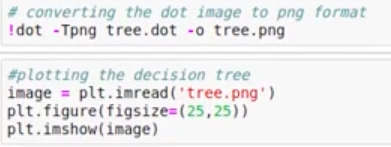